# Outline

## 
1. Developing functions
2. Transfer time for each simulation + graph
3. Transfer time for each category + graph
4. Calculation of rates:
    4.1 Transfer rates
    4.2 Degradation rates
    4.3 Resuspension and burial rates
    4.4 Resurfacing rate + graph
5. Construction of matrices:
    5.1 EF matrix
    5.2 k, FF, CF matrices per simulation (Total:32)
    5.3 k, FF, CF matrices per category:
        - minimum and maximum k, FF, CF for each category
        - Range values for k, FF, CF
        - Graphs

In [42]:
import sys
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import math
import plotly
from scipy.optimize import curve_fit

# In oder not to have so many decimals
pd.set_option("display.float_format", "{:.2e}".format)

# 1. Create functions

In [43]:
# To calculate the rate
def rate(time):
    return 1 / time

# 2. Read the files

In [ ]:
#transfer = pd.read_csv(r"C:\Users\10User\Desktop\TrackMPD-master\Results\All_results_article3\Rate_tables\January2016\Rates_AllRegions_Allpolymers.csv")
#transfer = pd.read_csv(r'C:\Users\10User\Desktop\TrackMPD-master\Results\All_results_article3\Rate_tables\January2016\OnlySphere_SmallDomains\Rates_final.csv')

# Save a version without the multiindex
#transfer1 = transfer.copy()

#transfer.loc[:,"Size_all"] *=1000000 # to convert the units between particles size from m in TrackMPD (and my file) and in Elena's file (micrometer)
#transfer = transfer.set_index(['Country_all','Polymer_all','Shape_all','Size_all']).fillna(0)

In [ ]:
# Add unmodelled polymers to transfer

#for x in ['PLA', 'PET', 'PVC', 'TRWP']:
 #   df = transfer.loc(axis=0)[:,'PS'].copy()
  #  df = df.reset_index()
   # df.loc[:,'Polymer_all'] = x
    #df = df.set_index(['Country_all','Polymer_all','Shape_all','Size_all'])
    #transfer = pd.concat([transfer,df])

# Save to manually add their densities
#transfer.reset_index().to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\transfer.xlsx")


In [44]:
# Reread the saved file
transfer = pd.read_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\transfer.xlsx")
transfer = transfer.set_index(['Country_all','Polymer_all','Shape_all','Size_all']).fillna(0).drop('Unnamed: 0', axis=1)

In [45]:
degradation = pd.read_excel("SI_C_FFs.xlsx", None)

# Restructure the file by selecting the "Degradation" sheet and removing the first three rows
degradation["Degradation"] = degradation["Degradation"].drop([0, 1, 2])
# Set the third row (first after omitting the first ones) as the title for columns
degradation["Degradation"] = degradation["Degradation"].T.set_index([3]).T

# List comprehension: we are looping over the column of Polymer type. Then using rstrip we are removing the space from the right part of Polymer type in the degradation file
degradation['Degradation'].loc[:,'Polymer type'] = [i.rstrip() for i in degradation['Degradation'].loc[:,'Polymer type']]

# The first three columns are set in the index so that we can filter for them as indexes
degradation["Degradation"] = degradation["Degradation"].set_index(
    ["Polymer type", "Size [µm]", "Degradation scenario"]
)
degradation["Degradation"].columns.name = None
degradation["Degradation"]=degradation["Degradation"].rename(columns={"Microbead/spherical shape":"sphere","Microfiber/cylindrical shape":"fiber"})

# 3. Define constant rates

In [46]:
k_resuspension = 2.3E-4 # day-1
k_burial = 2.37E-5 # day-1
k_resurfacing = 4.5E-1 # day-1

# 4. Building matrices

## 4.1 Effect matrix EEF

In [47]:
# Read the percentage between dry beach and wet beach from the file 
Species_richness = pd.read_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\SpeciesRichness.xlsx", sheet_name = 'Percentages1')
Species_richness = Species_richness.iloc[16:,4:]
Species_richness.columns = Species_richness.iloc[0]
Species_richness = Species_richness.drop(Species_richness.iloc[0].name).dropna(how='all',axis=0)
Species_richness = Species_richness.set_index('Region')

# Create the dictionary for the names of regions
dict_regionNames = {'EC-Japan': 'Pacific,Northwest', 'OkhotskSea': 'Pacific,Northwest', 'SouthChina': 'Pacific,Northwest', 'BayBengal':'Indian Ocean Eastern', 
                    'Indus': 'Indian Ocean Western', 'Mediterranean': 'Mediterranean and Black Sea', 'Congo':'Atlantic Southeast', 'GulfGuinea': 'Atlantic, Eastern Central'}

# Values of effect factors:
EEF_marWa = 1067.5 #PAF.m3/kg (Saadi et al., 2024)
EEF_marSed = 16.2 #PAF.m3/kg (Saadi et al., 2024)
EF_terrestre = 1.38 #PAF.m3/kg from Tunali et al., (submitted) for the MPs (2.02 PAF.kg/g then to convert to PAF.m3/kg we divide by 1460kg/m3(soil density)*1000(g/kg))

dict_EEF = {}


for key in dict_regionNames:
    EEF_matrix = pd.DataFrame(0, index=["b.C", "ws.C", "wc.C", "sed.C","glo"],
        columns=["b.C", "ws.C", "wc.C", "sed.C","glo"],)

    Percent_dry = Species_richness.loc[dict_regionNames[key]].loc[ # for key (e.g. EC-Japan), it selects the value of key in dict_regionNames and pass it in Species_richness
    Species_richness.loc[dict_regionNames[key]].loc[:, 'Sub-compartment']  == 'Beach-dry', # For the lines selected in species_richness, 
    # i filter True and False for the condition (e.g., if gthe sub-compartment is true == Beach-dry)  
    'Sub-percentages'].iloc[0] # for the line where it is true, it takes the Sub-percentage column and with .iloc[0] it takes the value 

    Percent_wet = Species_richness.loc[dict_regionNames[key]].loc[
        Species_richness.loc[dict_regionNames[key]].loc[:, "Sub-compartment"] == 'Beach-wet (water+sediments)', 
        'Sub-percentages'].iloc[0]
    
    Percent_water = 0.446 # 44.6% (Saadi et al., 2024)
    Percent_sed = 0.554 # 55.4% (Saadi et al., 2024)
    
    EEF_matrix.loc['b.C','b.C'] = Percent_dry * EF_terrestre + Percent_wet * (Percent_water*EEF_marWa + Percent_sed*EEF_marSed) 
    EEF_matrix.loc["ws.C","ws.C"] = EEF_marWa
    EEF_matrix.loc["wc.C","wc.C"] = EEF_marWa
    EEF_matrix.loc["sed.C","sed.C"] = EEF_marSed
    EEF_matrix.loc["glo","glo"] = EEF_marWa

    dict_EEF[key]=EEF_matrix # store each matrix for its key

## 4.2 SDF matrix - GLAM

In [48]:
# In the GLAM SDF, the sum of SDFs: SDF_b, SDF_ws, SDF_wc, SDF_sed, SDF_glo is equal to one. In this approach I am calculating the PAF and PDF in the global marine environment as a whole

dict_SDF_GLAM = {}
for key in dict_regionNames:
    SDF_matrix = pd.DataFrame(0, index=["SDF"], columns=["b.C", "ws.C", "wc.C", "sed.C","glo"],)

    # Define the percentages
    Percent_ws = 0.662 # 66.2% (Costello & Chauhdhary, 2017) value verified 
    Percent_wc = 0.338 # 33.8% (Costello & Chauhdhary, 2017) value verified 

    Percent_b = Species_richness.loc[dict_regionNames[key]].loc[Species_richness.loc[dict_regionNames[key]].loc[:, "Sub-compartment"] == 'Beach-dry', 
        r'% of compartments'].iloc[0] # regionalized from IUCN (the value in the excel file is on the line of Beach-dry but it accounts for both dry and wet beach)
    
    Percent_cont = Species_richness.loc[dict_regionNames[key]].loc[
        Species_richness.loc[dict_regionNames[key]].loc[:, "Sub-compartment"] == 'Continental scale (ws-wc-sed)', 
        r'% of compartments'].iloc[0] # regionalized from IUCN
    Percent_glo = Species_richness.loc[dict_regionNames[key]].loc[
        Species_richness.loc[dict_regionNames[key]].loc[:, "Sub-compartment"] == 'Global sediments', 
        r'% of compartments'].iloc[0]  # regionalized from IUCN (the value in the excel file is on the line of Global sediments)


    SDF_matrix.loc[('SDF'), 'b.C'] = Percent_b * (Percent_dry + Percent_wet * (Percent_water + Percent_sed)) 
    SDF_matrix.loc[('SDF'), 'ws.C'] = Percent_cont * Percent_water * Percent_ws
    SDF_matrix.loc[('SDF'), 'wc.C'] = Percent_cont * Percent_water * Percent_wc
    SDF_matrix.loc[('SDF'), 'sed.C'] = Percent_cont * Percent_sed
    SDF_matrix.loc[('SDF'), 'glo'] = Percent_glo

    dict_SDF_GLAM[key] = SDF_matrix



## 4.3 SDF matrix - IMPACT WORLD +

In [49]:
# In IW+, the sum of SDFs of vertically superimposed compartments is 100. Thus, SDF_b = 100, SDF_glo = 100, SDF_cont (SDF_ws + SDF_wc + SDF_glo) = 100. The sum of all SDFs is 300%

dict_SDF_IW = {}
for key in dict_regionNames:
    SDF_matrix = pd.DataFrame(0, index=["b.C", "ws.C", "wc.C", "sed.C","glo"], columns=["b.C", "ws.C", "wc.C", "sed.C","glo"],)

    # Define the percentages
    Percent_ws = 0.662 # 66.2% (Costello & Chauhdhary, 2017)
    Percent_wc = 0.338 # 33.8% (Costello & Chauhdhary, 2017) 
    
    Percent_cont = Species_richness.loc[dict_regionNames[key]].loc[
        Species_richness.loc[dict_regionNames[key]].loc[:, "Sub-compartment"] == 'Continental scale (ws-wc-sed)', 
        r'% of compartments'].iloc[0] # regionalized from IUCN


    SDF_matrix.loc['b.C'] = 1
    SDF_matrix.loc['ws.C'] = Percent_water * Percent_ws
    SDF_matrix.loc['wc.C'] = Percent_water * Percent_wc
    SDF_matrix.loc['sed.C'] = Percent_sed
    SDF_matrix.loc['glo'] = 1

    dict_SDF_IW[key] = SDF_matrix



## 4.4 Rate matrix

In [50]:
# Build a function that will create the matrices
def makeMatrix(country,polymer,shape,size):

    k_matrix = {}
    k_matrix = pd.DataFrame(0, index=["b.C", "ws.C", "wc.C", "sed.C","glo"], columns=["b.C", "ws.C", "wc.C", "sed.C","glo"])

    k_deg_slow = (degradation["Degradation"].loc[(polymer,size,"Slow"),shape])/365.25
    k_deg_medium = (degradation["Degradation"].loc[(polymer,size,"Medium"),shape])/365.25
    k_deg_fast = (degradation["Degradation"].loc[(polymer,size,"Fast"),shape])/365.25

    k_beaching = (transfer.loc[(country,polymer,shape,size),"k_Surf2beach_median_all"])
    k_wcC_wsC = (transfer.loc[(country,polymer,shape,size),"k_Surf2Col_cont_median_all"])
    k_wsC_wcC = (transfer.loc[(country,polymer,shape,size),"k_Col2Surf"])
    k_sedC_wcC = (transfer.loc[(country,polymer,shape,size),"k_Col2Sed_cont_median_all"])
    k_glo_wsC = (transfer.loc[(country,polymer,shape,size),"k_Surf2glo_median_all"])
    k_glo_wcC = (transfer.loc[(country,polymer,shape,size),"k_Col2glo_median_all"])

    k_matrix.loc["b.C", "b.C"] = k_deg_fast - k_burial - k_resurfacing
    k_matrix.loc["ws.C", "b.C"] = k_resurfacing
    k_matrix.loc["b.C", "ws.C"] = k_beaching
    k_matrix.loc["ws.C", "ws.C"] = k_deg_medium - k_wcC_wsC - k_beaching - k_glo_wsC 
    k_matrix.loc["wc.C", "ws.C"] = k_wcC_wsC
    k_matrix.loc["ws.C", "wc.C"] = k_wsC_wcC
    k_matrix.loc["wc.C", "wc.C"] = k_deg_slow - k_sedC_wcC - k_wsC_wcC - k_glo_wcC   
    k_matrix.loc["sed.C", "wc.C"] = k_sedC_wcC
    k_matrix.loc["wc.C", "sed.C"] = k_resuspension
    k_matrix.loc["sed.C", "sed.C"] = k_deg_slow - k_burial - k_resuspension
    k_matrix.loc["glo","ws.C"] = k_glo_wsC
    k_matrix.loc["glo","wc.C"] = k_glo_wcC
    k_matrix.loc["glo","glo"] = k_deg_slow - k_burial

    return k_matrix.fillna(0)

## 4.5 Size of compartments

In [51]:
Size_comp = pd.read_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\SubCompartment_Size.xlsx", sheet_name = 'Size', header = 10)
Size_comp = Size_comp.iloc[:,:10]
Size_comp = Size_comp.set_index('Region')

In [52]:
dict_volume = {}
dict_area = {}
dict_depth = {}

for i in Size_comp.index:
    SubCompartment_V = pd.DataFrame(0, index=["b.C", "ws.C", "wc.C", "sed.C","glo"], columns=["b.C", "ws.C", "wc.C", "sed.C","glo"])
    SubCompartment_A = pd.DataFrame(0, index=["b.C", "ws.C", "wc.C", "sed.C","glo"], columns=["b.C", "ws.C", "wc.C", "sed.C","glo"])
    SubCompartment_H = pd.DataFrame(0, index=["b.C", "ws.C", "wc.C", "sed.C","glo"], columns=["b.C", "ws.C", "wc.C", "sed.C","glo"])


    SubCompartment_V.loc["b.C"] = Size_comp.loc[i, 'Beach volume [km3]']
    SubCompartment_V.loc["ws.C"] = Size_comp.loc[i, 'Continental volume [km3]'] 
    SubCompartment_V.loc["wc.C"] = Size_comp.loc[i, 'Continental volume [km3]']
    SubCompartment_V.loc["sed.C"] = Size_comp.loc[i, 'Continental volume [km3]']
    SubCompartment_V.loc["glo"] = Size_comp.loc[i, 'Global volume [km3]']

    SubCompartment_A.loc["b.C"] = Size_comp.loc[i, 'Beach area [km2]']
    SubCompartment_A.loc["ws.C"] = Size_comp.loc[i, 'Continental area [km2]'] 
    SubCompartment_A.loc["wc.C"] = Size_comp.loc[i, 'Continental area [km2]']
    SubCompartment_A.loc["sed.C"] = Size_comp.loc[i, 'Continental area [km2]']
    SubCompartment_A.loc["glo"] = Size_comp.loc[i, 'Global area [km2]']

    SubCompartment_H.loc["b.C"] = Size_comp.loc[i, 'Beach volume [km3]'] / Size_comp.loc[i, 'Beach area [km2]']
    SubCompartment_H.loc["ws.C"] = Size_comp.loc[i, 'Continental volume [km3]'] / Size_comp.loc[i, 'Continental area [km2]']
    SubCompartment_H.loc["wc.C"] = Size_comp.loc[i, 'Continental volume [km3]'] / Size_comp.loc[i, 'Continental area [km2]']
    SubCompartment_H.loc["sed.C"] = Size_comp.loc[i, 'Continental volume [km3]'] / Size_comp.loc[i, 'Continental area [km2]']
    SubCompartment_H.loc["glo"] = Size_comp.loc[i, 'Global volume [km3]'] / Size_comp.loc[i, 'Global area [km2]']

    dict_volume[i] = SubCompartment_V
    dict_area[i] = SubCompartment_A
    dict_depth[i] = SubCompartment_H



## 4.5 K, FF, CF matrices - GLAM and IW+

In [53]:
# Create the dictionary where the matrices will be stored
dict_k = {}
dict_FF = {}
dict_CF = {}
dict_CF_GLAM = {}
dict_CF_IW_midpoint_Unagg = {}
dict_CF_IW_endpoint_Unagg ={}
dict_CF_IW_midpoint = {}
dict_CF_IW_endpoint ={}

for country in transfer.index.levels[0]:
    for polymer in degradation['Degradation'].index.levels[0]:
        for shape in transfer.index.levels[2]:
            for size in transfer.index.levels[3]:
                if size == 5000 and shape == 'fiber':
                    pass
                else:
                    dict_k[(country,polymer,shape,size)] = makeMatrix(country,polymer,shape,size)
                    dict_FF[(country,polymer,shape,size)] = pd.DataFrame(- np.linalg.inv(dict_k[(country,polymer,shape,size)]),index=["b.C", "ws.C", "wc.C", "sed.C","glo"], columns=["b.C", "ws.C", "wc.C", "sed.C","glo"])
                    dict_FF[(country,polymer,shape,size)]= dict_FF[(country,polymer,shape,size)][abs(dict_FF[(country,polymer,shape,size)])>1e-6].fillna(0) # to remove the negative values that should be zero
                    dict_CF[(country,polymer,shape,size)] = dict_EEF[country].dot(dict_FF[(country,polymer,shape,size)]) 

                    # divide by the volume of each sub-compartment and multiply by 365.25 to convert days to years
                    dict_CF[(country,polymer,shape,size)].loc['b.C'] /= (Size_comp.loc[country, 'Beach volume [km3]']*1e9 * 365.25)
                    dict_CF[(country,polymer,shape,size)].loc['ws.C'] /= (Size_comp.loc[country, 'Water surface volume [km3]']*1e9 * 365.25)
                    dict_CF[(country,polymer,shape,size)].loc['wc.C'] /= (Size_comp.loc[country, 'Water column volume [km3]']*1e9 * 365.25)
                    dict_CF[(country,polymer,shape,size)].loc['sed.C'] /= (Size_comp.loc[country, 'Sediment volume [km3]']*1e9 * 365.25)
                    dict_CF[(country,polymer,shape,size)].loc['glo'] /= (Size_comp.loc[country, 'Global volume [km3]']*1e9 * 365.25)

                    # Calculate the CFs for GLAM
                    dict_CF_GLAM[(country,polymer,shape,size)] = dict_SDF_GLAM[country].dot(dict_CF[(country,polymer,shape,size)])

                    # Calculate the CFs for IW+ midpoint
                    dict_CF_IW_midpoint_Unagg[(country,polymer,shape,size)] = dict_SDF_IW[country].mul(dict_CF[(country,polymer,shape,size)]).mul(dict_volume[country]*1E9)
                    dict_CF_IW_endpoint_Unagg[(country,polymer,shape,size)] = dict_SDF_IW[country].mul(dict_CF[(country,polymer,shape,size)]).mul(dict_area[country]*1E6)

                    # Aggregate the CFs (sum the rows of each column)
                    dict_CF_IW_midpoint[(country,polymer,shape,size)] = pd.DataFrame(dict_CF_IW_midpoint_Unagg[(country,polymer,shape,size)].sum()).T
                    dict_CF_IW_midpoint[(country,polymer,shape,size)].index = ['CF [PAF.m3.yr/kg]']
                    dict_CF_IW_endpoint[(country,polymer,shape,size)] = pd.DataFrame(dict_CF_IW_endpoint_Unagg[(country,polymer,shape,size)].sum()).T
                    dict_CF_IW_endpoint[(country,polymer,shape,size)].index = ['CF [PDF.m2.yr/kg]']

In [ ]:
# Get the maximum residence time in sediments
max_value = float('-inf')
max_key = None

for key, df in dict_FF.items():
    if 'sed.C' in df.index and 'sed.C' in df.columns:
        value = df.loc['sed.C', 'sed.C']
        if value>max_value:
            max_value = value
            max_key = key
print(f"The maximum value is {max_value} for key {max_key}.")

In [ ]:
[value for key, value in dict_CF_IW_endpoint.items()
                 if key[1] == 'EPS' and key[3] == 5000]

In [ ]:
[value for key, value in dict_CF.items()
                 if key[1] == 'HDPE' and key[2] == 'sphere' and key[3] == 5000]

## Saving matrices

In [ ]:
SuperEEF = pd.DataFrame()
for i in dict_EEF.keys():
    df = pd.concat([dict_EEF[i]], keys=[i]) # add the keys of FF matrix
    SuperEEF = pd.concat([SuperEEF,df])
    
#SuperEEF.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\EEF.xlsx")

In [ ]:
SuperSDF_IW = pd.DataFrame()
for i in dict_SDF_IW.keys():
    df = pd.concat([dict_SDF_IW[i]], keys=[i]) # add the keys of FF matrix
    SuperSDF_IW = pd.concat([SuperSDF_IW,df])
    
#SuperSDF_IW.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\IW+\Endpoint\SDF_IW.xlsx")

In [ ]:
SuperSDF_GLAM = pd.DataFrame()
for i in dict_SDF_GLAM.keys():
    df = pd.concat([dict_SDF_GLAM[i]], keys=[i]) # add the keys of FF matrix
    SuperSDF_GLAM = pd.concat([SuperSDF_GLAM,df])
    
#SuperSDF_GLAM.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\GLAM\SDF_GLAM.xlsx")

In [ ]:
SuperK = pd.DataFrame()
for i in dict_k.keys():
    df = pd.concat([dict_k[i]], keys=[i]) # add the keys of FF matrix
    SuperK = pd.concat([SuperK,df])
    
#SuperK.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\K_total.xlsx")

In [ ]:
SuperFF = pd.DataFrame()
for i in dict_k.keys():
    df = pd.concat([dict_FF[i]], keys=[i]) # add the keys of FF matrix
    SuperFF = pd.concat([SuperFF,df])
    

#SuperFF.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\FF_total.xlsx")

In [ ]:
SuperCF_GLAM = pd.DataFrame()
for i in dict_k.keys():
    df = pd.concat([dict_CF_GLAM[i]], keys=[i]) # add the keys of FF matrix
    SuperCF_GLAM = pd.concat([SuperCF_GLAM,df])
    
#SuperCF_GLAM.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\GLAM\CF_GLAM_total.xlsx")

In [ ]:
SuperCF_IW_MP = pd.DataFrame()
for i in dict_k.keys():
    df = pd.concat([dict_CF_IW_midpoint[i]], keys=[i]) # add the keys of FF matrix
    SuperCF_IW_MP = pd.concat([SuperCF_IW_MP,df])
    
#SuperCF_IW_MP.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\IW+\Midpoint\CF_IW_MP_total.xlsx")

In [ ]:
SuperCF_IW_EP = pd.DataFrame()
for i in dict_k.keys():
    df = pd.concat([dict_CF_IW_endpoint[i]], keys=[i]) # add the keys of FF matrix
    SuperCF_IW_EP = pd.concat([SuperCF_IW_EP,df])
    
#SuperCF_IW_EP.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\IW+\Endpoint\CF_IW_EP_total.xlsx")

# 5. Compare the influence of global volume on CFs

## 5.1 For GLAM CFs

In [ ]:
# Load the data from the excel files saved
df_v2 = pd.read_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Comparison_Vglo\GLAM\CF_GLAM_total_Vmedit.xlsx") # Global volume is taken as in USEtox
df_v1 = pd.read_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\GLAM\CF_GLAM_total.xlsx") # Global volume is calculated for the Mediterranean

# Unmerge the cells
df_v1 = df_v1.ffill()
df_v2 = df_v2.ffill()

df_v1 = df_v1.set_index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df_v2 = df_v2.set_index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

Mediterranean_percent = (abs(df_v2 - df_v1)/df_v2*100)
Mediterranean_percent = Mediterranean_percent[Mediterranean_percent.index.get_level_values(0) == "Mediterranean"]
#Mediterranean_percent.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Comparison_Vglo\GLAM\CF_percent_USE-Medit_inversed.xlsx")

In [132]:
Mediterranean_percent

b.C     ws.C  \
Unnamed: 0    Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4                     
Mediterranean EPS        fiber      1          SDF        9.64e-01 1.25e+00   
                                    10         SDF        0.00e+00 0.00e+00   
                                    100        SDF        7.57e+00 1.27e+01   
                                    1000       SDF        0.00e+00 0.00e+00   
                         sphere     1          SDF        1.16e+00 1.86e+00   
...                                                            ...      ...   
              TRWP       sphere     1          SDF        2.26e+00 3.42e+00   
                                    10         SDF        4.51e+00 6.26e+00   
                                    100        SDF        0.00e+00 0.00e+00   
                                    1000       SDF        0.00e+00 0.00e+00   
                                    5000       SDF        0.00e+00 0.00e+00   

                                                              wc.C    sed.C  \
Unnamed: 0    Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4                     
Mediterranean EPS        fiber      1          SDF        1.28e+00 4.08e-01   
                                    10         SDF        0.00e+00 0.00e+00   
                                    100        SDF        3.45e+01 1.99e+00   
                                    1000       SDF        0.00e+00 0.00e+00   
                         sphere     1          SDF        1.99e+00 4.10e-01   
...                                                            ...      ...   
              TRWP       sphere     1          SDF        3.11e+00 7.85e-01   
                                    10         SDF        7.21e+00 1.52e+00   
                                    100        SDF        0.00e+00 0.00e+00   
                                    1000       SDF        0.00e+00 0.00e+00   
                                    5000       SDF        0.00e+00 0.00e+00   

                                                               glo  
Unnamed: 0    Unnamed: 1 Unnamed: 2 Unnamed: 3 Unnamed: 4           
Mediterranean EPS        fiber      1          SDF        9.90e+01  
                                    10         SDF        9.90e+01  
                                    100        SDF        9.90e+01  
                                    1000       SDF        9.90e+01  
                         sphere     1          SDF        9.90e+01  
...                                                            ...  
              TRWP       sphere     1          SDF        9.90e+01  
                                    10         SDF        9.90e+01  
                                    100        SDF        9.90e+01  
                                    1000       SDF        9.90e+01  
                                    5000       SDF        9.90e+01  

[81 rows x 5 columns]

## 5.2 For IW+ CFs at midpoint and endpoint

In [ ]:
# Load the data from the excel files saved
df_v1 = pd.read_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Comparison_Vglo\IW+\CF_IW_MP_total_VgloUSE.xlsx") # Global volume is taken as in USEtox
df_v2 = pd.read_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Comparison_Vglo\IW+\CF_IW_MP_total_VgloMedit.xlsx") # Global volume is calculated for the Mediterranean

# Unmerge the cells
df_v1 = df_v1.ffill()
df_v2 = df_v2.ffill()

df_v1 = df_v1.set_index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df_v2 = df_v2.set_index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

Mediterranean_percent = (abs(df_v2 - df_v1)/df_v2*100)
Mediterranean_percent = Mediterranean_percent[Mediterranean_percent.index.get_level_values(0) == "Mediterranean"]
#Mediterranean_percent.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Comparison_Vglo\IW+\CF_IW_MP_percent_USE-Medit.xlsx")


In [ ]:
# Load the data from the excel files saved
df_v2 = pd.read_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Comparison_Vglo\IW+\CF_IW_EP_total_Vmedit.xlsx") # Global volume is taken as in USEtox
df_v1 = pd.read_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\IW+\Endpoint\CF_IW_EP_total.xlsx") # Global volume is calculated for the Mediterranean

# Unmerge the cells
df_v1 = df_v1.ffill()
df_v2 = df_v2.ffill()

df_v1 = df_v1.set_index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])
df_v2 = df_v2.set_index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'])

Mediterranean_percent = abs(df_v2 - df_v1)/df_v2*100
Mediterranean_percent = Mediterranean_percent[Mediterranean_percent.index.get_level_values(0) == "Mediterranean"]
#Mediterranean_percent.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Comparison_Vglo\IW+\CF_IW_EP_percent_USE-Medit_inversed.xlsx")


# 6. Plotting

## 6.1 Polymers variability

In [54]:
# Define color variables wih hex values
color1 = "#377eb8" #blue
color2 = "#ff7f00" #orange
color3 = "#4daf4a" #green
color4 = "#f781bf" #pink
color5 = "#79305a" #dark pink
color6 = "#FDFD96" #pastel yellow
color7 = "#984ea3" #purple

### 6.1.1 GLAM

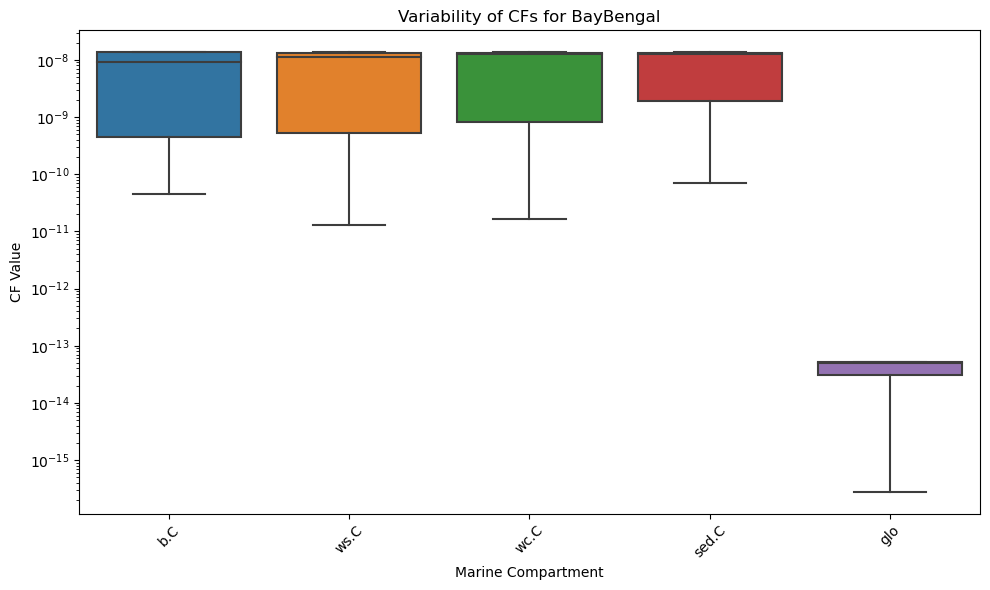

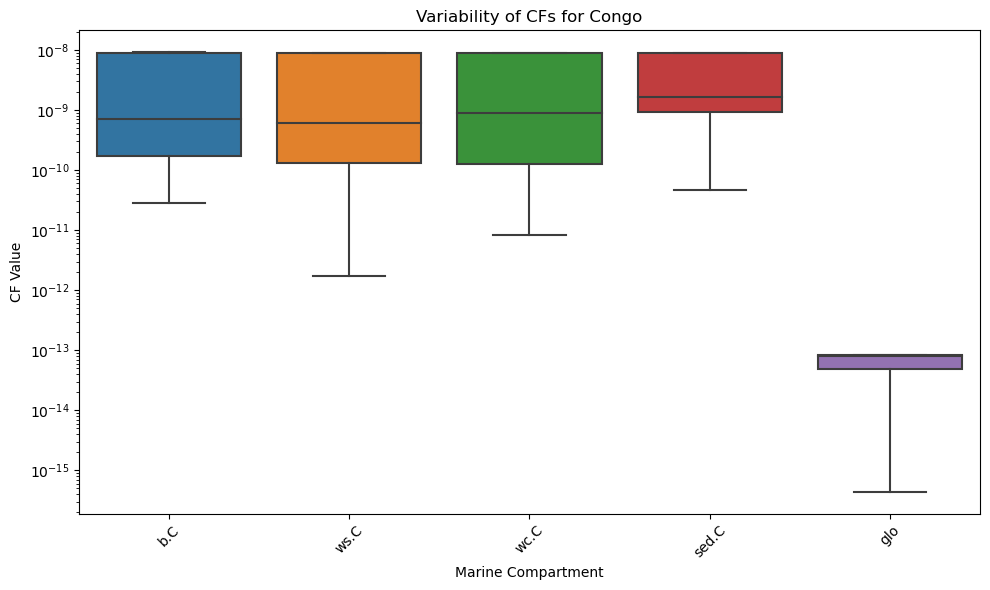

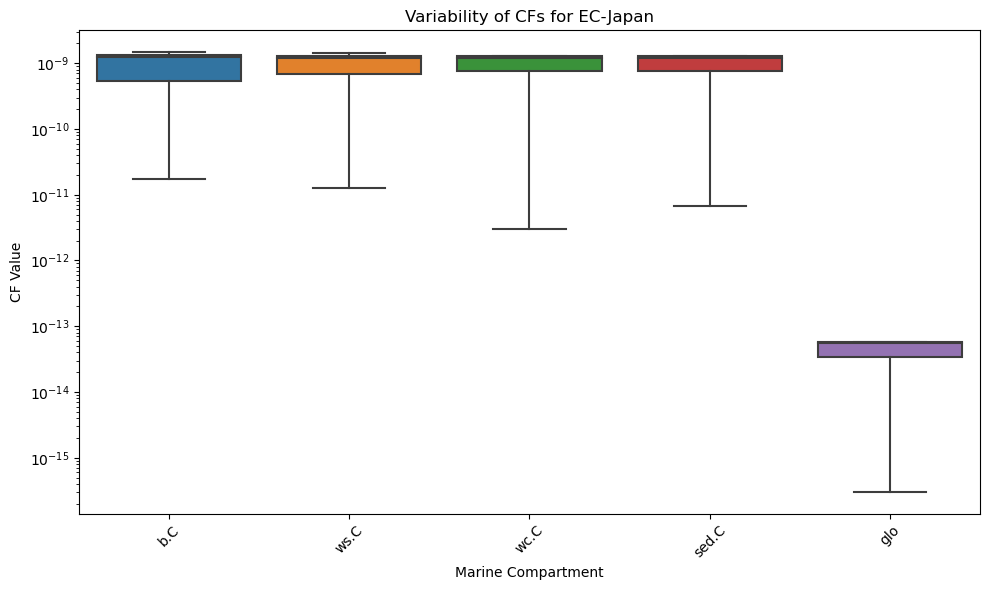

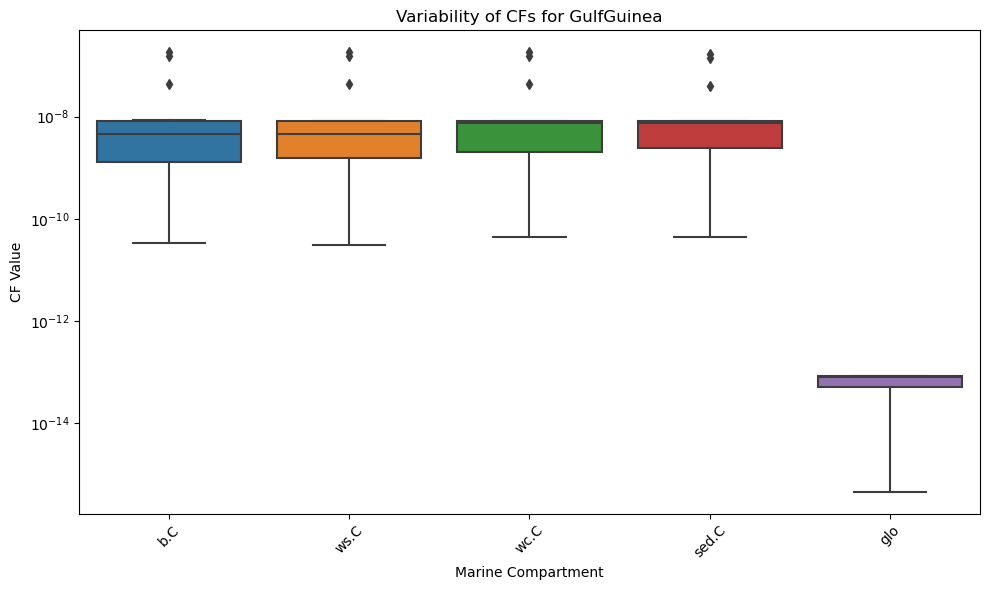

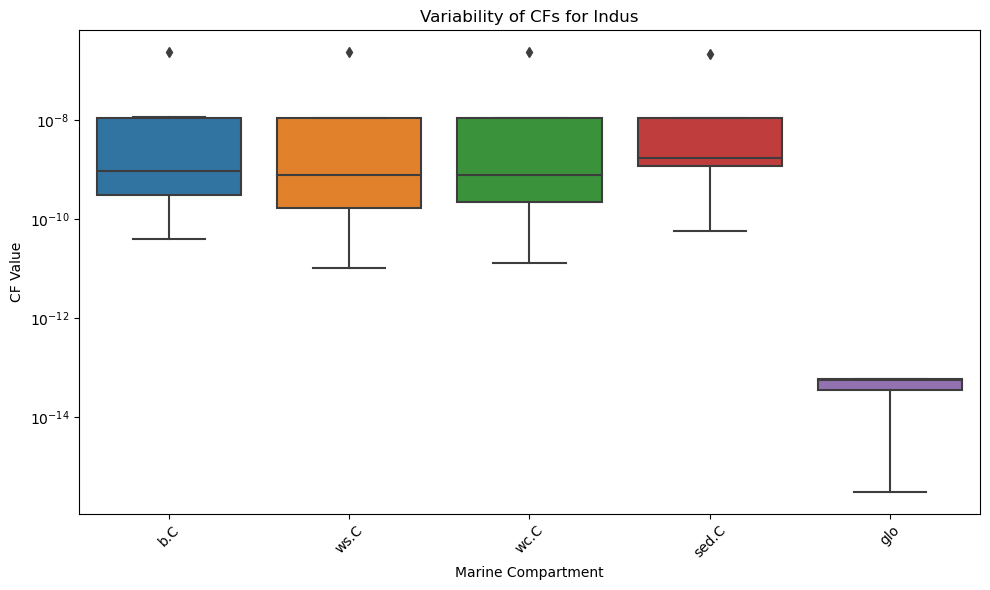

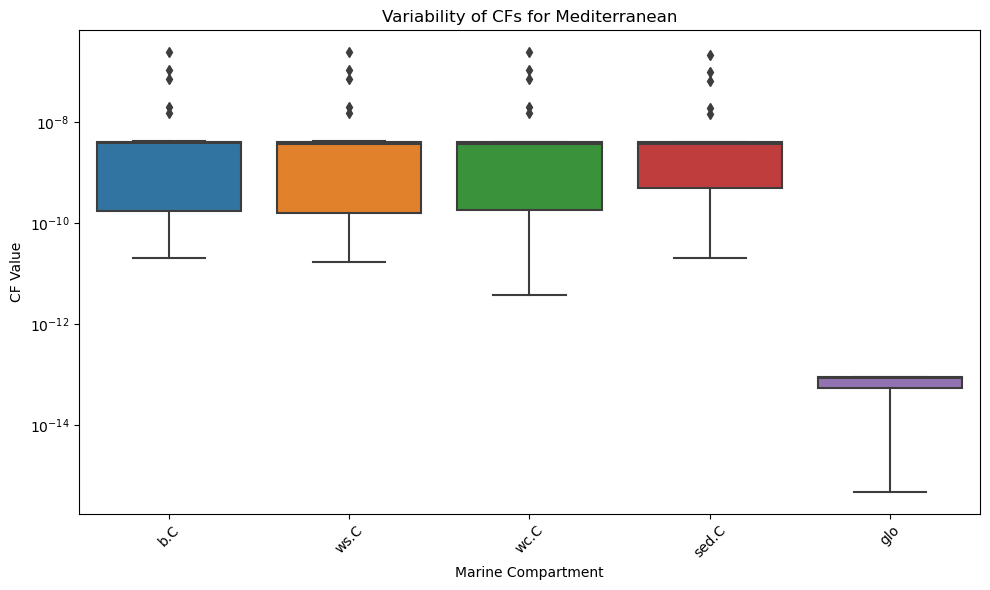

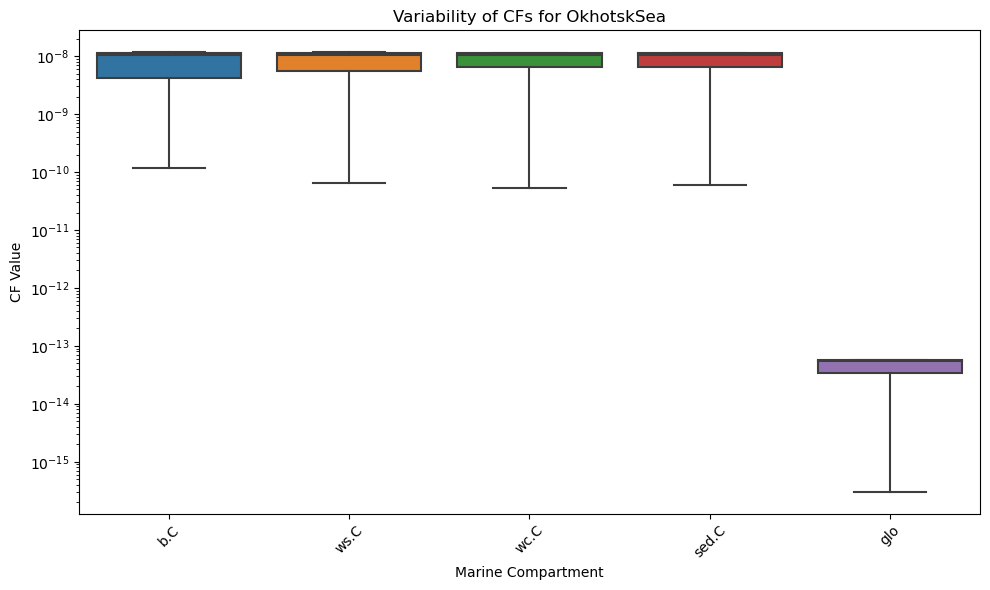

In [14]:
# For each region, plot the variability of each CFs linked to the physical properties of the particles

#  Initialize an empty list to collect data for plotting
plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in dict_CF_GLAM.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Create boxplots for each country
for country in df_plot['Country'].unique():
    df_country = df_plot[df_plot['Country'] == country]
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x="Compartment", 
        y="Value", 
        data=df_country
    )
    plt.yscale('log') # Set y-axis to logarithmic scale
    plt.title(f"Variability of CFs for {country}")
    plt.ylabel("CF Value")
    plt.xlabel("Marine Compartment")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

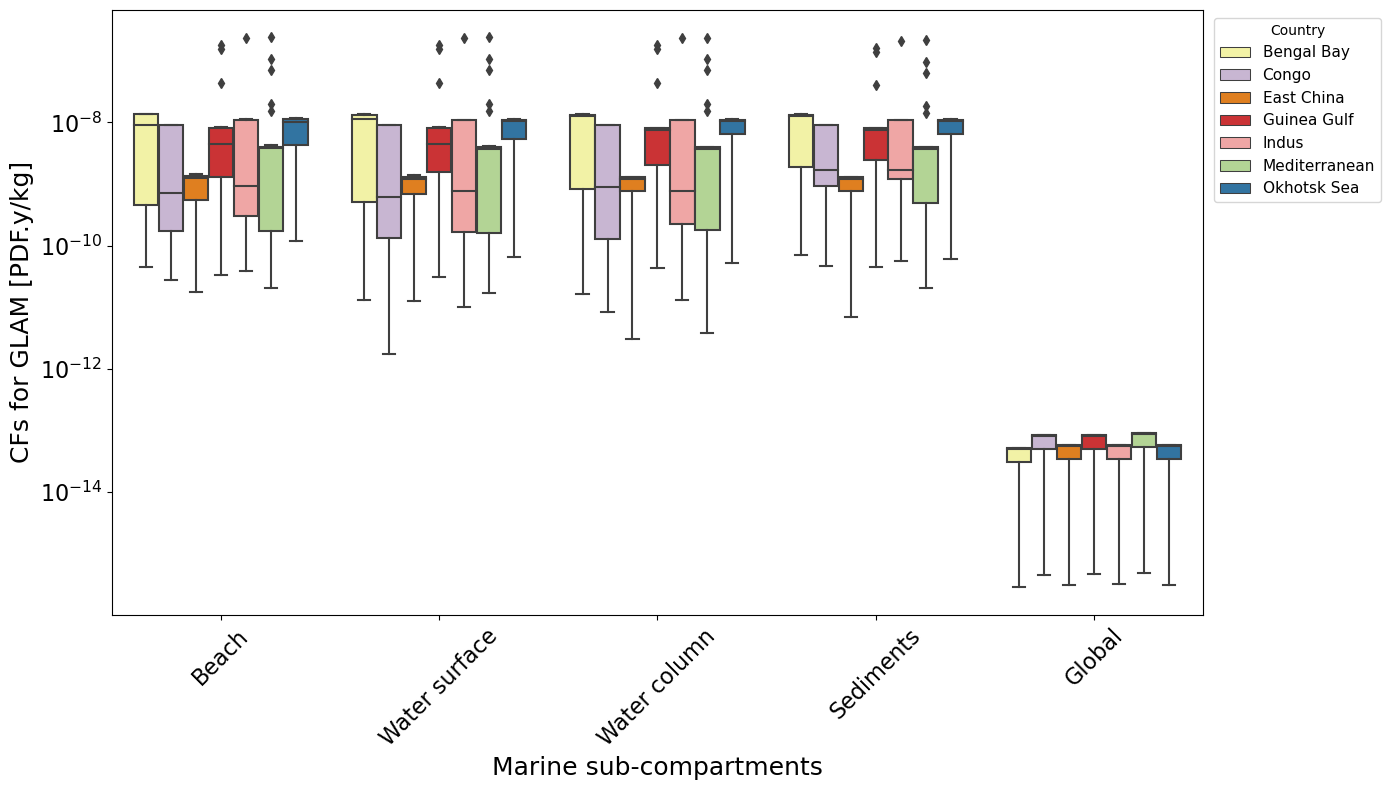

In [55]:
# Initialize an empty list to collect data for plotting

# Create a dictionary mapping countries to their respective colors
custom_palette = {"BayBengal": color1,"Congo": color2,"EC-Japan": color3,"GulfGuinea": color4,"Indus": color5,"Mediterranean": color6,"OkhotskSea": color7}

# Create a dictionary to rename the marine sub-compartments labels and the countries in the legend
compartment_rename = {'b.C': 'Beach', 'ws.C': 'Water surface', 'wc.C': 'Water column', 'sed.C': 'Sediments', 'glo': 'Global'}
country_rename = {'BayBengal': 'Bengal Bay', 'Congo': "Congo", 'EC-Japan': 'East China', 'GulfGuinea': 'Guinea Gulf', 'Indus': 'Indus',
                  "Mediterranean": 'Mediterranean', 'OkhotskSea': 'Okhotsk Sea'}

plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in dict_CF_GLAM.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Rename compartments on the x-axis
df_plot['Compartment'] = df_plot['Compartment'].map(compartment_rename)
df_plot["Country"] = df_plot["Country"].map(country_rename)

# Plot all countries in one graph with countries' results side by side
plt.figure(figsize=(14, 8))  # Adjust size to fit all data comfortably
sns.boxplot(
    x="Compartment", 
    y="Value", 
    hue="Country",  # Distinguish countries with color
    data=df_plot,
    palette="Paired_r",
    #whis=1000,  # Adjust whisker length
    showfliers=True  # Include outliers
)
plt.yscale('log')  # Logarithmic scale for y-axis
#plt.title("The variability of CFs with MP physical properties across countries of emissions", fontsize = 20)
plt.ylabel("CFs for GLAM [PDF.y/kg]", fontsize = 18)
plt.xlabel("Marine sub-compartments", fontsize = 18)
plt.xticks(rotation=45,fontsize = 16)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=16)
plt.legend(title="Country", loc="upper right", bbox_to_anchor=(1.17, 1), fontsize = 11)  # Adjust legend position
plt.tight_layout()

# Save the plot
#plt.savefig(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Figures\CF_GLAM_PolymerVariability.eps")

# Display the plot
plt.show()




In [ ]:
#df_plot.to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\df_plot\df_plot_GLAM_janvier.xlsx")

In [ ]:
# Identify outliers for each group (Compartment, Country)
outliers = []

# Group the data by "Compartment" and "Country"
for (compartment, country), group in df_plot.groupby(["Compartment", "Country"]):
    Q1 = group["Value"].quantile(0.25)
    Q3 = group["Value"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the outliers
    group_outliers = group[(group["Value"] < lower_bound) | (group["Value"] > upper_bound)]
    outliers.append(group_outliers)

# Combine all outliers into a single DataFrame
outliers_df = pd.concat(outliers)

#outliers_df.to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\GLAM\Outliers_GLAM.xlsx")

In [56]:
# Identify lower and upper whiskers
# Initialize a list to collect whisker data
whiskers = []

# Group the data by all relevant fields
for (compartment, country), group in df_plot.groupby(["Compartment", "Country"]):
    Q1 = group["Value"].quantile(0.25)
    Q3 = group["Value"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Compute whiskers
    lower_whisker = max(group["Value"].min(), lower_bound)
    upper_whisker = min(group["Value"].max(), upper_bound)

    # Attempt to find rows corresponding to the whisker values
    lower_whisker_row = group[group["Value"].apply(lambda x: abs(x - lower_whisker) < 1e-6)]
    upper_whisker_row = group[group["Value"].apply(lambda x: abs(x - upper_whisker) < 1e-6)]
    
    # Handle cases where no exact match is found
    if not lower_whisker_row.empty:
        lower_metadata = lower_whisker_row.iloc[0][["Polymer", "Size", "Shape"]].to_dict()
    else:
        lower_metadata = {"Polymer": None, "Size": None, "Shape": None}

    if not upper_whisker_row.empty:
        upper_metadata = upper_whisker_row.iloc[0][["Polymer", "Size", "Shape"]].to_dict()
    else:
        upper_metadata = {"Polymer": None, "Size": None, "Shape": None}

    # Store the whisker values along with their metadata
    whiskers.append({
        "Compartment": compartment,
        "Country": country,
        "Lower Whisker": lower_whisker,
        "Lower Whisker Polymer": lower_metadata["Polymer"],
        "Lower Whisker Size": lower_metadata["Size"],
        "Lower Whisker Shape": lower_metadata["Shape"],
        "Upper Whisker": upper_whisker,
        "Upper Whisker Polymer": upper_metadata["Polymer"],
        "Upper Whisker Size": upper_metadata["Size"],
        "Upper Whisker Shape": upper_metadata["Shape"],
        "Q1": Q1,
        "Q3": Q3
    })

# Convert to a DataFrame for better visualization
whiskers_df = pd.DataFrame(whiskers)

#whiskers_df.to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\GLAM\Whiskers_GLAM.xlsx")

### 6.1.2 IMPACT WORLD +

#### Midpoint

##### All polymers

In [ ]:
# Initialize an empty list to collect data for plotting
plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in dict_CF_IW_endpoint.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Create boxplots for each country
for country in df_plot['Country'].unique():
    df_country = df_plot[df_plot['Country'] == country]
    
    # Plot
    plt.figure(figsize=(10, 6))
    sns.boxplot(
        x="Compartment", 
        y="Value", 
        data=df_country,
        whis = 100,
        showfliers=True # Exclude (False) or include (True) outliers
    )
    plt.yscale('log')
    plt.title(f"Variability of CFs for {country}")
    plt.ylabel("CF Value")
    plt.xlabel("Marine Compartment")
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

In [ ]:
# Initialize an empty list to collect data for plotting

# Create a dictionary mapping countries to their respective colors
custom_palette = {"BayBengal": color1,"Congo": color2,"EC-Japan": color3,"GulfGuinea": color4,"Indus": color5,"Mediterranean": color6,"OkhotskSea": color7}

plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in dict_CF_IW_midpoint.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Plot all countries in one graph with countries' results side by side
plt.figure(figsize=(14, 8))  # Adjust size to fit all data comfortably
sns.boxplot(
    x="Compartment", 
    y="Value", 
    hue="Country",  # Distinguish countries with color
    data=df_plot,
    palette='Paired_r',
    whis=100,  # Adjust whisker length
    showfliers=True  # Include outliers
)
plt.yscale('log')  # Logarithmic scale for y-axis
plt.title("Variability of CFs across countries of emissions - V_USEtox", fontsize = 18)
plt.ylabel("CFs for IW+ [PAF.m3.y/kg]", fontsize = 14)
plt.xlabel("Marine sub-compartments", fontsize = 14)
plt.xticks(rotation=45,fontsize = 12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.legend(title="Country", loc="upper right", bbox_to_anchor=(1.15, 1))  # Adjust legend position
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
A = max({v.loc['SDF','b.C'] for k,v in dict_CF_IW_midpoint.items() if k[0] == 'OkhotskSea'})
{k:v for k,v in dict_CF_IW_midpoint.items() if (v.loc['SDF','b.C'] == A and k[0] == 'OkhotskSea')}

In [ ]:
# Identify outliers for each group (Compartment, Country)
outliers = []

# Group the data by "Compartment" and "Country"
for (compartment, country), group in df_plot.groupby(["Compartment", "Country"]):
    Q1 = group["Value"].quantile(0.25)
    Q3 = group["Value"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the outliers
    group_outliers = group[(group["Value"] < lower_bound) | (group["Value"] > upper_bound)]
    outliers.append(group_outliers)

# Combine all outliers into a single DataFrame
outliers_df = pd.concat(outliers)

# outliers_df.to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\Outliers_IW_Midpoint_Vreg.xlsx")

In [ ]:
# Identify lower and upper whiskers
# Initialize a list to collect whisker data
whiskers = []

# Group the data by all relevant fields
for (compartment, country), group in df_plot.groupby(["Compartment", "Country"]):
    Q1 = group["Value"].quantile(0.25)
    Q3 = group["Value"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Compute whiskers
    lower_whisker = max(group["Value"].min(), lower_bound)
    upper_whisker = min(group["Value"].max(), upper_bound)

    # Attempt to find rows corresponding to the whisker values
    lower_whisker_row = group[group["Value"].apply(lambda x: abs(x - lower_whisker) < 1e-6)]
    upper_whisker_row = group[group["Value"].apply(lambda x: abs(x - upper_whisker) < 1e-6)]
    
    # Handle cases where no exact match is found
    if not lower_whisker_row.empty:
        lower_metadata = lower_whisker_row.iloc[0][["Polymer", "Size", "Shape"]].to_dict()
    else:
        lower_metadata = {"Polymer": None, "Size": None, "Shape": None}

    if not upper_whisker_row.empty:
        upper_metadata = upper_whisker_row.iloc[0][["Polymer", "Size", "Shape"]].to_dict()
    else:
        upper_metadata = {"Polymer": None, "Size": None, "Shape": None}

    # Store the whisker values along with their metadata
    whiskers.append({
        "Compartment": compartment,
        "Country": country,
        "Lower Whisker": lower_whisker,
        "Lower Whisker Polymer": lower_metadata["Polymer"],
        "Lower Whisker Size": lower_metadata["Size"],
        "Lower Whisker Shape": lower_metadata["Shape"],
        "Upper Whisker": upper_whisker,
        "Upper Whisker Polymer": upper_metadata["Polymer"],
        "Upper Whisker Size": upper_metadata["Size"],
        "Upper Whisker Shape": upper_metadata["Shape"],
        "Q1": Q1,
        "Q3": Q3
    })

# Convert to a DataFrame for better visualization
whiskers_df = pd.DataFrame(whiskers)

#whiskers_df.to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\IW+\Midpoint\Whiskers_IW_Midpoint_Vreg.xlsx")

##### Based on shape

In [ ]:
# Copy the transfer file to avoid overwriting
transfer_shape = transfer.copy()

# Reset to remove the shape from the index
transfer_shape = transfer_shape.reset_index()


# Group dataframe by Shape_category
Sphere = transfer_shape[transfer_shape['Shape_all'] == "sphere"]
Fiber = transfer_shape[transfer_shape['Shape_all'] == "fiber"]


Sphere = Sphere.set_index(['Country_all','Polymer_all','Shape_all','Size_all'])
Fiber = Fiber.set_index(['Country_all','Polymer_all','Shape_all','Size_all'])

# 3. Extract results from dict_CF_IW_midpoint based on grouped indices
# For sphere group
sphere_IW_midpoint = {}
for idx in Sphere.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    sphere_IW_midpoint[idx] = dict_CF_IW_midpoint.get(idx, None)  # Get corresponding value from the dict

# For fiber group
fiber_IW_midpoint = {}
for idx in Fiber.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    fiber_IW_midpoint[idx] = dict_CF_IW_midpoint.get(idx, None)  # Get corresponding value from the dict

##### Based on density

In [ ]:
# Copy the transfer file to avoid overwriting
transfer_density = transfer.copy()

# Add a column to categorize densities
transfer_density['Density_category'] = transfer_density['Density_all'].apply(lambda x: 'Low' if x < 1.02 else 'High')

# Group dataframe by Density_category
low_density = transfer_density[transfer_density['Density_category'] == "Low"]
high_density = transfer_density[transfer_density['Density_category'] == "High"]

# 3. Extract results from dict_CF_IW_midpoint based on grouped indices
# For low-density group
low_density_IW_midpoint = {}
for idx in low_density.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    low_density_IW_midpoint[idx] = dict_CF_IW_midpoint.get(idx, None)  # Get corresponding value from the dict

# For high-density group
high_density_IW_midpoint = {}
for idx in high_density.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    high_density_IW_midpoint[idx] = dict_CF_IW_midpoint.get(idx, None)  # Get corresponding value from the dict

##### Based on size

In [ ]:
# Copy the transfer file to avoid overwriting
transfer_size = transfer.copy()

# Reset to remove the shape from the index
transfer_size = transfer_size.reset_index()

# Filter the data based on the size
Size_5000 = transfer_size[transfer_size['Size_all'] == 5000]
Size_1000 = transfer_size[transfer_size['Size_all'] == 1000]
Size_100 = transfer_size[transfer_size['Size_all'] == 100]
Size_10 = transfer_size[transfer_size['Size_all'] == 10]
Size_1 = transfer_size[transfer_size['Size_all'] == 1]

# Reset the multiindex
Size_5000 = Size_5000.set_index(['Country_all','Polymer_all','Shape_all','Size_all'])
Size_1000 = Size_1000.set_index(['Country_all','Polymer_all','Shape_all','Size_all'])
Size_100 = Size_100.set_index(['Country_all','Polymer_all','Shape_all','Size_all'])
Size_10 = Size_10.set_index(['Country_all','Polymer_all','Shape_all','Size_all'])
Size_1 = Size_1.set_index(['Country_all','Polymer_all','Shape_all','Size_all'])

# 3. Extract results from dict_CF_IW_midpoint based on grouped indices
# For sphere group
Size_5000_IW_midpoint = {}
for idx in Size_5000.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    Size_5000_IW_midpoint[idx] = dict_CF_IW_midpoint.get(idx, None)  # Get corresponding value from the dict

Size_1000_IW_midpoint = {}
for idx in Size_1000.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    Size_1000_IW_midpoint[idx] = dict_CF_IW_midpoint.get(idx, None)  # Get corresponding value from the dict

Size_100_IW_midpoint = {}
for idx in Size_100.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    Size_100_IW_midpoint[idx] = dict_CF_IW_midpoint.get(idx, None)  # Get corresponding value from the dict

Size_10_IW_midpoint = {}
for idx in Size_10.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    Size_10_IW_midpoint[idx] = dict_CF_IW_midpoint.get(idx, None)  # Get corresponding value from the dict

Size_1_IW_midpoint = {}
for idx in Size_1.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    Size_1_IW_midpoint[idx] = dict_CF_IW_midpoint.get(idx, None)  # Get corresponding value from the dict

#### Endpoint

##### All polymers

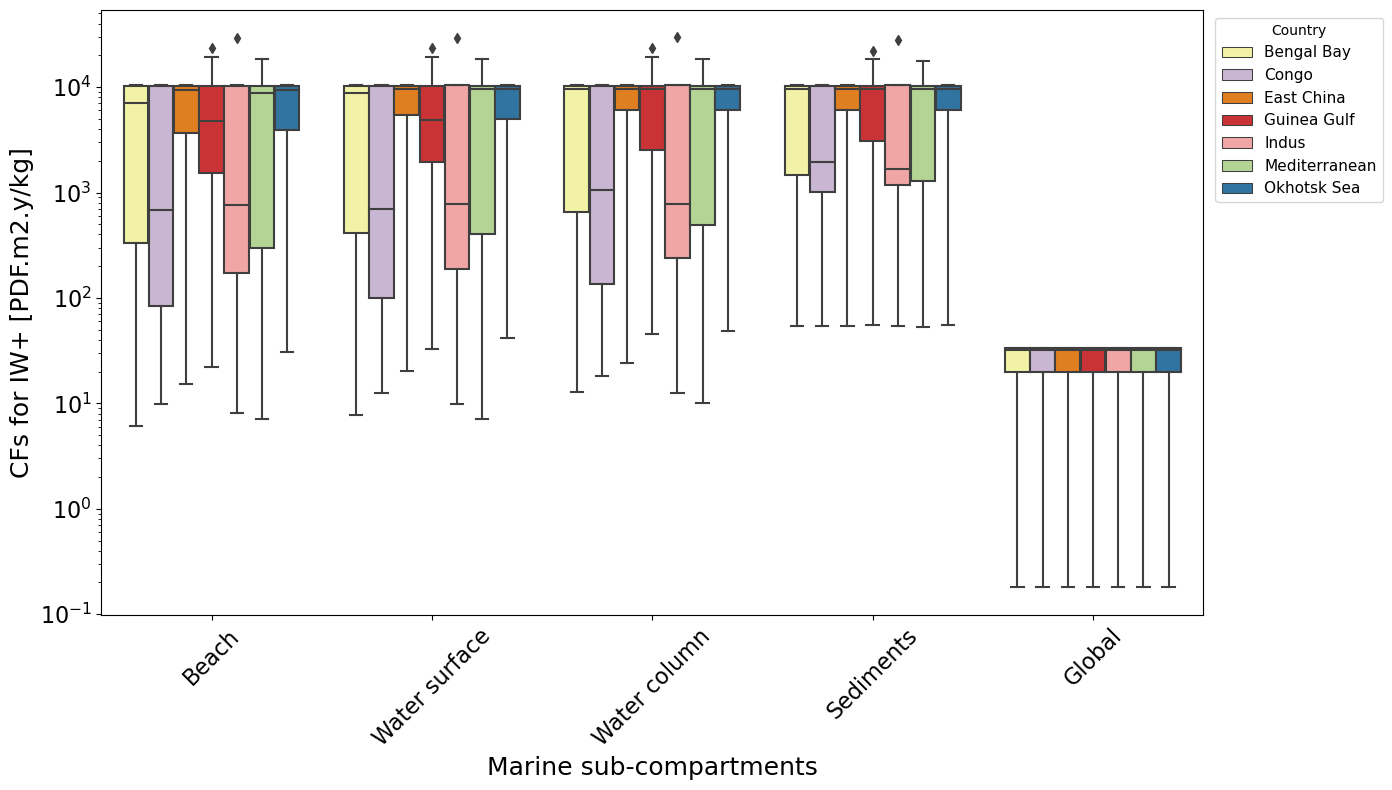

In [57]:
# Initialize an empty list to collect data for plotting

# Create a dictionary mapping countries to their respective colors
custom_palette = {"BayBengal": color1,"Congo": color2,"EC-Japan": color3,"GulfGuinea": color4,"Indus": color5,"Mediterranean": color6,"OkhotskSea": color7}

# Create a dictionary to rename the marine sub-compartments labels and the countries in the legend
compartment_rename = {'b.C': 'Beach', 'ws.C': 'Water surface', 'wc.C': 'Water column', 'sed.C': 'Sediments', 'glo': 'Global'}
country_rename = {'BayBengal': 'Bengal Bay', 'Congo': "Congo", 'EC-Japan': 'East China', 'GulfGuinea': 'Guinea Gulf', 'Indus': 'Indus',
                  "Mediterranean": 'Mediterranean', 'OkhotskSea': 'Okhotsk Sea'}

plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in dict_CF_IW_endpoint.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Rename compartments on the x-axis
df_plot['Compartment'] = df_plot['Compartment'].map(compartment_rename)
df_plot["Country"] = df_plot["Country"].map(country_rename)

# Plot all countries in one graph with countries' results side by side
plt.figure(figsize=(14, 8))  # Adjust size to fit all data comfortably
sns.boxplot(
    x="Compartment", 
    y="Value", 
    hue="Country",  # Distinguish countries with color
    data=df_plot,
    palette='Paired_r',
    #whis=1000,  # Adjust whisker length
    showfliers=True,  # Include outliers
    #dodge=True, # Leave space between the boxes
    #width = 1 # Leave space between the boxes
)
plt.yscale('log')  # Logarithmic scale for y-axis
#plt.title("Variability of CFs across countries of emissions", fontsize = 20)
plt.ylabel("CFs for IW+ [PDF.m2.y/kg]", fontsize = 18)
plt.xlabel("Marine sub-compartments", fontsize = 18)
plt.xticks(rotation=45,fontsize = 16)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=16)
plt.legend(title="Country", loc="upper right", bbox_to_anchor=(1.17, 1), fontsize = 11)  # Adjust legend position
plt.tight_layout()

# Save the plot
#plt.savefig(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Figures\CF_IW_endpoint_PolymerVariability.eps")

# Display the plot
plt.show()



In [ ]:
#df_plot.to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\df_plot\df_plot_IW_janvier.xlsx")

In [ ]:
# Identify outliers for each group (Compartment, Country)
outliers = []

# Group the data by "Compartment" and "Country"
for (compartment, country), group in df_plot.groupby(["Compartment", "Country"]):
    Q1 = group["Value"].quantile(0.25)
    Q3 = group["Value"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter out the outliers
    group_outliers = group[(group["Value"] < lower_bound) | (group["Value"] > upper_bound)]
    outliers.append(group_outliers)

# Combine all outliers into a single DataFrame
outliers_df = pd.concat(outliers)

#outliers_df.to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\IW+\Endpoint\Outliers_IW_Endpoint.xlsx")

In [ ]:
# Identify lower and upper whiskers
# Initialize a list to collect whisker data
whiskers = []

# Group the data by all relevant fields
for (compartment, country), group in df_plot.groupby(["Compartment", "Country"]):
    Q1 = group["Value"].quantile(0.25)
    Q3 = group["Value"].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Compute whiskers
    lower_whisker = max(group["Value"].min(), lower_bound)
    upper_whisker = min(group["Value"].max(), upper_bound)

    # Attempt to find rows corresponding to the whisker values
    lower_whisker_row = group[group["Value"].apply(lambda x: abs(x - lower_whisker) < 1e-6)]
    upper_whisker_row = group[group["Value"].apply(lambda x: abs(x - upper_whisker) < 1e-6)]
    
    # Handle cases where no exact match is found
    if not lower_whisker_row.empty:
        lower_metadata = lower_whisker_row.iloc[0][["Polymer", "Size", "Shape"]].to_dict()
    else:
        lower_metadata = {"Polymer": None, "Size": None, "Shape": None}

    if not upper_whisker_row.empty:
        upper_metadata = upper_whisker_row.iloc[0][["Polymer", "Size", "Shape"]].to_dict()
    else:
        upper_metadata = {"Polymer": None, "Size": None, "Shape": None}

    # Store the whisker values along with their metadata
    whiskers.append({
        "Compartment": compartment,
        "Country": country,
        "Lower Whisker": lower_whisker,
        "Lower Whisker Polymer": lower_metadata["Polymer"],
        "Lower Whisker Size": lower_metadata["Size"],
        "Lower Whisker Shape": lower_metadata["Shape"],
        "Upper Whisker": upper_whisker,
        "Upper Whisker Polymer": upper_metadata["Polymer"],
        "Upper Whisker Size": upper_metadata["Size"],
        "Upper Whisker Shape": upper_metadata["Shape"],
        "Q1": Q1,
        "Q3": Q3
    })

# Convert to a DataFrame for better visualization
whiskers_df = pd.DataFrame(whiskers)

#whiskers_df.to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\IW+\Endpoint\Whiskers_IW_Endpoint.xlsx")

##### Based on shape

In [ ]:
# 3. Extract results from dict_CF_IW_midpoint based on grouped indices
# For sphere group
sphere_IW_endpoint = {}
for idx in Sphere.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    sphere_IW_endpoint[idx] = dict_CF_IW_endpoint.get(idx, None)  # Get corresponding value from the dict

# For fiber group
fiber_IW_endpoint = {}
for idx in Fiber.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    fiber_IW_endpoint[idx] = dict_CF_IW_endpoint.get(idx, None)  # Get corresponding value from the dict

In [ ]:
# Initialize an empty list to collect data for plotting

# Create a dictionary mapping countries to their respective colors
custom_palette = {"BayBengal": color1,"Congo": color2,"EC-Japan": color3,"GulfGuinea": color4,"Indus": color5,"Mediterranean": color6,"OkhotskSea": color7}

plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in sphere_IW_endpoint.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Plot all countries in one graph with countries' results side by side
plt.figure(figsize=(14, 8))  # Adjust size to fit all data comfortably
sns.boxplot(
    x="Compartment", 
    y="Value", 
    hue="Country",  # Distinguish countries with color
    data=df_plot,
    palette='Paired_r',
    whis=100,  # Adjust whisker length
    showfliers=True,  # Include outliers
    #dodge=True, # Leave space between the boxes
    #width = 1 # Leave space between the boxes
)
plt.yscale('log')  # Logarithmic scale for y-axis
plt.title("Variability of CFs across countries of emissions - V_USEtox - Spheres", fontsize = 18)
plt.ylabel("CFs for IW+ [PDF.m2.y/kg]", fontsize = 14)
plt.xlabel("Marine sub-compartments", fontsize = 14)
plt.xticks(rotation=45,fontsize = 12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.legend(title="Country", loc="upper right", bbox_to_anchor=(1.15, 1))  # Adjust legend position
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
# Initialize an empty list to collect data for plotting

# Create a dictionary mapping countries to their respective colors
custom_palette = {"BayBengal": color1,"Congo": color2,"EC-Japan": color3,"GulfGuinea": color4,"Indus": color5,"Mediterranean": color6,"OkhotskSea": color7}

plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in fiber_IW_endpoint.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Plot all countries in one graph with countries' results side by side
plt.figure(figsize=(14, 8))  # Adjust size to fit all data comfortably
sns.boxplot(
    x="Compartment", 
    y="Value", 
    hue="Country",  # Distinguish countries with color
    data=df_plot,
    palette='Paired_r',
    whis=100,  # Adjust whisker length
    showfliers=True,  # Include outliers
    #dodge=True, # Leave space between the boxes
    #width = 1 # Leave space between the boxes
)
plt.yscale('log')  # Logarithmic scale for y-axis
plt.title("Variability of CFs across countries of emissions - V_USEtox - Fibers", fontsize = 18)
plt.ylabel("CFs for IW+ [PDF.m2.y/kg]", fontsize = 14)
plt.xlabel("Marine sub-compartments", fontsize = 14)
plt.xticks(rotation=45,fontsize = 12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.legend(title="Country", loc="upper right", bbox_to_anchor=(1.15, 1))  # Adjust legend position
plt.tight_layout()

# Display the plot
plt.show()


##### Based on density

In [ ]:
# 3. Extract results from dict_CF_IW_endpoint based on grouped indices
# For low-density group
low_density_IW_endpoint = {}
for idx in low_density.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    low_density_IW_endpoint[idx] = dict_CF_IW_endpoint.get(idx, None)  # Get corresponding value from the dict

# For high-density group
high_density_IW_endpoint = {}
for idx in high_density.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    high_density_IW_endpoint[idx] = dict_CF_IW_endpoint.get(idx, None)  # Get corresponding value from the dict

In [ ]:
# Initialize an empty list to collect data for plotting

# Create a dictionary mapping countries to their respective colors
custom_palette = {"BayBengal": color1,"Congo": color2,"EC-Japan": color3,"GulfGuinea": color4,"Indus": color5,"Mediterranean": color6,"OkhotskSea": color7}

plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in low_density_IW_endpoint.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Plot all countries in one graph with countries' results side by side
plt.figure(figsize=(14, 8))  # Adjust size to fit all data comfortably
sns.boxplot(
    x="Compartment", 
    y="Value", 
    hue="Country",  # Distinguish countries with color
    data=df_plot,
    palette='Paired_r',
    whis=100,  # Adjust whisker length
    showfliers=True,  # Include outliers
    #dodge=True, # Leave space between the boxes
    #width = 1 # Leave space between the boxes
)
plt.yscale('log')  # Logarithmic scale for y-axis
plt.title("Variability of CFs across countries of emissions - V_Regionalized - Low density particles", fontsize = 18)
plt.ylabel("CFs for IW+ [PDF.m2.y/kg]", fontsize = 14)
plt.xlabel("Marine sub-compartments", fontsize = 14)
plt.xticks(rotation=45,fontsize = 12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.legend(title="Country", loc="upper right", bbox_to_anchor=(1.15, 1))  # Adjust legend position
plt.tight_layout()

# Display the plot
plt.show()


In [ ]:
# Initialize an empty list to collect data for plotting

# Create a dictionary mapping countries to their respective colors
custom_palette = {"BayBengal": color1,"Congo": color2,"EC-Japan": color3,"GulfGuinea": color4,"Indus": color5,"Mediterranean": color6,"OkhotskSea": color7}

plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in high_density_IW_endpoint.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Plot all countries in one graph with countries' results side by side
plt.figure(figsize=(14, 8))  # Adjust size to fit all data comfortably
sns.boxplot(
    x="Compartment", 
    y="Value", 
    hue="Country",  # Distinguish countries with color
    data=df_plot,
    palette='Paired_r',
    whis=100,  # Adjust whisker length
    showfliers=True,  # Include outliers
    #dodge=True, # Leave space between the boxes
    #width = 1 # Leave space between the boxes
)
plt.yscale('log')  # Logarithmic scale for y-axis
plt.title("Variability of CFs across countries of emissions - V_Regionalized - High density particles", fontsize = 18)
plt.ylabel("CFs for IW+ [PDF.m2.y/kg]", fontsize = 14)
plt.xlabel("Marine sub-compartments", fontsize = 14)
plt.xticks(rotation=45,fontsize = 12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.legend(title="Country", loc="upper right", bbox_to_anchor=(1.15, 1))  # Adjust legend position
plt.tight_layout()

# Display the plot
plt.show()


##### Based on size

In [ ]:
# 3. Extract results from dict_CF_IW_midpoint based on grouped indices
# For sphere group
Size_5000_IW_endpoint = {}
for idx in Size_5000.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    Size_5000_IW_endpoint[idx] = dict_CF_IW_endpoint.get(idx, None)  # Get corresponding value from the dict

Size_1000_IW_endpoint = {}
for idx in Size_1000.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    Size_1000_IW_endpoint[idx] = dict_CF_IW_endpoint.get(idx, None)  # Get corresponding value from the dict

Size_100_IW_endpoint = {}
for idx in Size_100.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    Size_100_IW_endpoint[idx] = dict_CF_IW_endpoint.get(idx, None)  # Get corresponding value from the dict

Size_10_IW_endpoint = {}
for idx in Size_10.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    Size_10_IW_endpoint[idx] = dict_CF_IW_endpoint.get(idx, None)  # Get corresponding value from the dict

Size_1_IW_endpoint = {}
for idx in Size_1.index:  # idx is a tuple (Country_all, Polymer_all, Shape_all, Size_all)
    Size_1_IW_endpoint[idx] = dict_CF_IW_endpoint.get(idx, None)  # Get corresponding value from the dict

In [ ]:
# Initialize an empty list to collect data for plotting

# Create a dictionary mapping countries to their respective colors
custom_palette = {"BayBengal": color1,"Congo": color2,"EC-Japan": color3,"GulfGuinea": color4,"Indus": color5,"Mediterranean": color6,"OkhotskSea": color7}

plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in Size_1_IW_endpoint.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Plot all countries in one graph with countries' results side by side
plt.figure(figsize=(14, 8))  # Adjust size to fit all data comfortably
sns.boxplot(
    x="Compartment", 
    y="Value", 
    hue="Country",  # Distinguish countries with color
    data=df_plot,
    palette='Paired_r',
    #whis=100,  # Adjust whisker length
    showfliers=True,  # Include outliers
    #dodge=True, # Leave space between the boxes
    #width = 1 # Leave space between the boxes
)
plt.yscale('log')  # Logarithmic scale for y-axis
plt.title("Variability of CFs across countries of emissions - V_Regionalized - 1 micrometer", fontsize = 18)
plt.ylabel("CFs for IW+ [PDF.m2.y/kg]", fontsize = 14)
plt.xlabel("Marine sub-compartments", fontsize = 14)
plt.xticks(rotation=45,fontsize = 12)  # Rotate x-axis labels for better readability
plt.yticks(fontsize=12)
plt.legend(title="Country", loc="upper right", bbox_to_anchor=(1.15, 1))  # Adjust legend position
plt.tight_layout()

# Display the plot
plt.show()


## 6.2 Regionalization variability

### IW+

#### For each polymer

#### For fibers

C:\Users\10User\AppData\Local\Temp\ipykernel_5296\504096543.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fiber['Compartment'] = pd.Categorical(df_fiber['Compartment'], categories=categories, ordered=True)
C:\Users\10User\AppData\Local\Temp\ipykernel_5296\504096543.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sphere['Compartment'] = pd.Categorical(df_sphere['Compartment'], categories=categories, ordered=True)


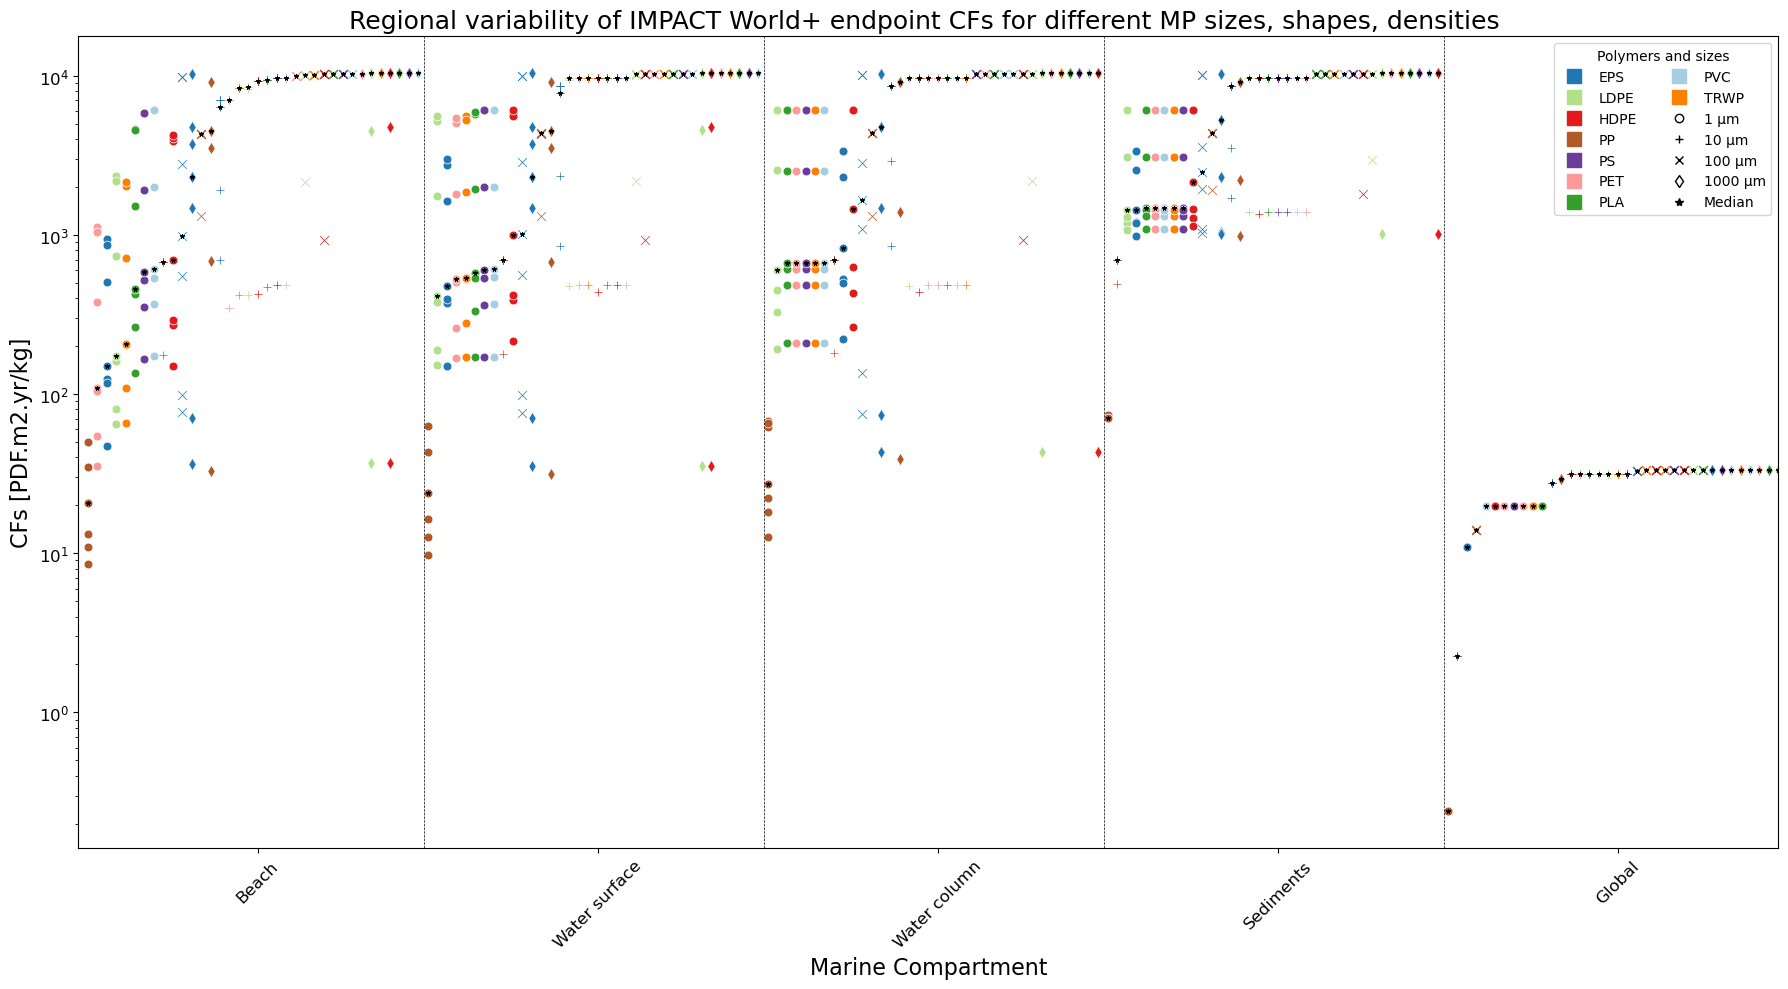

In [58]:
from matplotlib.lines import Line2D

# Initialize an empty list to collect data for plotting
plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in dict_CF_IW_endpoint.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Separate sphere and fiber
df_sphere = df_plot[df_plot['Shape'] == 'sphere']
df_fiber = df_plot[df_plot['Shape'] == 'fiber']

categories = ['b.C', 'ws.C', 'wc.C', 'sed.C', 'glo']
df_fiber['Compartment'] = pd.Categorical(df_fiber['Compartment'], categories=categories, ordered=True)
df_sphere['Compartment'] = pd.Categorical(df_sphere['Compartment'], categories=categories, ordered=True)
category_positions = {cat: idx for idx, cat in enumerate(categories)}


# Set the figure size
plt.figure(figsize=(20, 10)) #, dpi = 800)

# Get the medians
fiber_medians = (df_fiber.groupby(['Compartment', 'Polymer', 'Size'])['Value'].median().reset_index())

# Sort the medians by increasing order
fiber_medians_sorted = fiber_medians.sort_values(by='Value', ascending=True).reset_index(drop=True)

# Add a column for shifted position for medians
fiber_medians_sorted['Shifted_Position'] = fiber_medians_sorted['Compartment'].map(category_positions).astype(float)

# Add the corresponding median values to df_fiber
# Merge df_fiber with fiber_medians_sorted to get the median for each data point
df_fiber = df_fiber.merge(fiber_medians_sorted[['Polymer', 'Size', 'Compartment', 'Value']], on=['Polymer', 'Size', 'Compartment'], 
                          suffixes=('', '_median'))

# Sort df_fiber based on the corresponding median value
df_fiber_sorted = df_fiber.sort_values(by='Value_median', ascending=True).reset_index(drop=True)

df_beach = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'b.C'].copy()
df_surface = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'ws.C'].copy()
df_column = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'wc.C'].copy()
df_sediment = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'sed.C'].copy()
df_global = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'glo'].copy()

# To plot the fibers
i = 0

# 7 because 7 regions, len(df_beach) but could have been any other comaprtment
for ix in range(0, len(df_beach), 7):
    # extract polymers for each df
    poly_beach = df_beach.iloc[ix, df_beach.columns.get_loc('Polymer')]
    poly_surface = df_surface.iloc[ix, df_surface.columns.get_loc('Polymer')]
    poly_column = df_column.iloc[ix, df_column.columns.get_loc('Polymer')]
    poly_sediment = df_sediment.iloc[ix, df_sediment.columns.get_loc('Polymer')]
    poly_global = df_global.iloc[ix, df_global.columns.get_loc('Polymer')]
    # extract sizes for each df
    size_beach = df_beach.iloc[ix, df_beach.columns.get_loc('Size')]
    size_surface = df_surface.iloc[ix, df_surface.columns.get_loc('Size')]
    size_column = df_column.iloc[ix, df_column.columns.get_loc('Size')]
    size_sediment = df_sediment.iloc[ix, df_sediment.columns.get_loc('Size')]
    size_global = df_global.iloc[ix, df_global.columns.get_loc('Size')]

    offset = (i * (1/(len([1, 10, 100, 1000]) * len(['EPS', 'LDPE', 'HDPE', 'PP', 'PS','PET','PLA','PVC', 'TRWP']))))
    
    df_beach['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_surface['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_column['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_sediment['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_global['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    
    # -------------- Create the scater plotplot for fiber on beach --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_beach == 1:
        symb = 'o'
    elif size_beach == 10:
        symb = '+'
    elif size_beach == 100:
        symb = 'x'
    elif size_beach == 1000:
        symb = 'd'

    # values 
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_beach.loc[df_beach['Polymer'] == poly_beach].loc[df_beach['Size'] == size_beach], 
        color = poly_colors.get(poly_beach),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_beach.loc[df_beach['Polymer'] == poly_beach].loc[df_beach['Size'] == size_beach], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    plt.xlim(left=min(df_beach['Shifted_Position']) - 0,  # Adding space on the left
        right=max(df_beach['Shifted_Position']) + 3)  # Adding space on the right

    # -------------- Create the scaterplot for fiber on water surface --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_surface == 1:
        symb = 'o'
    elif size_surface == 10:
        symb = '+'
    elif size_surface == 100:
        symb = 'x'
    elif size_surface == 1000:
        symb = 'd'
    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_surface.loc[df_surface['Polymer'] == poly_surface].loc[df_surface['Size'] == size_surface], 
        color = poly_colors.get(poly_surface),
        marker = symb,
        s= 40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_surface.loc[df_surface['Polymer'] == poly_surface].loc[df_surface['Size'] == size_surface], 
        color = 'black',
        edgecolor='black',
        marker = '*',
        s=10
    )
    plt.xlim(left=min(df_surface['Shifted_Position']) - 3,  # Adding space on the left
        right=max(df_surface['Shifted_Position']) + 3)  # Adding space on the right

    
    # -------------- Create the scatterplot for fiber on water column --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_column == 1:
        symb = 'o'
    elif size_column == 10:
        symb = '+'
    elif size_column == 100:
        symb = 'x'
    elif size_column == 1000:
        symb = 'd'
    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_column.loc[df_column['Polymer'] == poly_column].loc[df_column['Size'] == size_column], 
        color = poly_colors.get(poly_column),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_column.loc[df_column['Polymer'] == poly_column].loc[df_column['Size'] == size_column], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    
    # -------------- Create the scatterplot for fiber on sediments --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_sediment == 1:
        symb = 'o'
    elif size_sediment == 10:
        symb = '+'
    elif size_sediment == 100:
        symb = 'x'
    elif size_sediment == 1000:
        symb = 'd'
    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_sediment.loc[df_sediment['Polymer'] == poly_sediment].loc[df_sediment['Size'] == size_sediment], 
        color = poly_colors.get(poly_sediment),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_sediment.loc[df_sediment['Polymer'] == poly_sediment].loc[df_sediment['Size'] == size_sediment], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    
    # -------------- Create the scatterplot for fiber on global --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_global == 1:
        symb = 'o'
    elif size_global == 10:
        symb = '+'
    elif size_global == 100:
        symb = 'x'
    elif size_global == 1000:
        symb = 'd'

    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_global.loc[df_global['Polymer'] == poly_global].loc[df_global['Size'] == size_global], 
        color = poly_colors.get(poly_global),
        marker = symb,
        s = 40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_global.loc[df_global['Polymer'] == poly_global].loc[df_global['Size'] == size_global],  
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )

    i += 1

plt.xlim(left=min(df_global['Shifted_Position']) - 5,  # Adding space on the left
        right=max(df_global['Shifted_Position']) + 0)  # Adding space on the right

plt.axvline(0.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(1.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(2.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(3.99, color="k", linestyle="dashed", linewidth = 0.5)


# Log scale for the y-axis
plt.yscale('log')

# Titles and labels
plt.title("Regional variability of IMPACT World+ endpoint CFs for different MP sizes, shapes, densities ", fontsize=18)
plt.ylabel("CFs [PDF.m2.yr/kg]", fontsize=16)
plt.xlabel("Marine Compartment", fontsize=16)

# Rotate x-axis labels for better readability
custom_labels = ['Beach', 'Water surface', 'Water column', 'Sediments', 'Global']
plt.xticks(rotation=45, fontsize=12, ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=custom_labels)

plt.yticks(fontsize=12)

# Legend
legend_elements_polymers = [
    Line2D([0], [0], color='#1F78B4', marker = 's', linestyle='', markersize=10, label='EPS'),
    Line2D([0], [0], color='#B2DF8A', marker = 's', linestyle='', markersize=10, label='LDPE'),
    Line2D([0], [0], color='#E31A1C', marker = 's', linestyle='', markersize=10, label='HDPE'),
    Line2D([0], [0], color='#B15928', marker = 's', linestyle='', markersize=10, label='PP'),
    Line2D([0], [0], color='#6A3D9A', marker = 's', linestyle='', markersize=10, label='PS'),
    Line2D([0], [0], color='#FB9A99', marker = 's', linestyle='', markersize=10, label='PET'),
    Line2D([0], [0], color='#33A02C', marker = 's', linestyle='', markersize=10, label='PLA'),
    Line2D([0], [0], color='#A6CEE3', marker = 's', linestyle='', markersize=10, label='PVC'),
    Line2D([0], [0], color='#FF7F00', marker = 's', linestyle='', markersize=10, label='TRWP'),
]

legend_elements_size = [
    Line2D([0], [0], marker='o', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='1 µm'),
    Line2D([0], [0], marker='+', markeredgecolor = 'Black', linestyle='', markersize=6, label='10 µm'),
    Line2D([0], [0], marker='x', markeredgecolor = 'Black', linestyle='', markersize=6, label='100 µm'),
    Line2D([0], [0], marker='d', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='1000 µm'),
    Line2D([0], [0], marker='*', markeredgecolor = 'Black', markerfacecolor='black', linestyle='', markersize=6, label='Median'),

]

legend_elements = legend_elements_polymers + legend_elements_size

plt.legend(handles=legend_elements, title="Polymers and sizes", loc="upper right", ncol = 2)  # Adjust legend position

# Adjust the layout for better spacing
plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.95)  # Fine-tune these values

plt.savefig(r'C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Figures\PPVar_Reg_IW+.pdf')

# Show the plot
plt.show()


In [ ]:
#df_plot.to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\df_plot\df_plot_fiber_IW_January.xlsx")

In [ ]:
df_fiber.loc[df_fiber.loc[df_fiber.loc[:,'Polymer'] == 'EPS'].loc[df_fiber.loc[:,'Size'] == 1].loc[df_fiber.loc[:,'Compartment'] == 'ws.C'].Value.idxmax()]

In [ ]:
df_sphere.loc[df_sphere.loc[df_sphere.loc[:,'Polymer'] == 'LDPE'].loc[df_sphere.loc[:,'Size'] == 1].loc[df_sphere.loc[:,'Compartment'] == 'ws.C'].Value.idxmin()]

In [ ]:
df_sphere.loc[df_sphere.loc[:,'Polymer'] == 'HDPE'].loc[df_sphere.loc[:,'Size'] == 1000].loc[df_sphere.loc[:,'Compartment'] == 'ws.C']

#### For spheres

C:\Users\10User\AppData\Local\Temp\ipykernel_5296\747425587.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fiber['Compartment'] = pd.Categorical(df_fiber['Compartment'], categories=categories, ordered=True)
C:\Users\10User\AppData\Local\Temp\ipykernel_5296\747425587.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sphere['Compartment'] = pd.Categorical(df_sphere['Compartment'], categories=categories, ordered=True)


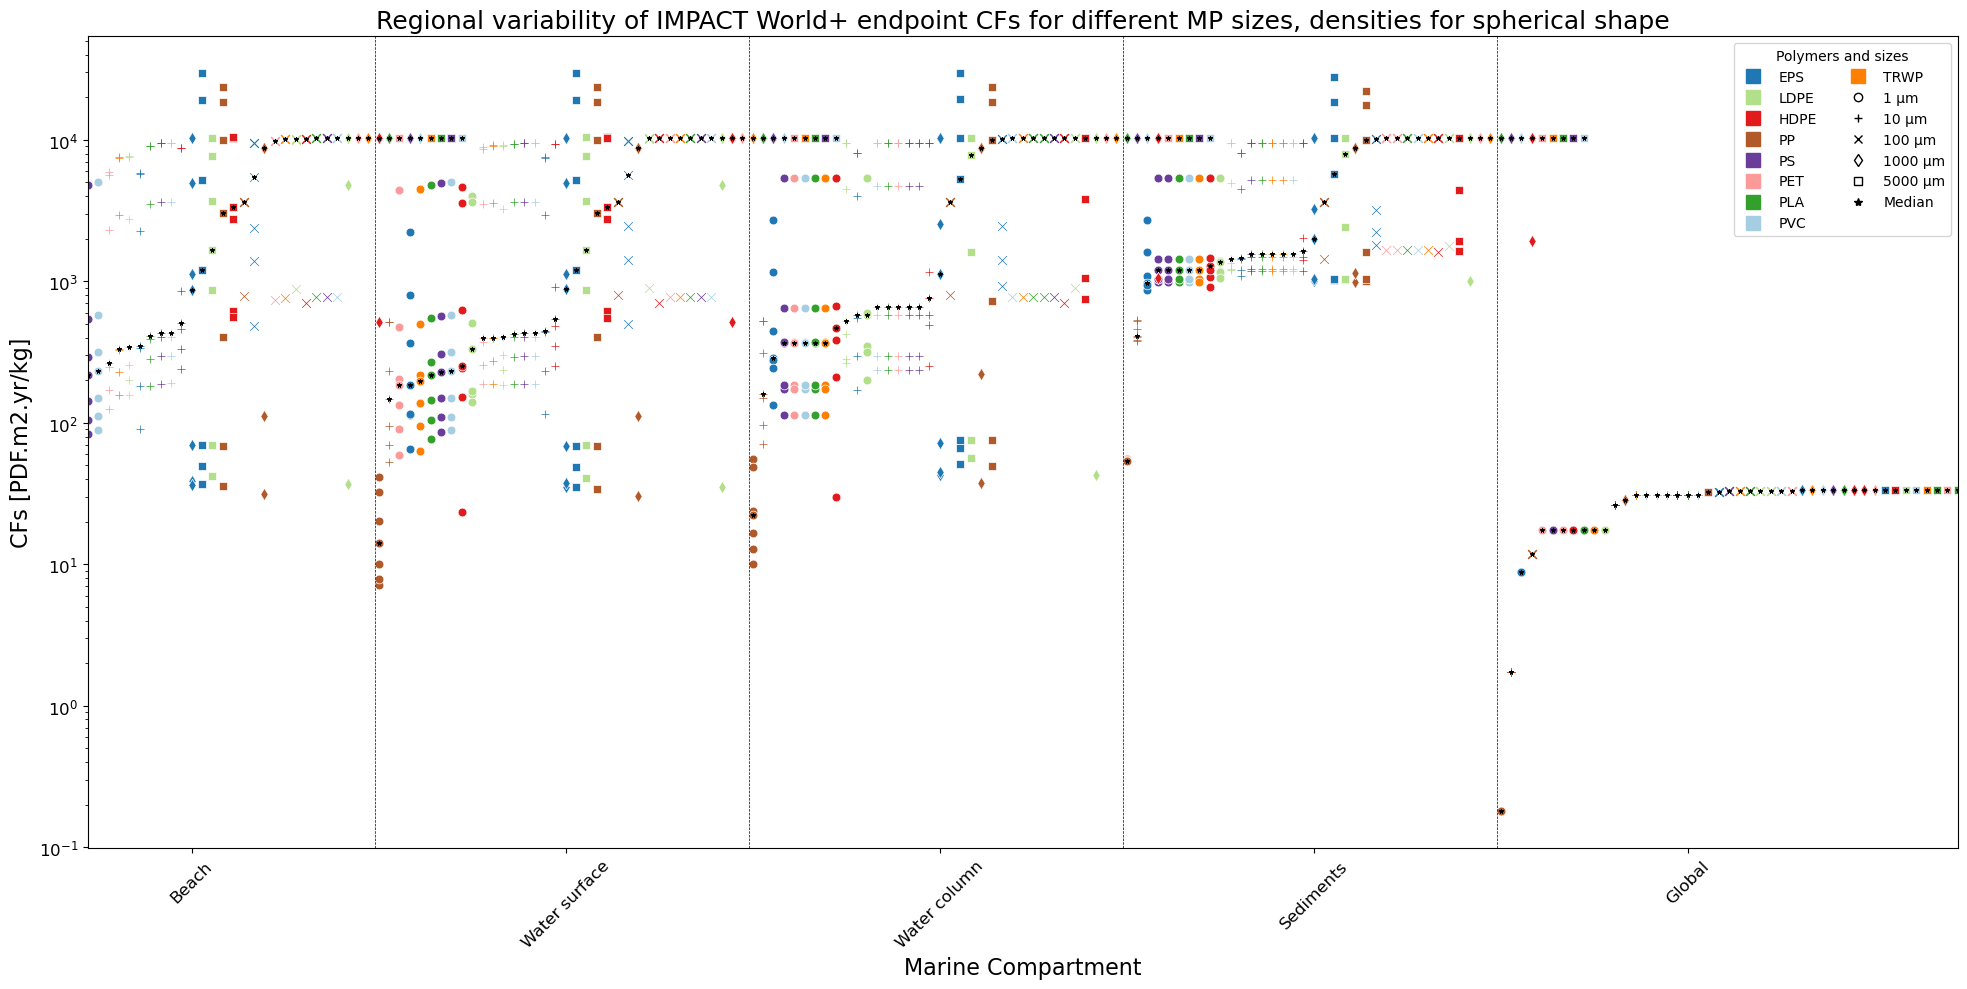

In [59]:
from matplotlib.lines import Line2D

# Initialize an empty list to collect data for plotting
plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in dict_CF_IW_endpoint.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Separate sphere and fiber
df_sphere = df_plot[df_plot['Shape'] == 'sphere']
df_fiber = df_plot[df_plot['Shape'] == 'fiber']

categories = ['b.C', 'ws.C', 'wc.C', 'sed.C', 'glo']
df_fiber['Compartment'] = pd.Categorical(df_fiber['Compartment'], categories=categories, ordered=True)
df_sphere['Compartment'] = pd.Categorical(df_sphere['Compartment'], categories=categories, ordered=True)
category_positions = {cat: idx for idx, cat in enumerate(categories)}


# Set the figure size
plt.figure(figsize=(22, 10)) #, dpi = 800)

# Get the medians
sphere_medians = (df_sphere.groupby(['Compartment', 'Polymer', 'Size'])['Value'].median().reset_index())

# Sort the medians by increasing order
sphere_median_sorted = sphere_medians.sort_values(by='Value', ascending=True).reset_index(drop=True)

# Add a column for shifted position for medians
sphere_median_sorted['Shifted_Position'] = sphere_median_sorted['Compartment'].map(category_positions).astype(float)

# Add the corresponding median values to df_fiber
# Merge df_fiber with fiber_medians_sorted to get the median for each data point
df_sphere = df_sphere.merge(sphere_median_sorted[['Polymer', 'Size', 'Compartment', 'Value']], on=['Polymer', 'Size', 'Compartment'], 
                          suffixes=('', '_median'))

# Sort df_fiber based on the corresponding median value
df_sphere_sorted = df_sphere.sort_values(by='Value_median', ascending=True).reset_index(drop=True)

df_beach = df_sphere_sorted.loc[df_sphere_sorted.loc[:,'Compartment'] == 'b.C'].copy()
df_surface = df_sphere_sorted.loc[df_sphere_sorted.loc[:,'Compartment'] == 'ws.C'].copy()
df_column = df_sphere_sorted.loc[df_sphere_sorted.loc[:,'Compartment'] == 'wc.C'].copy()
df_sediment = df_sphere_sorted.loc[df_sphere_sorted.loc[:,'Compartment'] == 'sed.C'].copy()
df_global = df_sphere_sorted.loc[df_sphere_sorted.loc[:,'Compartment'] == 'glo'].copy()

# To plot the spheres
i = 0

# 7 because 7 regions, len(df_beach) but could have been any other comaprtment
for ix in range(0, len(df_beach), 7):
    # extract polymers for each df
    poly_beach = df_beach.iloc[ix, df_beach.columns.get_loc('Polymer')]
    poly_surface = df_surface.iloc[ix, df_surface.columns.get_loc('Polymer')]
    poly_column = df_column.iloc[ix, df_column.columns.get_loc('Polymer')]
    poly_sediment = df_sediment.iloc[ix, df_sediment.columns.get_loc('Polymer')]
    poly_global = df_global.iloc[ix, df_global.columns.get_loc('Polymer')]
    # extract sizes for each df
    size_beach = df_beach.iloc[ix, df_beach.columns.get_loc('Size')]
    size_surface = df_surface.iloc[ix, df_surface.columns.get_loc('Size')]
    size_column = df_column.iloc[ix, df_column.columns.get_loc('Size')]
    size_sediment = df_sediment.iloc[ix, df_sediment.columns.get_loc('Size')]
    size_global = df_global.iloc[ix, df_global.columns.get_loc('Size')]

    offset = (i * (1/(len([1, 10, 100, 1000]) * len(['EPS', 'LDPE', 'HDPE', 'PP', 'PS','PET','PLA','PVC', 'TRWP']))))
    
    df_beach['Shifted_Position'] = (df_sphere_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_surface['Shifted_Position'] = (df_sphere_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_column['Shifted_Position'] = (df_sphere_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_sediment['Shifted_Position'] = (df_sphere_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_global['Shifted_Position'] = (df_sphere_sorted['Compartment'].map(category_positions).astype(float) + offset)
    
    # -------------- Create the scater plotplot for fiber on beach --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_beach == 1:
        symb = 'o'
    elif size_beach == 10:
        symb = '+'
    elif size_beach == 100:
        symb = 'x'
    elif size_beach == 1000:
        symb = 'd'
    elif size_beach == 5000:
        symb = 's'

    # values 
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_beach.loc[df_beach['Polymer'] == poly_beach].loc[df_beach['Size'] == size_beach], 
        color = poly_colors.get(poly_beach),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_beach.loc[df_beach['Polymer'] == poly_beach].loc[df_beach['Size'] == size_beach], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    plt.xlim(left=min(df_beach['Shifted_Position']) - 0,  # Adding space on the left
        right=max(df_beach['Shifted_Position']) + 3)  # Adding space on the right

    # -------------- Create the scaterplot for fiber on water surface --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_surface == 1:
        symb = 'o'
    elif size_surface == 10:
        symb = '+'
    elif size_surface == 100:
        symb = 'x'
    elif size_surface == 1000:
        symb = 'd'
    elif size_surface == 5000:
        symb = 's'

    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_surface.loc[df_surface['Polymer'] == poly_surface].loc[df_surface['Size'] == size_surface], 
        color = poly_colors.get(poly_surface),
        marker = symb,
        s= 40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_surface.loc[df_surface['Polymer'] == poly_surface].loc[df_surface['Size'] == size_surface], 
        color = 'black',
        edgecolor='black',
        marker = '*',
        s=10
    )
    plt.xlim(left=min(df_surface['Shifted_Position']) - 3,  # Adding space on the left
        right=max(df_surface['Shifted_Position']) + 3)  # Adding space on the right

    
    # -------------- Create the scatterplot for fiber on water column --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_column == 1:
        symb = 'o'
    elif size_column == 10:
        symb = '+'
    elif size_column == 100:
        symb = 'x'
    elif size_column == 1000:
        symb = 'd'
    elif size_sediment == 5000:
        symb = 's'

    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_column.loc[df_column['Polymer'] == poly_column].loc[df_column['Size'] == size_column], 
        color = poly_colors.get(poly_column),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_column.loc[df_column['Polymer'] == poly_column].loc[df_column['Size'] == size_column], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    
    # -------------- Create the scatterplot for fiber on sediments --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_sediment == 1:
        symb = 'o'
    elif size_sediment == 10:
        symb = '+'
    elif size_sediment == 100:
        symb = 'x'
    elif size_sediment == 1000:
        symb = 'd'
    elif size_sediment == 5000:
        symb = 's'

    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_sediment.loc[df_sediment['Polymer'] == poly_sediment].loc[df_sediment['Size'] == size_sediment], 
        color = poly_colors.get(poly_sediment),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_sediment.loc[df_sediment['Polymer'] == poly_sediment].loc[df_sediment['Size'] == size_sediment], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    
    # -------------- Create the scatterplot for fiber on global --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_global == 1:
        symb = 'o'
    elif size_global == 10:
        symb = '+'
    elif size_global == 100:
        symb = 'x'
    elif size_global == 1000:
        symb = 'd'
    elif size_global == 5000:
        symb = 's'

    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_global.loc[df_global['Polymer'] == poly_global].loc[df_global['Size'] == size_global], 
        color = poly_colors.get(poly_global),
        marker = symb,
        s = 40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_global.loc[df_global['Polymer'] == poly_global].loc[df_global['Size'] == size_global],  
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )

    i += 1

plt.xlim(left=min(df_global['Shifted_Position']) - 5,  # Adding space on the left
        right=max(df_global['Shifted_Position']) + 0)  # Adding space on the right

plt.axvline(0.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(1.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(2.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(3.99, color="k", linestyle="dashed", linewidth = 0.5)


# Log scale for the y-axis
plt.yscale('log')

# Titles and labels
plt.title("Regional variability of IMPACT World+ endpoint CFs for different MP sizes, densities for spherical shape", fontsize=18)
plt.ylabel("CFs [PDF.m2.yr/kg]", fontsize=16)
plt.xlabel("Marine Compartment", fontsize=16)

# Rotate x-axis labels for better readability
custom_labels = ['Beach', 'Water surface', 'Water column', 'Sediments', 'Global']
plt.xticks(rotation=45, fontsize=12, ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=custom_labels)

plt.yticks(fontsize=12)

# Legend
legend_elements_polymers = [
    Line2D([0], [0], color='#1F78B4', marker = 's', linestyle='', markersize=10, label='EPS'),
    Line2D([0], [0], color='#B2DF8A', marker = 's', linestyle='', markersize=10, label='LDPE'),
    Line2D([0], [0], color='#E31A1C', marker = 's', linestyle='', markersize=10, label='HDPE'),
    Line2D([0], [0], color='#B15928', marker = 's', linestyle='', markersize=10, label='PP'),
    Line2D([0], [0], color='#6A3D9A', marker = 's', linestyle='', markersize=10, label='PS'),
    Line2D([0], [0], color='#FB9A99', marker = 's', linestyle='', markersize=10, label='PET'),
    Line2D([0], [0], color='#33A02C', marker = 's', linestyle='', markersize=10, label='PLA'),
    Line2D([0], [0], color='#A6CEE3', marker = 's', linestyle='', markersize=10, label='PVC'),
    Line2D([0], [0], color='#FF7F00', marker = 's', linestyle='', markersize=10, label='TRWP'),
]

legend_elements_size = [
    Line2D([0], [0], marker='o', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='1 µm'),
    Line2D([0], [0], marker='+', markeredgecolor = 'Black', linestyle='', markersize=6, label='10 µm'),
    Line2D([0], [0], marker='x', markeredgecolor = 'Black', linestyle='', markersize=6, label='100 µm'),
    Line2D([0], [0], marker='d', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='1000 µm'),
    Line2D([0], [0], marker='s', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='5000 µm'),
    Line2D([0], [0], marker='*', markeredgecolor = 'Black', markerfacecolor='black', linestyle='', markersize=6, label='Median'),

]

legend_elements = legend_elements_polymers + legend_elements_size

plt.legend(handles=legend_elements, title="Polymers and sizes", loc="upper right", ncol = 2)  # Adjust legend position

# Adjust the layout for better spacing
plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.95, wspace = 0.8)  # Fine-tune these values

#plt.savefig(r'C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Figures\PPVar_Reg_sphere_IW+.eps')

# Show the plot
plt.show()


In [ ]:
df_fiber.loc[df_fiber.loc[df_fiber.loc[:,'Polymer'] == 'PS'].loc[df_fiber.loc[:,'Size'] == 1].loc[df_fiber.loc[:,'Compartment'] == 'ws.C'].Value.idxmin()]

In [ ]:
df_sphere.loc[df_sphere.loc[df_sphere.loc[:,'Polymer'] == 'PP'].loc[df_sphere.loc[:,'Size'] == 5000].loc[df_sphere.loc[:,'Compartment'] == 'ws.C'].Value.idxmax()]

In [ ]:
df_sphere

In [ ]:
#df_plot.to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\df_plot\df_plot_sphere_IW_January.xlsx")

In [ ]:
from matplotlib.lines import Line2D

# Initialize an empty list to collect data for plotting
plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in dict_CF_IW_endpoint.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Separate sphere and fiber
df_sphere = df_plot[df_plot['Shape'] == 'sphere']
df_fiber = df_plot[df_plot['Shape'] == 'fiber']

categories = ['b.C', 'ws.C', 'wc.C', 'sed.C', 'glo']
df_fiber['Compartment'] = pd.Categorical(df_fiber['Compartment'], categories=categories, ordered=True)
df_sphere['Compartment'] = pd.Categorical(df_sphere['Compartment'], categories=categories, ordered=True)
category_positions = {cat: idx for idx, cat in enumerate(categories)}

# Set the figure size
plt.figure(figsize=(20, 10))

# To plot the spheres
i = 0

for poly in ['EPS', 'LDPE', 'HDPE', 'PP', 'PS','PET','PLA','PVC', 'TRWP']:
    if poly == 'EPS':
        color = '#1F78B4' # dark blue
    elif poly == 'LDPE':
        color = '#B2DF8A' # light green
    elif poly == 'HDPE':
        color = '#E31A1C' # dark red
    elif poly == 'PP':
        color = '#B15928' # brown
    elif poly == 'PS':
        color = '#6A3D9A' # dark purple
    elif poly == 'PET':
        color = '#FB9A99' # light red/pink
    elif poly == 'PLA':
        color = '#33A02C' # dark green
    elif poly == 'PVC':
        color = '#A6CEE3' # light blue
    elif poly == 'TRWP':
        color = '#FF7F00' # dark orange

    for taille in [1, 10, 100, 1000,5000]:    
        if taille == 1:
            symb = 'o'
        elif taille == 10:
            symb = '+'
        elif taille == 100:
            symb = 'x'
        elif taille == 1000:
            symb = 'd'
        elif taille == 5000:
            symb = 's'

        offset = (i * (1/(len([1, 10, 100, 1000,5000]) * len(['EPS', 'LDPE', 'HDPE', 'PP', 'PS','PET','PLA','PVC', 'TRWP'])))) 
    
        df_sphere['Shifted_Position'] = (df_sphere['Compartment'].map(category_positions).astype(float) + offset)

        # Create the stripplot for fiber
        sns.scatterplot(
            x="Shifted_Position",  # Compartment will be on the x-axis
            y="Value", 
            data=df_sphere.loc[df_sphere['Polymer'] == poly].loc[df_sphere['Size'] == taille], 
            color = color,
            marker = symb,
        )

        i += 1

plt.axvline(0.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(1.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(2.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(3.99, color="k", linestyle="dashed", linewidth = 0.5)


# Log scale for the y-axis
plt.yscale('log')

# Titles and labels
plt.title("Regional variability of CFs for different polymers", fontsize=18)
plt.ylabel("CFs [PDF.m2.yr/kg]", fontsize=16)
plt.xlabel("Marine Compartment", fontsize=16)

# Rotate x-axis labels for better readability
custom_labels = ['Beach', 'Water surface', 'Water column', 'Sediment', 'Global']
plt.xticks(rotation=45, fontsize=12, ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=custom_labels)

plt.yticks(fontsize=12)

# Legend
legend_elements_polymers = [
    Line2D([0], [0], color='#1F78B4', marker = 'H', linestyle='', markersize=10, label='EPS'),
    Line2D([0], [0], color='#B2DF8A', marker = 'H', linestyle='', markersize=10, label='LDPE'),
    Line2D([0], [0], color='#E31A1C', marker = 'H', linestyle='', markersize=10, label='HDPE'),
    Line2D([0], [0], color='#B15928', marker = 'H', linestyle='', markersize=10, label='PP'),
    Line2D([0], [0], color='#6A3D9A', marker = 'H', linestyle='', markersize=10, label='PS'),
    Line2D([0], [0], color='#FB9A99', marker = 'h', linestyle='', markersize=10, label='PET'),
    Line2D([0], [0], color='#33A02C', marker = 'h', linestyle='', markersize=10, label='PLA'),
    Line2D([0], [0], color='#A6CEE3', marker = 'h', linestyle='', markersize=10, label='PVC'),
    Line2D([0], [0], color='#FF7F00', marker = 'h', linestyle='', markersize=10, label='TRWP'),
]

legend_elements_size = [
    Line2D([0], [0], marker='o', color = 'black', linestyle='', markersize=10, label='1 µm'),
    Line2D([0], [0], marker='+', color = 'black', linestyle='', markersize=10, label='10 µm'),
    Line2D([0], [0], marker='x', color = 'black', linestyle='', markersize=10, label='100 µm'),
    Line2D([0], [0], marker='d', color = 'black', linestyle='', markersize=10, label='1000 µm'),
    Line2D([0], [0], marker='s', color = 'black', linestyle='', markersize=10, label='5000 µm'),
]

legend_elements = legend_elements_polymers + legend_elements_size

plt.legend(handles=legend_elements, title="Polymers and sizes", loc="upper right", ncol = 2)  # Adjust legend position

# Adjust the layout for better spacing
plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.95)  # Fine-tune these values

#plt.savefig(r'C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\plot.png')

# Show the plot
plt.show()


In [ ]:
# Initialize an empty list to collect data for plotting
plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in dict_CF_IW_endpoint.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Separate sphere and fiber
df_sphere = df_plot[df_plot['Shape'] == 'sphere']
df_fiber = df_plot[df_plot['Shape'] == 'fiber']

# Create a new column combining polymer, shape, and size
df_plot['Polymer_Size_Shape'] = df_plot['Polymer'] + "_" + df_plot['Size'].astype(str) + "_" + df_plot['Shape']

categories = ['b.C', 'ws.C', 'wc.C', 'sed.C', 'glo']
df_sphere['Compartment'] = pd.Categorical(df_sphere['Compartment'], categories=categories, ordered=True)
category_positions = {cat: idx for idx, cat in enumerate(categories)}

# Set the figure size
plt.figure(figsize=(12, 8))

i = 0

for poly in ['EPS', 'LDPE', 'HDPE', 'PP', 'PS']:
    if poly == 'EPS':
        color = 'red'
    elif poly == 'LDPE':
        color = 'green' 
    elif poly == 'HDPE':
        color = 'yellow'
    elif poly == 'PP':
        color = 'blue'
    elif poly == 'PS':
        color = 'black'

    for taille in [1, 10, 100, 1000]:    
        if taille == 1:
            size = 1
        elif taille == 10:
            size = 2
        elif taille == 100:
            size = 3
        elif taille == 1000:
            size = 4

        offset = i * (1/(len([1, 10, 100, 1000]) * len(['EPS', 'LDPE', 'HDPE', 'PP', 'PS']))) 
    
        df_sphere['Shifted_Position'] = df_sphere['Compartment'].map(category_positions).astype(float) + offset

        # Create the stripplot for fiber
        sns.scatterplot(
            x="Shifted_Position",  # Compartment will be on the x-axis
            y="Value", 
            data=df_sphere.loc[df_sphere['Polymer'] == poly].loc[df_sphere['Size'] == taille], 
            color = color,
            marker = '^',
            size = size,
        )

        i += 1
        
# Log scale for the y-axis
plt.yscale('log')

# Titles and labels
plt.title("CF Variability for Different Polymeric Combinations across Compartments", fontsize=18)
plt.ylabel("CF Value", fontsize=16)
plt.xlabel("Marine Compartment", fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Adjust the layout for better spacing
plt.tight_layout()

# Show the plot
plt.legend(title="Polymer, Size, Shape", fontsize=12)
plt.show()




In [ ]:
# Initialize an empty list to collect data for plotting
plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in dict_CF_IW_endpoint.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Step 4: Merge `Density` information into `df_plot`
# Ensure `transfer_density` has the appropriate format and indices
transfer_density = transfer_density.reset_index()
df_plot = df_plot.merge(
    transfer_density[["Country_all", "Polymer_all", "Shape_all", "Size_all", "Density_all"]],
    left_on=["Country", "Polymer", "Shape", "Size"],
    right_on=["Country_all", "Polymer_all", "Shape_all", "Size_all"],
    how="left"
)

# Step 5: Rename and clean up
df_plot.rename(columns={"Density_all": "Density"}, inplace=True)
df_plot.drop(columns=["Country_all", "Polymer_all", "Shape_all", "Size_all"], inplace=True)

In [ ]:
# Initialize dictionaries to store variability for both scenarios
variability_polymers = {}
variability_countries = {}

# Calculate variability across polymers for each country and compartment
for country in df_plot['Country'].unique():
    df_country = df_plot[df_plot['Country'] == country]
    variability_polymers[country] = df_country.groupby("Compartment")["Value"].std()  # Standard deviation across polymers

# Calculate variability across countries for each particle type and compartment
for (polymer, shape, size) in df_plot.groupby(["Polymer", "Shape", "Size"]).groups.keys():
    df_particle = df_plot[
        (df_plot["Polymer"] == polymer) & 
        (df_plot["Shape"] == shape) & 
        (df_plot["Size"] == size)
    ]
    variability_countries[(polymer, shape, size)] = df_particle.groupby("Compartment")["Value"].std()  # Standard deviation across countries

# Summarize variability
avg_variability_polymers = np.mean([v.mean() for v in variability_polymers.values()])
avg_variability_countries = np.mean([v.mean() for v in variability_countries.values()])

# Compare results
print(f"Average variability across polymers: {avg_variability_polymers}")
print(f"Average variability across countries: {avg_variability_countries}")

if avg_variability_polymers > avg_variability_countries:
    print("Variability across polymers is larger.")
else:
    print("Variability across countries is larger.")


## GLAM

### For fibers

C:\Users\10User\AppData\Local\Temp\ipykernel_5296\2190938987.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fiber['Compartment'] = pd.Categorical(df_fiber['Compartment'], categories=categories, ordered=True)
C:\Users\10User\AppData\Local\Temp\ipykernel_5296\2190938987.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sphere['Compartment'] = pd.Categorical(df_sphere['Compartment'], categories=categories, ordered=True)


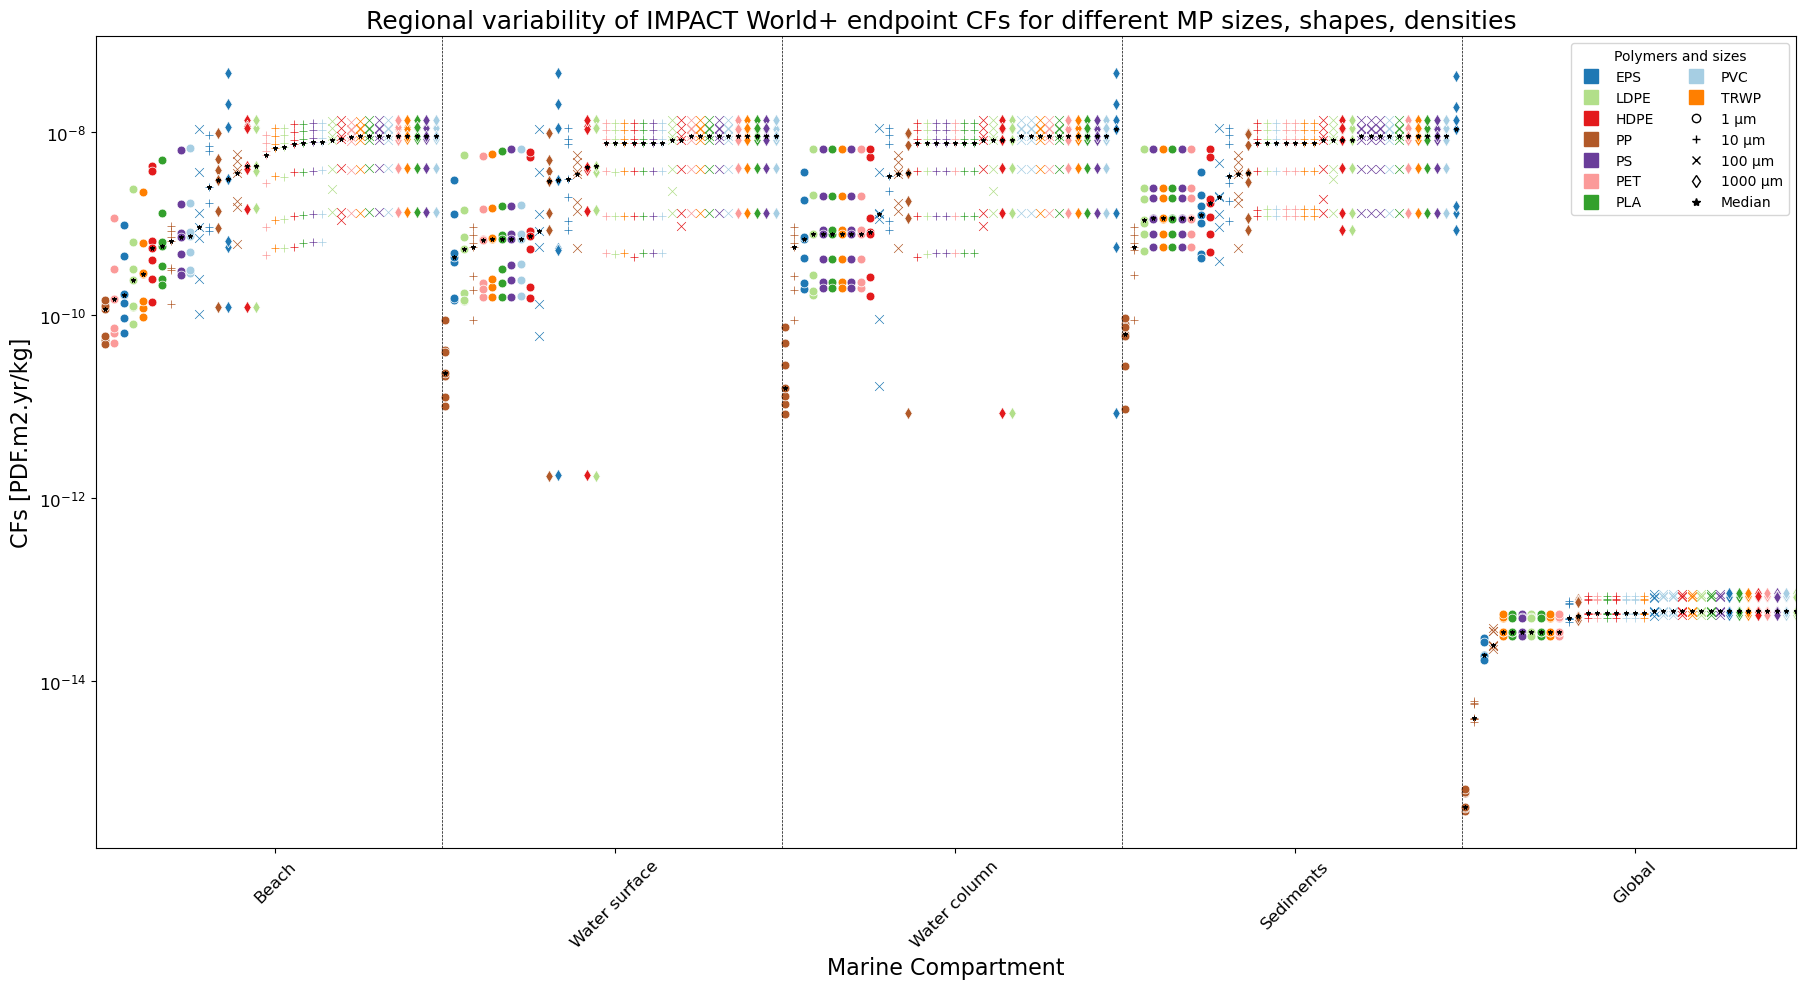

In [60]:
from matplotlib.lines import Line2D

# Initialize an empty list to collect data for plotting
plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in dict_CF_GLAM.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Separate sphere and fiber
df_sphere = df_plot[df_plot['Shape'] == 'sphere']
df_fiber = df_plot[df_plot['Shape'] == 'fiber']

categories = ['b.C', 'ws.C', 'wc.C', 'sed.C', 'glo']
df_fiber['Compartment'] = pd.Categorical(df_fiber['Compartment'], categories=categories, ordered=True)
df_sphere['Compartment'] = pd.Categorical(df_sphere['Compartment'], categories=categories, ordered=True)
category_positions = {cat: idx for idx, cat in enumerate(categories)}


# Set the figure size
plt.figure(figsize=(20, 10)) #, dpi = 800)

# Get the medians
fiber_medians = (df_fiber.groupby(['Compartment', 'Polymer', 'Size'])['Value'].median().reset_index())

# Sort the medians by increasing order
fiber_medians_sorted = fiber_medians.sort_values(by='Value', ascending=True).reset_index(drop=True)

# Add a column for shifted position for medians
fiber_medians_sorted['Shifted_Position'] = fiber_medians_sorted['Compartment'].map(category_positions).astype(float)

# Add the corresponding median values to df_fiber
# Merge df_fiber with fiber_medians_sorted to get the median for each data point
df_fiber = df_fiber.merge(fiber_medians_sorted[['Polymer', 'Size', 'Compartment', 'Value']], on=['Polymer', 'Size', 'Compartment'], 
                          suffixes=('', '_median'))

# Sort df_fiber based on the corresponding median value
df_fiber_sorted = df_fiber.sort_values(by='Value_median', ascending=True).reset_index(drop=True)

df_beach = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'b.C'].copy()
df_surface = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'ws.C'].copy()
df_column = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'wc.C'].copy()
df_sediment = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'sed.C'].copy()
df_global = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'glo'].copy()

# To plot the fibers
i = 0

# 7 because 7 regions, len(df_beach) but could have been any other comaprtment
for ix in range(0, len(df_beach), 7):
    # extract polymers for each df
    poly_beach = df_beach.iloc[ix, df_beach.columns.get_loc('Polymer')]
    poly_surface = df_surface.iloc[ix, df_surface.columns.get_loc('Polymer')]
    poly_column = df_column.iloc[ix, df_column.columns.get_loc('Polymer')]
    poly_sediment = df_sediment.iloc[ix, df_sediment.columns.get_loc('Polymer')]
    poly_global = df_global.iloc[ix, df_global.columns.get_loc('Polymer')]
    # extract sizes for each df
    size_beach = df_beach.iloc[ix, df_beach.columns.get_loc('Size')]
    size_surface = df_surface.iloc[ix, df_surface.columns.get_loc('Size')]
    size_column = df_column.iloc[ix, df_column.columns.get_loc('Size')]
    size_sediment = df_sediment.iloc[ix, df_sediment.columns.get_loc('Size')]
    size_global = df_global.iloc[ix, df_global.columns.get_loc('Size')]

    offset = (i * (1/(len([1, 10, 100, 1000]) * len(['EPS', 'LDPE', 'HDPE', 'PP', 'PS','PET','PLA','PVC', 'TRWP']))))
    
    df_beach['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_surface['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_column['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_sediment['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_global['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    
    # -------------- Create the scater plotplot for fiber on beach --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_beach == 1:
        symb = 'o'
    elif size_beach == 10:
        symb = '+'
    elif size_beach == 100:
        symb = 'x'
    elif size_beach == 1000:
        symb = 'd'

    # values 
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_beach.loc[df_beach['Polymer'] == poly_beach].loc[df_beach['Size'] == size_beach], 
        color = poly_colors.get(poly_beach),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_beach.loc[df_beach['Polymer'] == poly_beach].loc[df_beach['Size'] == size_beach], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    plt.xlim(left=min(df_beach['Shifted_Position']) - 0,  # Adding space on the left
        right=max(df_beach['Shifted_Position']) + 3)  # Adding space on the right

    # -------------- Create the scaterplot for fiber on water surface --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_surface == 1:
        symb = 'o'
    elif size_surface == 10:
        symb = '+'
    elif size_surface == 100:
        symb = 'x'
    elif size_surface == 1000:
        symb = 'd'
    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_surface.loc[df_surface['Polymer'] == poly_surface].loc[df_surface['Size'] == size_surface], 
        color = poly_colors.get(poly_surface),
        marker = symb,
        s= 40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_surface.loc[df_surface['Polymer'] == poly_surface].loc[df_surface['Size'] == size_surface], 
        color = 'black',
        edgecolor='black',
        marker = '*',
        s=10
    )
    plt.xlim(left=min(df_surface['Shifted_Position']) - 3,  # Adding space on the left
        right=max(df_surface['Shifted_Position']) + 3)  # Adding space on the right

    
    # -------------- Create the scatterplot for fiber on water column --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_column == 1:
        symb = 'o'
    elif size_column == 10:
        symb = '+'
    elif size_column == 100:
        symb = 'x'
    elif size_column == 1000:
        symb = 'd'
    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_column.loc[df_column['Polymer'] == poly_column].loc[df_column['Size'] == size_column], 
        color = poly_colors.get(poly_column),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_column.loc[df_column['Polymer'] == poly_column].loc[df_column['Size'] == size_column], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    
    # -------------- Create the scatterplot for fiber on sediments --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_sediment == 1:
        symb = 'o'
    elif size_sediment == 10:
        symb = '+'
    elif size_sediment == 100:
        symb = 'x'
    elif size_sediment == 1000:
        symb = 'd'
    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_sediment.loc[df_sediment['Polymer'] == poly_sediment].loc[df_sediment['Size'] == size_sediment], 
        color = poly_colors.get(poly_sediment),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_sediment.loc[df_sediment['Polymer'] == poly_sediment].loc[df_sediment['Size'] == size_sediment], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    
    # -------------- Create the scatterplot for fiber on global --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_global == 1:
        symb = 'o'
    elif size_global == 10:
        symb = '+'
    elif size_global == 100:
        symb = 'x'
    elif size_global == 1000:
        symb = 'd'

    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_global.loc[df_global['Polymer'] == poly_global].loc[df_global['Size'] == size_global], 
        color = poly_colors.get(poly_global),
        marker = symb,
        s = 40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_global.loc[df_global['Polymer'] == poly_global].loc[df_global['Size'] == size_global],  
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )

    i += 1

plt.xlim(left=min(df_global['Shifted_Position']) - 5,  # Adding space on the left
        right=max(df_global['Shifted_Position']) + 0)  # Adding space on the right

plt.axvline(0.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(1.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(2.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(3.99, color="k", linestyle="dashed", linewidth = 0.5)


# Log scale for the y-axis
plt.yscale('log')

# Titles and labels
plt.title("Regional variability of IMPACT World+ endpoint CFs for different MP sizes, shapes, densities ", fontsize=18)
plt.ylabel("CFs [PDF.m2.yr/kg]", fontsize=16)
plt.xlabel("Marine Compartment", fontsize=16)

# Rotate x-axis labels for better readability
custom_labels = ['Beach', 'Water surface', 'Water column', 'Sediments', 'Global']
plt.xticks(rotation=45, fontsize=12, ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=custom_labels)

plt.yticks(fontsize=12)

# Legend
legend_elements_polymers = [
    Line2D([0], [0], color='#1F78B4', marker = 's', linestyle='', markersize=10, label='EPS'),
    Line2D([0], [0], color='#B2DF8A', marker = 's', linestyle='', markersize=10, label='LDPE'),
    Line2D([0], [0], color='#E31A1C', marker = 's', linestyle='', markersize=10, label='HDPE'),
    Line2D([0], [0], color='#B15928', marker = 's', linestyle='', markersize=10, label='PP'),
    Line2D([0], [0], color='#6A3D9A', marker = 's', linestyle='', markersize=10, label='PS'),
    Line2D([0], [0], color='#FB9A99', marker = 's', linestyle='', markersize=10, label='PET'),
    Line2D([0], [0], color='#33A02C', marker = 's', linestyle='', markersize=10, label='PLA'),
    Line2D([0], [0], color='#A6CEE3', marker = 's', linestyle='', markersize=10, label='PVC'),
    Line2D([0], [0], color='#FF7F00', marker = 's', linestyle='', markersize=10, label='TRWP'),
]

legend_elements_size = [
    Line2D([0], [0], marker='o', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='1 µm'),
    Line2D([0], [0], marker='+', markeredgecolor = 'Black', linestyle='', markersize=6, label='10 µm'),
    Line2D([0], [0], marker='x', markeredgecolor = 'Black', linestyle='', markersize=6, label='100 µm'),
    Line2D([0], [0], marker='d', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='1000 µm'),
    Line2D([0], [0], marker='*', markeredgecolor = 'Black', markerfacecolor='black', linestyle='', markersize=6, label='Median'),

]

legend_elements = legend_elements_polymers + legend_elements_size

plt.legend(handles=legend_elements, title="Polymers and sizes", loc="upper right", ncol = 2)  # Adjust legend position

# Adjust the layout for better spacing
plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.95)  # Fine-tune these values

#plt.savefig(r'C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Figures\PPVar_Reg_fiber_GLAM.eps')

# Show the plot
plt.show()


In [ ]:
#df_plot.to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\df_plot\df_plot_fiber_GLAM_January.xlsx")

### For spheres

C:\Users\10User\AppData\Local\Temp\ipykernel_5296\3966586221.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fiber['Compartment'] = pd.Categorical(df_fiber['Compartment'], categories=categories, ordered=True)
C:\Users\10User\AppData\Local\Temp\ipykernel_5296\3966586221.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sphere['Compartment'] = pd.Categorical(df_sphere['Compartment'], categories=categories, ordered=True)


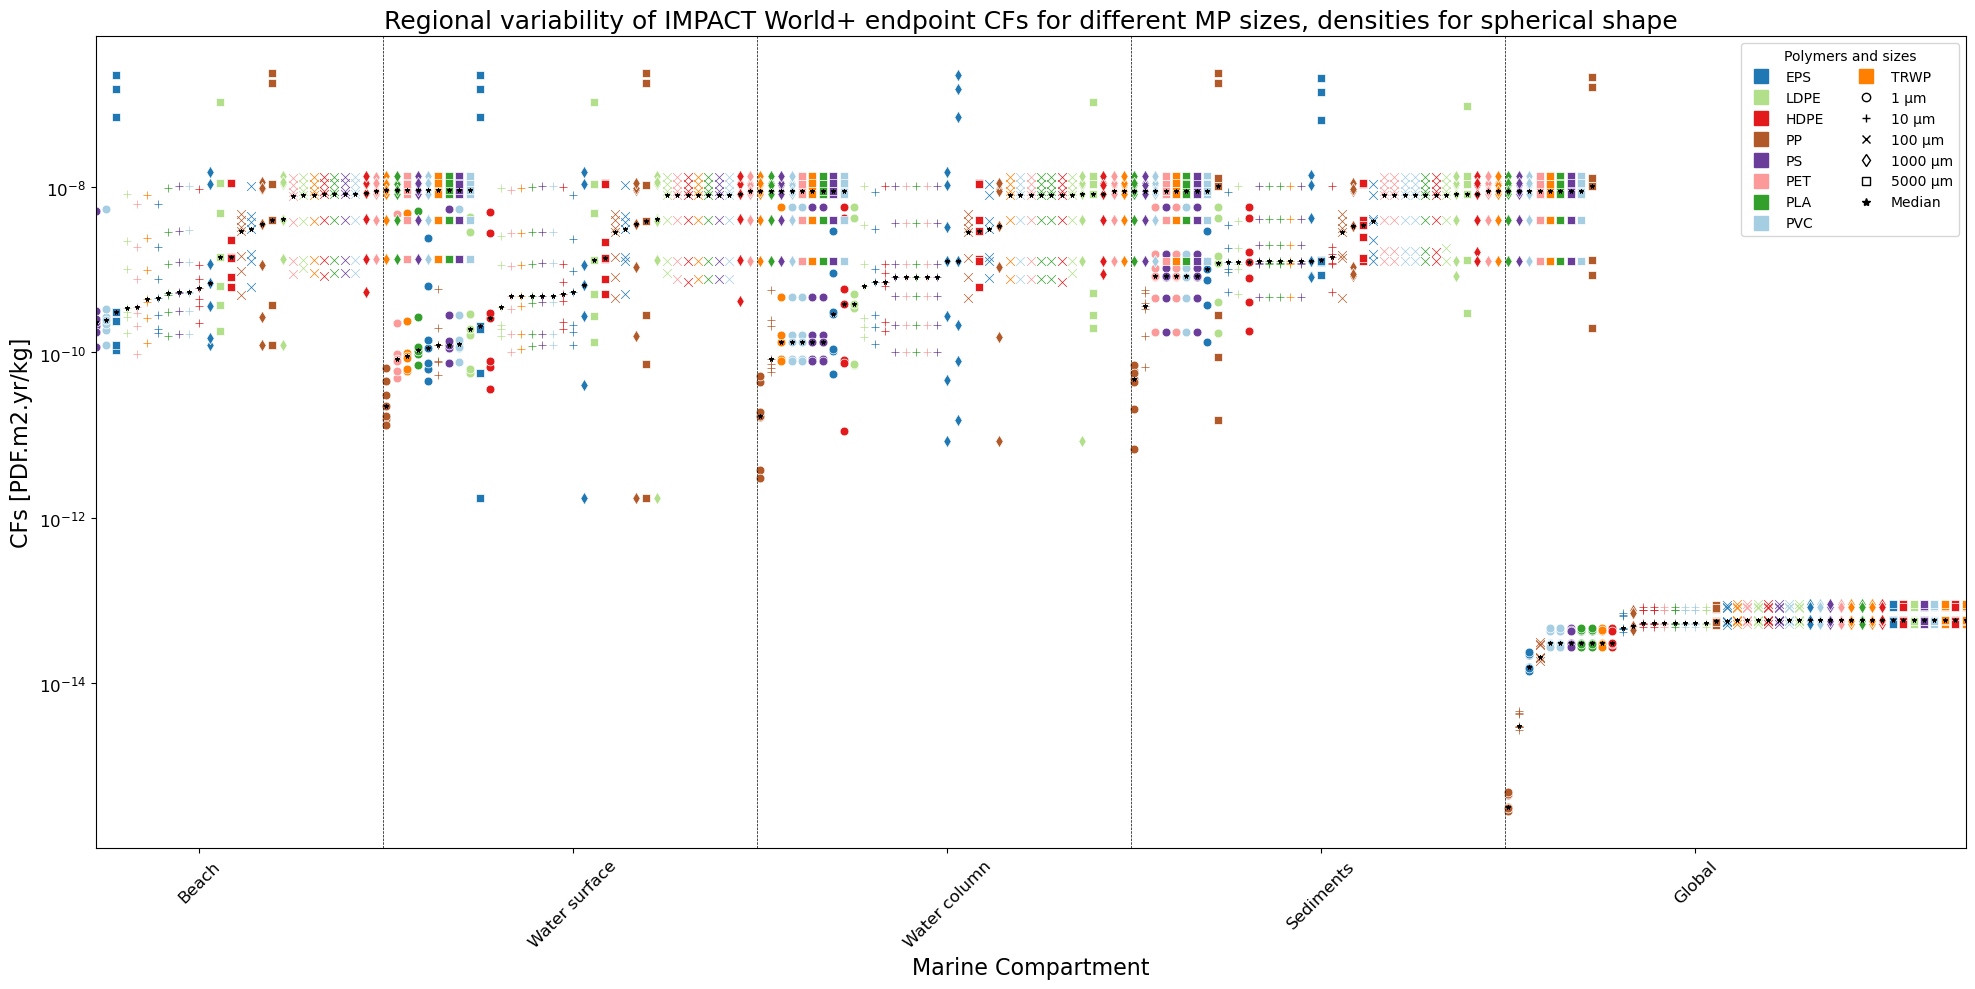

In [61]:
from matplotlib.lines import Line2D

# Initialize an empty list to collect data for plotting
plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in dict_CF_GLAM.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Separate sphere and fiber
df_sphere = df_plot[df_plot['Shape'] == 'sphere']
df_fiber = df_plot[df_plot['Shape'] == 'fiber']

categories = ['b.C', 'ws.C', 'wc.C', 'sed.C', 'glo']
df_fiber['Compartment'] = pd.Categorical(df_fiber['Compartment'], categories=categories, ordered=True)
df_sphere['Compartment'] = pd.Categorical(df_sphere['Compartment'], categories=categories, ordered=True)
category_positions = {cat: idx for idx, cat in enumerate(categories)}


# Set the figure size
plt.figure(figsize=(22, 10)) #, dpi = 800)

# Get the medians
sphere_medians = (df_sphere.groupby(['Compartment', 'Polymer', 'Size'])['Value'].median().reset_index())

# Sort the medians by increasing order
sphere_median_sorted = sphere_medians.sort_values(by='Value', ascending=True).reset_index(drop=True)

# Add a column for shifted position for medians
sphere_median_sorted['Shifted_Position'] = sphere_median_sorted['Compartment'].map(category_positions).astype(float)

# Add the corresponding median values to df_fiber
# Merge df_fiber with fiber_medians_sorted to get the median for each data point
df_sphere = df_sphere.merge(sphere_median_sorted[['Polymer', 'Size', 'Compartment', 'Value']], on=['Polymer', 'Size', 'Compartment'], 
                          suffixes=('', '_median'))

# Sort df_fiber based on the corresponding median value
df_sphere_sorted = df_sphere.sort_values(by='Value_median', ascending=True).reset_index(drop=True)

df_beach = df_sphere_sorted.loc[df_sphere_sorted.loc[:,'Compartment'] == 'b.C'].copy()
df_surface = df_sphere_sorted.loc[df_sphere_sorted.loc[:,'Compartment'] == 'ws.C'].copy()
df_column = df_sphere_sorted.loc[df_sphere_sorted.loc[:,'Compartment'] == 'wc.C'].copy()
df_sediment = df_sphere_sorted.loc[df_sphere_sorted.loc[:,'Compartment'] == 'sed.C'].copy()
df_global = df_sphere_sorted.loc[df_sphere_sorted.loc[:,'Compartment'] == 'glo'].copy()

# To plot the spheres
i = 0

# 7 because 7 regions, len(df_beach) but could have been any other comaprtment
for ix in range(0, len(df_beach), 7):
    # extract polymers for each df
    poly_beach = df_beach.iloc[ix, df_beach.columns.get_loc('Polymer')]
    poly_surface = df_surface.iloc[ix, df_surface.columns.get_loc('Polymer')]
    poly_column = df_column.iloc[ix, df_column.columns.get_loc('Polymer')]
    poly_sediment = df_sediment.iloc[ix, df_sediment.columns.get_loc('Polymer')]
    poly_global = df_global.iloc[ix, df_global.columns.get_loc('Polymer')]
    # extract sizes for each df
    size_beach = df_beach.iloc[ix, df_beach.columns.get_loc('Size')]
    size_surface = df_surface.iloc[ix, df_surface.columns.get_loc('Size')]
    size_column = df_column.iloc[ix, df_column.columns.get_loc('Size')]
    size_sediment = df_sediment.iloc[ix, df_sediment.columns.get_loc('Size')]
    size_global = df_global.iloc[ix, df_global.columns.get_loc('Size')]

    offset = (i * (1/(len([1, 10, 100, 1000]) * len(['EPS', 'LDPE', 'HDPE', 'PP', 'PS','PET','PLA','PVC', 'TRWP']))))
    
    df_beach['Shifted_Position'] = (df_sphere_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_surface['Shifted_Position'] = (df_sphere_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_column['Shifted_Position'] = (df_sphere_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_sediment['Shifted_Position'] = (df_sphere_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_global['Shifted_Position'] = (df_sphere_sorted['Compartment'].map(category_positions).astype(float) + offset)
    
    # -------------- Create the scater plotplot for fiber on beach --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_beach == 1:
        symb = 'o'
    elif size_beach == 10:
        symb = '+'
    elif size_beach == 100:
        symb = 'x'
    elif size_beach == 1000:
        symb = 'd'
    elif size_beach == 5000:
        symb = 's'

    # values 
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_beach.loc[df_beach['Polymer'] == poly_beach].loc[df_beach['Size'] == size_beach], 
        color = poly_colors.get(poly_beach),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_beach.loc[df_beach['Polymer'] == poly_beach].loc[df_beach['Size'] == size_beach], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    plt.xlim(left=min(df_beach['Shifted_Position']) - 0,  # Adding space on the left
        right=max(df_beach['Shifted_Position']) + 3)  # Adding space on the right

    # -------------- Create the scaterplot for fiber on water surface --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_surface == 1:
        symb = 'o'
    elif size_surface == 10:
        symb = '+'
    elif size_surface == 100:
        symb = 'x'
    elif size_surface == 1000:
        symb = 'd'
    elif size_surface == 5000:
        symb = 's'

    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_surface.loc[df_surface['Polymer'] == poly_surface].loc[df_surface['Size'] == size_surface], 
        color = poly_colors.get(poly_surface),
        marker = symb,
        s= 40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_surface.loc[df_surface['Polymer'] == poly_surface].loc[df_surface['Size'] == size_surface], 
        color = 'black',
        edgecolor='black',
        marker = '*',
        s=10
    )
    plt.xlim(left=min(df_surface['Shifted_Position']) - 3,  # Adding space on the left
        right=max(df_surface['Shifted_Position']) + 3)  # Adding space on the right

    
    # -------------- Create the scatterplot for fiber on water column --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_column == 1:
        symb = 'o'
    elif size_column == 10:
        symb = '+'
    elif size_column == 100:
        symb = 'x'
    elif size_column == 1000:
        symb = 'd'
    elif size_sediment == 5000:
        symb = 's'

    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_column.loc[df_column['Polymer'] == poly_column].loc[df_column['Size'] == size_column], 
        color = poly_colors.get(poly_column),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_column.loc[df_column['Polymer'] == poly_column].loc[df_column['Size'] == size_column], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    
    # -------------- Create the scatterplot for fiber on sediments --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_sediment == 1:
        symb = 'o'
    elif size_sediment == 10:
        symb = '+'
    elif size_sediment == 100:
        symb = 'x'
    elif size_sediment == 1000:
        symb = 'd'
    elif size_sediment == 5000:
        symb = 's'

    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_sediment.loc[df_sediment['Polymer'] == poly_sediment].loc[df_sediment['Size'] == size_sediment], 
        color = poly_colors.get(poly_sediment),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_sediment.loc[df_sediment['Polymer'] == poly_sediment].loc[df_sediment['Size'] == size_sediment], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    
    # -------------- Create the scatterplot for fiber on global --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_global == 1:
        symb = 'o'
    elif size_global == 10:
        symb = '+'
    elif size_global == 100:
        symb = 'x'
    elif size_global == 1000:
        symb = 'd'
    elif size_global == 5000:
        symb = 's'

    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_global.loc[df_global['Polymer'] == poly_global].loc[df_global['Size'] == size_global], 
        color = poly_colors.get(poly_global),
        marker = symb,
        s = 40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_global.loc[df_global['Polymer'] == poly_global].loc[df_global['Size'] == size_global],  
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )

    i += 1

plt.xlim(left=min(df_global['Shifted_Position']) - 5,  # Adding space on the left
        right=max(df_global['Shifted_Position']) + 0)  # Adding space on the right

plt.axvline(0.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(1.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(2.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(3.99, color="k", linestyle="dashed", linewidth = 0.5)


# Log scale for the y-axis
plt.yscale('log')

# Titles and labels
plt.title("Regional variability of IMPACT World+ endpoint CFs for different MP sizes, densities for spherical shape", fontsize=18)
plt.ylabel("CFs [PDF.m2.yr/kg]", fontsize=16)
plt.xlabel("Marine Compartment", fontsize=16)

# Rotate x-axis labels for better readability
custom_labels = ['Beach', 'Water surface', 'Water column', 'Sediments', 'Global']
plt.xticks(rotation=45, fontsize=12, ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=custom_labels)

plt.yticks(fontsize=12)

# Legend
legend_elements_polymers = [
    Line2D([0], [0], color='#1F78B4', marker = 's', linestyle='', markersize=10, label='EPS'),
    Line2D([0], [0], color='#B2DF8A', marker = 's', linestyle='', markersize=10, label='LDPE'),
    Line2D([0], [0], color='#E31A1C', marker = 's', linestyle='', markersize=10, label='HDPE'),
    Line2D([0], [0], color='#B15928', marker = 's', linestyle='', markersize=10, label='PP'),
    Line2D([0], [0], color='#6A3D9A', marker = 's', linestyle='', markersize=10, label='PS'),
    Line2D([0], [0], color='#FB9A99', marker = 's', linestyle='', markersize=10, label='PET'),
    Line2D([0], [0], color='#33A02C', marker = 's', linestyle='', markersize=10, label='PLA'),
    Line2D([0], [0], color='#A6CEE3', marker = 's', linestyle='', markersize=10, label='PVC'),
    Line2D([0], [0], color='#FF7F00', marker = 's', linestyle='', markersize=10, label='TRWP'),
]

legend_elements_size = [
    Line2D([0], [0], marker='o', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='1 µm'),
    Line2D([0], [0], marker='+', markeredgecolor = 'Black', linestyle='', markersize=6, label='10 µm'),
    Line2D([0], [0], marker='x', markeredgecolor = 'Black', linestyle='', markersize=6, label='100 µm'),
    Line2D([0], [0], marker='d', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='1000 µm'),
    Line2D([0], [0], marker='s', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='5000 µm'),
    Line2D([0], [0], marker='*', markeredgecolor = 'Black', markerfacecolor='black', linestyle='', markersize=6, label='Median'),

]

legend_elements = legend_elements_polymers + legend_elements_size

plt.legend(handles=legend_elements, title="Polymers and sizes", loc="upper right", ncol = 2)  # Adjust legend position

# Adjust the layout for better spacing
plt.tight_layout()
plt.subplots_adjust(left=0.1, right=0.95, wspace = 0.8)  # Fine-tune these values

#plt.savefig(r'C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Figures\PPVar_Reg_sphere_GLAM.eps')

# Show the plot
plt.show()


In [ ]:
#df_plot.to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\df_plot\df_plot_sphere_GLAM_January.xlsx")

In [ ]:
df_sphere.loc[df_sphere.loc[df_sphere.loc[:,'Polymer'] == 'HDPE'].loc[df_sphere.loc[:,'Size'] == 5000].loc[df_sphere.loc[:,'Compartment'] == 'ws.C'].Value.idxmax()]

In [ ]:
df_fiber.loc[df_fiber.loc[df_fiber.loc[:,'Polymer'] == 'EPS'].loc[df_fiber.loc[:,'Size'] == 1000].loc[df_fiber.loc[:,'Compartment'] == 'ws.C'].Value.idxmax()]

## 6.3 Residence time

In [26]:
data = []

for (country, polymer, shape, size), df in dict_FF.items():
    RT_i = df.values.diagonal()

    # Append the data to the rows list
    data.append([country, polymer, shape, size] + RT_i.tolist())

# Create dataframe
columns = ['Country', 'Polymer', 'Shape', 'Size', 'Beach', 'Water surface', 'Water column', 'Sediments', 'Global']
RT = pd.DataFrame(data, columns=columns)

In [32]:
RT.to_excel(r'C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\ResidenceTime.xlsx')

c:\Users\10User\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\10User\AppData\Local\Temp\ipykernel_16128\899205649.py:135: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  g.fig.tight_layout()
C:\Users\10User\AppData\Local\Temp\ipykernel_16128\899205649.py:135: UserWarning: The figure layout has changed to tight
  g.fig.tight_layout()


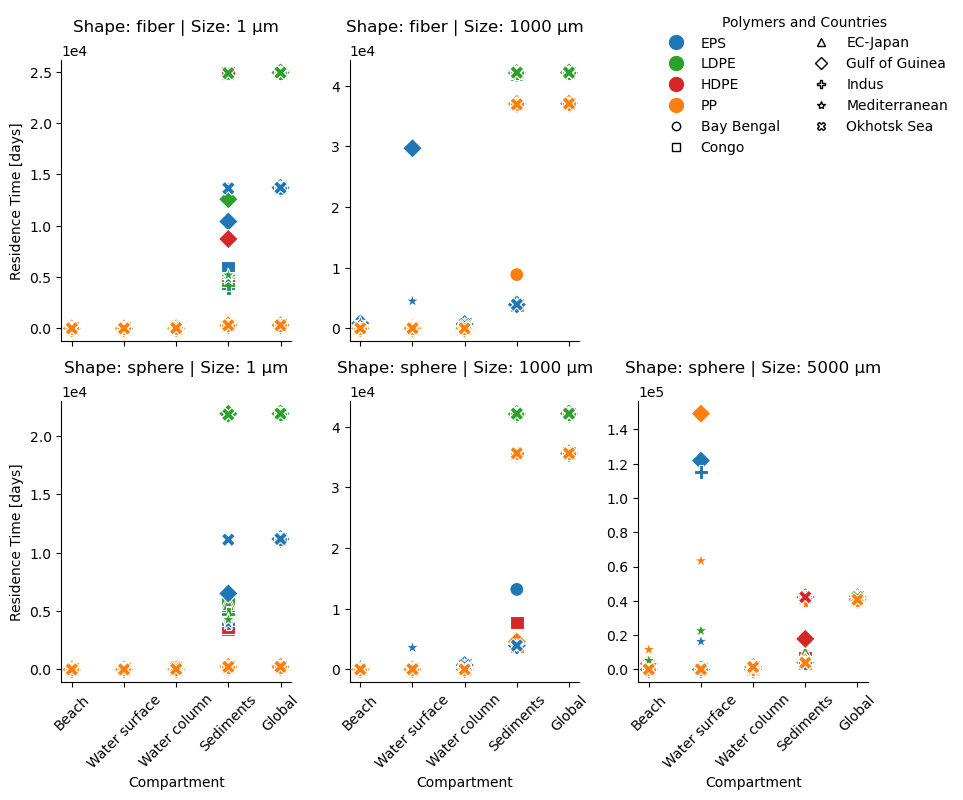

In [ ]:
from matplotlib.ticker import ScalarFormatter
from matplotlib.lines import Line2D

# Filter for specific density
LD = ['EPS', 'PP', 'LDPE', 'HDPE']
LD_df = RT[RT['Polymer'].isin(LD)]

custom_palette = {
    'EPS': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
    'PP': (1.0, 0.4980392156862745, 0.054901960784313725),
    'LDPE': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
    'HDPE': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
}

# Filter for specific size
sizes_to_plot = [1, 1000, 5000]
filtered_df = LD_df[LD_df['Size'].isin(sizes_to_plot)]
filtered_df = filtered_df[~((filtered_df['Shape'] == 'Fiber') & (filtered_df['Size'] == 5000))]

# Reshape data for plotting
long_df = filtered_df.melt(
    id_vars=["Country", "Polymer", "Shape", "Size"],
    value_vars=['Beach', 'Water surface', 'Water column', 'Sediments', 'Global'],
    var_name="Compartment",
    value_name="Residence Time"
)

# Create a new column to represent these combinations
long_df['Shape_Size'] = long_df['Shape'] + " | Size: " + long_df['Size'].astype(str)

# Assign unique markers to countries
countries = long_df['Country'].unique()
country_markers = dict(zip(countries, ['o', 's', '^', 'D', 'P', '*', 'X']))  # Example markers

# Get valid sizes and shapes for plotting
valid_combinations = long_df[['Shape', 'Size']].drop_duplicates()

# Ensure only valid combinations are included in FacetGrid
long_df = long_df[long_df[['Shape', 'Size']].apply(tuple, axis=1).isin(valid_combinations.apply(tuple, axis=1))]

# Create a FacetGrid to handle Shape and Size
g = sns.FacetGrid(
    long_df,
    row="Shape",
    col="Size",
    sharey=False,
    height=4,
    aspect=0.75,
)

# Map scatter plots to the grid
def scatter_plot(data, **kwargs):
    ax = plt.gca()  # Get the current axis
    for country, marker in country_markers.items():
        subset = data[data['Country'] == country]
        sns.scatterplot(
            data=subset,
            x="Compartment",
            y="Residence Time",
            hue="Polymer",
            style="Country",
            palette= custom_palette,  # Color palette for polymers
            markers=country_markers,
            s=100,  # Marker size
            ax=ax  # Use the current axis
        )

g.map_dataframe(scatter_plot)

# Set scientific notation for y-axis
for ax in g.axes.flat:
    ax.yaxis.set_major_formatter(ScalarFormatter())
    ax.tick_params(axis='y', which='both', labelsize=10)

    # Ensure the formatter uses scientific notation when appropriate
    ax.yaxis.get_major_formatter().set_scientific(True)
    ax.yaxis.get_major_formatter().set_powerlimits((-3, 4))  # Display powers for values outside the range of 10^-3 to 10^4


# Remove empty subplots
for ax in g.axes.flat:
    if not ax.has_data():
        ax.set_visible(False)

# Legend
legend_elements_polymers = [
    Line2D([0], [0], color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765), marker = 'o', linestyle='', markersize=10, label='EPS'),
    Line2D([0], [0], color=(0.17254901960784313, 0.6274509803921569, 0.17254901960784313), marker = 'o', linestyle='', markersize=10, label='LDPE'),
    Line2D([0], [0], color=(0.8392156862745098, 0.15294117647058825, 0.1568627450980392), marker = 'o', linestyle='', markersize=10, label='HDPE'),
    Line2D([0], [0], color=(1.0, 0.4980392156862745, 0.054901960784313725), marker = 'o', linestyle='', markersize=10, label='PP'),
]

legend_elements_country = [
    Line2D([0], [0], marker='o', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='Bay Bengal'),
    Line2D([0], [0], marker='s', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='Congo'),
    Line2D([0], [0], marker='^', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='EC-Japan'),
    Line2D([0], [0], marker='D', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='Gulf of Guinea'),
    Line2D([0], [0], marker='P', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='Indus'),
    Line2D([0], [0], marker='*', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='Mediterranean'),
    Line2D([0], [0], marker='X', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='Okhotsk Sea'),
]

legend_elements = legend_elements_polymers + legend_elements_country

# Get the figure and axes from the FacetGrid
fig = g.fig
axes = g.axes

# Create an additional axis in the grid to hold the legend in the empty space
# Add a new axis in the top-right corner of the first row (empty column)
extra_ax = fig.add_axes([0.85, 0.85, 0.1, 0.1])  # Adjust coordinates as necessary (x, y, width, height)

# Hide the new axis (it will only be used to display the legend)
extra_ax.axis('off')

# Add the legend to this custom axis
extra_ax.legend(
    handles=legend_elements,
    title="Polymers and Countries",
    loc="center",  # Place the legend in the center of the axis
    ncol=2,  # Arrange the legend in two columns
    frameon=False  # Remove the frame around the legend
)

# Customize the main grid plot
g.set_titles("Shape: {row_name} | Size: {col_name} µm")
g.set_axis_labels("Compartment", "Residence Time [days]")
for ax in g.axes.flat:
    ax.tick_params(axis='x', rotation=45)

    # Adjust the padding for titles 
    ax.set_title(ax.get_title(), pad=20)  # Increase or decrease 'pad' as needed for uniformity

# Adjust layout to fit the legend inside the grid
g.fig.tight_layout()

#plt.savefig(r'C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Figures\ResidenceTime.eps')

# Show the plot
plt.show()

In [ ]:
unique_polymers = long_df['Polymer'].unique()
palette = sns.color_palette('Paired_r', len(unique_polymers))

for polymer, color in zip(unique_polymers, palette):
    print(f"{polymer}: {color}")

In [ ]:
# Access the hue mapping after plotting
scatter = sns.scatterplot(
    data=subset,
    x="Compartment",
    y="Residence Time",
    hue="Polymer",
    style="Country",
    palette="Paired_r",
    markers=country_markers,
    s=100,
    ax=ax
)

# Print the mapping
print(scatter.legend_.get_legend_handles_labels())


In [31]:
print("Country markers mapping:", country_markers)


Country markers mapping: {'BayBengal': 'o', 'Congo': 's', 'EC-Japan': '^', 'GulfGuinea': 'D', 'Indus': 'P', 'Mediterranean': '*', 'OkhotskSea': 'X'}


In [ ]:
countries = long_df['Country'].unique()
print("Countries being plotted in order:", countries)

## 6.4 Variability comparison

In [39]:
import itertools

### IW+

In [62]:
# shape
# The max_diff_shape represents the highest difference between the minimum and maximum value for a combination of country, polymer, size between spheres and fibers

max_diff_shape = 0

for country in transfer.index.levels[0]:
    for polymer in degradation['Degradation'].index.levels[0]:
        for size in transfer.index.levels[3]:
            if size != 5000:
                diff = dict_CF_IW_endpoint[(country, polymer, 'sphere', size)] - dict_CF_IW_endpoint[(country, polymer, 'fiber', size)]
                diff = diff.max().max()
                if abs(diff) > abs(max_diff_shape):
                    max_diff_shape = diff

In [63]:
max_diff_shape

10012.570555969714

In [64]:
# size
max_diff_size = 0

combinations_country_polymer_shape = list(itertools.product(list(transfer.index.levels[0]), list(degradation['Degradation'].index.levels[0]), 
                                                            list(transfer.index.levels[2])))
for combination in combinations_country_polymer_shape:
    for size1 in transfer.index.levels[3]:
        if combination[2] == 'fiber' and size1 == 5000:
            continue
        for size2 in transfer.index.levels[3]:
            if combination[2] == 'fiber' and size2 == 5000:
                continue
            diff = (dict_CF_IW_endpoint[(combination[0], combination[1], combination[2], size1)] - 
                    dict_CF_IW_endpoint[(combination[0], combination[1], combination[2], size2)])
            diff = diff.max().max()
            if abs(diff) > abs(max_diff_size):
                max_diff_size = diff

In [65]:
max_diff_size

29505.77085608057

In [66]:
# polymer
max_diff_polymer = 0

combinations_country_shape_size = list(itertools.product(list(transfer.index.levels[0]), list(transfer.index.levels[2]), list(transfer.index.levels[3])))
for combination in combinations_country_shape_size:
    for polymer1 in list(degradation['Degradation'].index.levels[0]):
        if combination[1] == 'fiber' and combination[2] == 5000:
            continue
        for polymer2 in list(degradation['Degradation'].index.levels[0]):
            if combination[1] == 'fiber' and combination[2] == 5000:
                continue
            diff = (dict_CF_IW_endpoint[(combination[0], polymer1, combination[1], combination[2])] - 
                    dict_CF_IW_endpoint[(combination[0], polymer2, combination[1], combination[2])])
            diff = diff.max().max()
            if abs(diff) > abs(max_diff_polymer):
                max_diff_polymer = diff

In [67]:
max_diff_polymer

21855.760494993676

In [68]:
# country
max_diff_country = 0

combinations_polymer_shape_size = list(itertools.product(list(degradation['Degradation'].index.levels[0]), list(transfer.index.levels[2]), list(transfer.index.levels[3])))
for combination in combinations_polymer_shape_size:
    for country1 in list(transfer.index.levels[0]):
        if combination[1] == 'fiber' and combination[2] == 5000:
            continue
        for country2 in list(transfer.index.levels[0]):
            if combination[1] == 'fiber' and combination[2] == 5000:
                continue
            diff = (dict_CF_IW_endpoint[(country1, combination[0], combination[1], combination[2])] - 
                    dict_CF_IW_endpoint[(country2, combination[0], combination[1], combination[2])])
            diff = diff.max().max()
            if abs(diff) > abs(max_diff_country):
                max_diff_country = diff

In [69]:
max_diff_country

29517.10202628894

### GLAM

In [70]:
# shape
# The max_diff_shape represents the highest difference between the minimum and maximum value for a combination of country, polymer, size between spheres and fibers

max_diff_shape = 0

for country in transfer.index.levels[0]:
    for polymer in degradation['Degradation'].index.levels[0]:
        for size in transfer.index.levels[3]:
            if size != 5000:
                diff = dict_CF_GLAM[(country, polymer, 'sphere', size)] - dict_CF_GLAM[(country, polymer, 'fiber', size)]
                diff = diff.max().max()
                if abs(diff) > abs(max_diff_shape):
                    max_diff_shape = diff

In [71]:
max_diff_shape

1.0554375721095604e-08

In [72]:
# size
max_diff_size = 0

combinations_country_polymer_shape = list(itertools.product(list(transfer.index.levels[0]), list(degradation['Degradation'].index.levels[0]), 
                                                            list(transfer.index.levels[2])))
for combination in combinations_country_polymer_shape:
    for size1 in transfer.index.levels[3]:
        if combination[2] == 'fiber' and size1 == 5000:
            continue
        for size2 in transfer.index.levels[3]:
            if combination[2] == 'fiber' and size2 == 5000:
                continue
            diff = (dict_CF_GLAM[(combination[0], combination[1], combination[2], size1)] - 
                    dict_CF_GLAM[(combination[0], combination[1], combination[2], size2)])
            diff = diff.max().max()
            if abs(diff) > abs(max_diff_size):
                max_diff_size = diff

In [73]:
max_diff_size

2.4015090965420733e-07

In [74]:
# polymer
max_diff_polymer = 0

combinations_country_shape_size = list(itertools.product(list(transfer.index.levels[0]), list(transfer.index.levels[2]), list(transfer.index.levels[3])))
for combination in combinations_country_shape_size:
    for polymer1 in list(degradation['Degradation'].index.levels[0]):
        if combination[1] == 'fiber' and combination[2] == 5000:
            continue
        for polymer2 in list(degradation['Degradation'].index.levels[0]):
            if combination[1] == 'fiber' and combination[2] == 5000:
                continue
            diff = (dict_CF_GLAM[(combination[0], polymer1, combination[1], combination[2])] - 
                    dict_CF_GLAM[(combination[0], polymer2, combination[1], combination[2])])
            diff = diff.max().max()
            if abs(diff) > abs(max_diff_polymer):
                max_diff_polymer = diff

In [75]:
max_diff_polymer

2.387622117777403e-07

In [76]:
# country
max_diff_country = 0

combinations_polymer_shape_size = list(itertools.product(list(degradation['Degradation'].index.levels[0]), list(transfer.index.levels[2]), list(transfer.index.levels[3])))
for combination in combinations_polymer_shape_size:
    for country1 in list(transfer.index.levels[0]):
        if combination[1] == 'fiber' and combination[2] == 5000:
            continue
        for country2 in list(transfer.index.levels[0]):
            if combination[1] == 'fiber' and combination[2] == 5000:
                continue
            diff = (dict_CF_GLAM[(country1, combination[0], combination[1], combination[2])] - 
                    dict_CF_GLAM[(country2, combination[0], combination[1], combination[2])])
            diff = diff.max().max()
            if abs(diff) > abs(max_diff_country):
                max_diff_country = diff

In [77]:
max_diff_country

2.401661599920766e-07

# 7. Aggregation

In [36]:
Emiss_perc = pd.read_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\EmissionsPercent.xlsx")
Emiss_perc = Emiss_perc.set_index('Region')

In [21]:
Emiss_perc

,Percentage
Region,
EC-Japan,73
Indus,7
Mediterranean,4
BayBengal,3
OkhotskSea,2
GulfGuinea,2
Congo,1


## 7.1 GLAM

In [37]:
dict_CF_GLAM_cont = {}

dict_cont = {'Asia': ['BayBengal', 'EC-Japan', 'OkhotskSea', 'Indus'], 'Africa': ['Congo', 'GulfGuinea', 'Mediterranean']}

# Create a dictionary filled with zero to initialize
dict_CF_GLAM_cont=list(pd.DataFrame(0, index = pd.MultiIndex.from_product([dict_cont.keys(), degradation['Degradation'].index.levels[0], transfer.index.levels[2], 
                                                                           transfer.index.levels[3]]), columns = ['CFs']).to_dict().values())[0]

dict_CF_GLAM_cont = {k:pd.DataFrame(0, index = ['SDF'], columns=["b.C", "ws.C", "wc.C", "sed.C","glo"]) for k,v in dict_CF_GLAM_cont.items()}
dict_CF_GLAM_cont = {k:v for k,v in dict_CF_GLAM_cont.items() if not (k[2] == 'fiber' and k[3] == 5000)} # take out the fiber 5000

for continent in dict_cont.keys():
    for country in dict_cont[continent]:
        for polymer in degradation['Degradation'].index.levels[0]:
            for shape in transfer.index.levels[2]:
                for size in transfer.index.levels[3]:
                    if size == 5000 and shape == 'fiber':
                        pass
                    else:
                        dict_CF_GLAM_cont[(continent,polymer,shape,size)] += (dict_CF_GLAM[(country,polymer,shape,size)] * Emiss_perc.loc[country, 'Percentage']/100)
                        

In [38]:
dict_CF_GLAM_glo = {}

# Create a dictionary filled with zero to initialize
dict_CF_GLAM_glo=list(pd.DataFrame(0, index = pd.MultiIndex.from_product([['CF_glo'], degradation['Degradation'].index.levels[0], transfer.index.levels[2], 
                                                                           transfer.index.levels[3]]), columns = ['CFs']).to_dict().values())[0]

dict_CF_GLAM_glo = {k:pd.DataFrame(0, index = ['SDF'], columns=["b.C", "ws.C", "wc.C", "sed.C","glo"]) for k,v in dict_CF_GLAM_glo.items()}
dict_CF_GLAM_glo = {k:v for k,v in dict_CF_GLAM_glo.items() if not (k[2] == 'fiber' and k[3] == 5000)} # take out the fiber 5000

for country in Emiss_perc.index:
    for polymer in degradation['Degradation'].index.levels[0]:
        for shape in transfer.index.levels[2]:
            for size in transfer.index.levels[3]:
                if size == 5000 and shape == 'fiber':
                    pass
                else:
                    dict_CF_GLAM_glo[('CF_glo',polymer,shape,size)] += (dict_CF_GLAM[(country,polymer,shape,size)] * Emiss_perc.loc[country, 'Percentage']/100)

In [136]:
dict_CF_GLAM_glo

{('CF_glo',
  'EPS',
  'fiber',
  1):          b.C     ws.C     wc.C    sed.C      glo
 SDF 1.41e-10 3.96e-10 4.65e-10 5.68e-10 1.77e-14,
 ('CF_glo',
  'EPS',
  'fiber',
  10):          b.C     ws.C     wc.C    sed.C      glo
 SDF 1.34e-09 1.58e-09 1.62e-09 1.69e-09 4.50e-14,
 ('CF_glo',
  'EPS',
  'fiber',
  100):          b.C     ws.C     wc.C    sed.C      glo
 SDF 1.35e-09 1.32e-09 1.36e-09 1.49e-09 5.33e-14,
 ('CF_glo',
  'EPS',
  'fiber',
  1000):          b.C     ws.C     wc.C    sed.C      glo
 SDF 2.99e-09 2.94e-09 3.79e-09 3.69e-09 5.43e-14,
 ('CF_glo',
  'EPS',
  'sphere',
  1):          b.C     ws.C     wc.C    sed.C      glo
 SDF 4.21e-11 1.10e-10 1.52e-10 3.13e-10 1.44e-14,
 ('CF_glo',
  'EPS',
  'sphere',
  10):          b.C     ws.C     wc.C    sed.C      glo
 SDF 7.74e-10 9.46e-10 1.03e-09 1.16e-09 4.26e-14,
 ('CF_glo',
  'EPS',
  'sphere',
  100):          b.C     ws.C     wc.C    sed.C      glo
 SDF 1.60e-09 1.59e-09 1.66e-09 1.76e-09 5.29e-14,
 ('CF_glo',
  'EPS',
 

In [ ]:
dict_CF_IW_endpoint[('BayBengal',EPS)]

KeyError: 'BayBengal'

In [45]:
max({v.loc['SDF','b.C'] for k,v in dict_CF_GLAM.items() if k[1] == 'EPS' and k[2] == 'sphere' and k[3] == 1})

6.425594927605357e-10

In [126]:
value = max({v.loc['CF [PDF.m2.yr/kg]','b.C'] for k,v in dict_CF_IW_endpoint.items() if k[1] == 'PET' and k[2] == 'sphere' and k[3] == 5000})

formatted_value = f"{value:.2e}"  # Adjust `.2e` for the desired number of decimal places
print(formatted_value)

1.04e+04


In [ ]:
polymers = ['EPS', 'HDPE', 'LDPE', 'PET', "PLA", "PP", 'PS', 'PVC', 'TRWP']
shapes = ['sphere', 'fiber']
sizes = [1, 10, 100, 1000, 5000]

results_variability = {}

for polymer in polymers:
    for shape in shapes:
        for size in sizes:
            if size == 5000 and shape == 'fiber':
                pass
            else:
                filtered_values = [
                    v.loc['CF [PDF.m2.yr/kg]', 'b.C']
                    for k, v in dict_CF_IW_endpoint.items()
                    if k[1] == polymer and k[2] == shape and k[3] == size
                ]
                if filtered_values:  # Check if there are values to calculate
                    min_value = min(filtered_values)
                    max_value = max(filtered_values)
                    results_variability[(polymer, shape, size)] = {'min': min_value, 'max': max_value}


for key, value in results_variability.items():
    print(f"{key}: Min = {value['min']}, Max = {value['max']}")

In [127]:
dict_CF_IW_endpoint

{('BayBengal',
  'EPS',
  'fiber',
  1):                        b.C     ws.C     wc.C    sed.C      glo
 CF [PDF.m2.yr/kg] 1.17e+02 3.71e+02 5.29e+02 1.21e+03 1.09e+01,
 ('BayBengal',
  'EPS',
  'fiber',
  10):                        b.C     ws.C     wc.C    sed.C      glo
 CF [PDF.m2.yr/kg] 7.03e+03 8.57e+03 8.58e+03 8.58e+03 2.77e+01,
 ('BayBengal',
  'EPS',
  'fiber',
  100):                        b.C     ws.C     wc.C    sed.C      glo
 CF [PDF.m2.yr/kg] 2.79e+03 2.85e+03 2.85e+03 3.54e+03 3.28e+01,
 ('BayBengal',
  'EPS',
  'fiber',
  1000):                        b.C     ws.C     wc.C    sed.C      glo
 CF [PDF.m2.yr/kg] 2.31e+03 2.31e+03 1.03e+04 1.03e+04 3.34e+01,
 ('BayBengal',
  'EPS',
  'sphere',
  1):                        b.C     ws.C     wc.C    sed.C      glo
 CF [PDF.m2.yr/kg] 2.94e+01 1.15e+02 2.43e+02 9.44e+02 8.88e+00,
 ('BayBengal',
  'EPS',
  'sphere',
  10):                        b.C     ws.C     wc.C    sed.C      glo
 CF [PDF.m2.yr/kg] 3.39e+02 4.37e+02 5.74e

In [23]:
SuperGLAM_cont = pd.DataFrame()
for i in dict_CF_GLAM_cont.keys():
    df = pd.concat([dict_CF_GLAM_cont[i]], keys=[i]) # add the keys of FF matrix
    SuperGLAM_cont = pd.concat([SuperGLAM_cont,df])
    
SuperGLAM_cont.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\GLAM\CF_cont.xlsx")

In [24]:
SuperGLAM_glo = pd.DataFrame()
for i in dict_CF_GLAM_glo.keys():
    df = pd.concat([dict_CF_GLAM_glo[i]], keys=[i]) # add the keys of FF matrix
    SuperGLAM_glo = pd.concat([SuperGLAM_glo,df])
    
SuperGLAM_glo.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\GLAM\CF_glo.xlsx")

## 7.2 IW+

In [25]:
dict_CF_IW_endpoint_cont = {}

dict_cont = {'Asia': ['BayBengal', 'EC-Japan', 'OkhotskSea', 'Indus'], 'Africa': ['Congo', 'GulfGuinea', 'Mediterranean']}

# Create a dictionary filled with zero to initialize
dict_CF_IW_endpoint_cont=list(pd.DataFrame(0, index = pd.MultiIndex.from_product([dict_cont.keys(), degradation['Degradation'].index.levels[0], transfer.index.levels[2], 
                                                                           transfer.index.levels[3]]), columns = ['CFs']).to_dict().values())[0]

dict_CF_IW_endpoint_cont = {k:pd.DataFrame(0, index = ['CF [PDF.m2.yr/kg]'], columns=["b.C", "ws.C", "wc.C", "sed.C","glo"]) for k,v in dict_CF_IW_endpoint_cont.items()}
dict_CF_IW_endpoint_cont = {k:v for k,v in dict_CF_IW_endpoint_cont.items() if not (k[2] == 'fiber' and k[3] == 5000)} # take out the fiber 5000

for continent in dict_cont.keys():
    for country in dict_cont[continent]:
        for polymer in degradation['Degradation'].index.levels[0]:
            for shape in transfer.index.levels[2]:
                for size in transfer.index.levels[3]:
                    if size == 5000 and shape == 'fiber':
                        pass
                    else:
                        dict_CF_IW_endpoint_cont[(continent,polymer,shape,size)] += (dict_CF_IW_endpoint[(country,polymer,shape,size)] * Emiss_perc.loc[country, 'Percentage']/100)


In [26]:
dict_CF_IW_glo = {}

# Create a dictionary filled with zero to initialize
dict_CF_IW_glo=list(pd.DataFrame(0, index = pd.MultiIndex.from_product([['CF_glo'], degradation['Degradation'].index.levels[0], transfer.index.levels[2], 
                                                                           transfer.index.levels[3]]), columns = ['CFs']).to_dict().values())[0]

dict_CF_IW_glo = {k:pd.DataFrame(0, index = ['CF [PDF.m2.yr/kg]'], columns=["b.C", "ws.C", "wc.C", "sed.C","glo"]) for k,v in dict_CF_IW_glo.items()}
dict_CF_IW_glo = {k:v for k,v in dict_CF_IW_glo.items() if not (k[2] == 'fiber' and k[3] == 5000)} # take out the fiber 5000

for country in Emiss_perc.index:
    for polymer in degradation['Degradation'].index.levels[0]:
        for shape in transfer.index.levels[2]:
            for size in transfer.index.levels[3]:
                if size == 5000 and shape == 'fiber':
                    pass
                else:
                    dict_CF_IW_glo[('CF_glo',polymer,shape,size)] += (dict_CF_IW_endpoint[(country,polymer,shape,size)] * Emiss_perc.loc[country, 'Percentage']/100)

In [27]:
Super_IW_cont = pd.DataFrame()
for i in dict_CF_IW_endpoint_cont.keys():
    df = pd.concat([dict_CF_IW_endpoint_cont[i]], keys=[i]) # add the keys of FF matrix
    Super_IW_cont = pd.concat([Super_IW_cont,df])
    
Super_IW_cont.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\IW+\CF_IW_cont.xlsx")

In [28]:
Super_IW_glo = pd.DataFrame()
for i in dict_CF_IW_glo.keys():
    df = pd.concat([dict_CF_IW_glo[i]], keys=[i]) # add the keys of FF matrix
    Super_IW_glo = pd.concat([Super_IW_glo,df])
    
Super_IW_glo.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\IW+\CF_IW_glo.xlsx")

# 8. Influence of seasonality

In [48]:
# Read the file
transfer_seasonality = pd.read_csv(r"C:\Users\10User\Desktop\TrackMPD-master\Results\All_results_article3\July\Rates\Rate_all_July.csv")
transfer_seasonality = transfer_seasonality.set_index(['Country_all','Polymer_all','Shape_all','Size_all']).fillna(0)

In [49]:
# Build a function that will create the matrices
def makeMatrix_July(country,polymer,shape,size):

    k_matrix = {}
    k_matrix = pd.DataFrame(0, index=["b.C", "ws.C", "wc.C", "sed.C","glo"], columns=["b.C", "ws.C", "wc.C", "sed.C","glo"])

    k_deg_slow = (degradation["Degradation"].loc[(polymer,size,"Slow"),shape])/365.25
    k_deg_medium = (degradation["Degradation"].loc[(polymer,size,"Medium"),shape])/365.25
    k_deg_fast = (degradation["Degradation"].loc[(polymer,size,"Fast"),shape])/365.25

    k_beaching = (transfer_seasonality.loc[(country,polymer,shape,size),"k_Surf2beach_median_all"])
    k_wcC_wsC = (transfer_seasonality.loc[(country,polymer,shape,size),"k_Surf2Col_cont_median_all"])
    k_wsC_wcC = (transfer_seasonality.loc[(country,polymer,shape,size),"k_Col2Surf"])
    k_sedC_wcC = (transfer_seasonality.loc[(country,polymer,shape,size),"k_Col2Sed_cont_median_all"])
    k_glo_wsC = (transfer_seasonality.loc[(country,polymer,shape,size),"k_Surf2glo_median_all"])
    k_glo_wcC = (transfer_seasonality.loc[(country,polymer,shape,size),"k_Col2glo_median_all"])

    k_matrix.loc["b.C", "b.C"] = k_deg_fast - k_burial - k_resurfacing
    k_matrix.loc["ws.C", "b.C"] = k_resurfacing
    k_matrix.loc["b.C", "ws.C"] = k_beaching
    k_matrix.loc["ws.C", "ws.C"] = k_deg_medium - k_wcC_wsC - k_beaching - k_glo_wsC 
    k_matrix.loc["wc.C", "ws.C"] = k_wcC_wsC
    k_matrix.loc["ws.C", "wc.C"] = k_wsC_wcC
    k_matrix.loc["wc.C", "wc.C"] = k_deg_slow - k_sedC_wcC - k_wsC_wcC - k_glo_wcC   
    k_matrix.loc["sed.C", "wc.C"] = k_sedC_wcC
    k_matrix.loc["wc.C", "sed.C"] = k_resuspension
    k_matrix.loc["sed.C", "sed.C"] = k_deg_slow - k_burial - k_resuspension
    k_matrix.loc["glo","ws.C"] = k_glo_wsC
    k_matrix.loc["glo","wc.C"] = k_glo_wcC
    k_matrix.loc["glo","glo"] = k_deg_slow - k_burial

    return k_matrix.fillna(0)

In [50]:
# Create the dictionary where the matrices will be stored
dict_k_J = {}
dict_FF_J = {}
dict_CF_J = {}
dict_CF_GLAM_J = {}
dict_CF_IW_midpoint_Unagg_J = {}
dict_CF_IW_endpoint_Unagg_J ={}
dict_CF_IW_midpoint_J = {}
dict_CF_IW_endpoint_J ={}

for i in transfer_seasonality.index:
    country = i[0]
    polymer = i[1]
    shape = i[2]
    size = i[3]
    dict_k_J[(country,polymer,shape,size)] = makeMatrix_July(country,polymer,shape,size)
    dict_FF_J[(country,polymer,shape,size)] = pd.DataFrame(- np.linalg.inv(dict_k_J[(country,polymer,shape,size)]),index=["b.C", "ws.C", "wc.C", "sed.C","glo"], columns=["b.C", "ws.C", "wc.C", "sed.C","glo"])
    dict_FF_J[(country,polymer,shape,size)]= dict_FF_J[(country,polymer,shape,size)][abs(dict_FF_J[(country,polymer,shape,size)])>1e-6].fillna(0) # to remove the negative values that should be zero
    dict_CF_J[(country,polymer,shape,size)] = dict_EEF[country].dot(dict_FF_J[(country,polymer,shape,size)]) 

    # divide by the volume of each sub-compartment and multiply by 365.25 to convert days to years
    dict_CF_J[(country,polymer,shape,size)].loc['b.C'] /= (Size_comp.loc[country, 'Beach volume [km3]']*1e9 * 365.25)
    dict_CF_J[(country,polymer,shape,size)].loc['ws.C'] /= (Size_comp.loc[country, 'Water surface volume [km3]']*1e9 * 365.25)
    dict_CF_J[(country,polymer,shape,size)].loc['wc.C'] /= (Size_comp.loc[country, 'Water column volume [km3]']*1e9 * 365.25)
    dict_CF_J[(country,polymer,shape,size)].loc['sed.C'] /= (Size_comp.loc[country, 'Sediment volume [km3]']*1e9 * 365.25)
    dict_CF_J[(country,polymer,shape,size)].loc['glo'] /= (Size_comp.loc[country, 'Global volume [km3]']*1e9 * 365.25)

    # Calculate the CFs for GLAM
    dict_CF_GLAM_J[(country,polymer,shape,size)] = dict_SDF_GLAM[country].dot(dict_CF_J[(country,polymer,shape,size)])

    # Calculate the CFs for IW+ midpoint
    dict_CF_IW_midpoint_Unagg_J[(country,polymer,shape,size)] = dict_SDF_IW[country].mul(dict_CF_J[(country,polymer,shape,size)]).mul(dict_volume[country]*1E9)
    dict_CF_IW_endpoint_Unagg_J[(country,polymer,shape,size)] = dict_SDF_IW[country].mul(dict_CF_J[(country,polymer,shape,size)]).mul(dict_area[country]*1E6)

    # Aggregate the CFs (sum the rows of each column)
    dict_CF_IW_midpoint_J[(country,polymer,shape,size)] = pd.DataFrame(dict_CF_IW_midpoint_Unagg_J[(country,polymer,shape,size)].sum()).T
    dict_CF_IW_midpoint_J[(country,polymer,shape,size)].index = ['CF [PAF.m3.yr/kg]']
    dict_CF_IW_endpoint_J[(country,polymer,shape,size)] = pd.DataFrame(dict_CF_IW_endpoint_Unagg_J[(country,polymer,shape,size)].sum()).T
    dict_CF_IW_endpoint_J[(country,polymer,shape,size)].index = ['CF [PDF.m2.yr/kg]']

In [ ]:
SuperK_J = pd.DataFrame()
for i in dict_k_J.keys():
    df = pd.concat([dict_k_J[i]], keys=[i]) # add the keys of FF matrix
    SuperK_J = pd.concat([SuperK_J,df])
    
#SuperK_J.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\July\K_total_J.xlsx")

In [ ]:
SuperFF_J = pd.DataFrame()
for i in dict_FF_J.keys():
    df = pd.concat([dict_FF_J[i]], keys=[i]) # add the keys of FF matrix
    SuperFF_J = pd.concat([SuperFF_J,df])
    
#SuperFF_J.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\July\FF_total_J.xlsx")

In [51]:
SuperCF_GLAM_J = pd.DataFrame()
for i in dict_CF_GLAM_J.keys():
    df = pd.concat([dict_CF_GLAM_J[i]], keys=[i]) # add the keys of FF matrix
    SuperCF_GLAM_J = pd.concat([SuperCF_GLAM_J,df])
    
SuperCF_GLAM_J.to_excel(r"C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\GLAM\CF_GLAM_total_J.xlsx")

## 8.1 IW+ - endpoint

In [ ]:
from matplotlib.lines import Line2D

# Initialize an empty list to collect data for plotting
plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in dict_CF_IW_endpoint_J.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Separate sphere and fiber
df_sphere = df_plot[df_plot['Shape'] == 'sphere']
df_fiber = df_plot[df_plot['Shape'] == 'fiber']

categories = ['b.C', 'ws.C', 'wc.C', 'sed.C', 'glo']
df_fiber['Compartment'] = pd.Categorical(df_fiber['Compartment'], categories=categories, ordered=True)
df_sphere['Compartment'] = pd.Categorical(df_sphere['Compartment'], categories=categories, ordered=True)
category_positions = {cat: idx for idx, cat in enumerate(categories)}


# Set the figure size
plt.figure(figsize=(20, 10)) #, dpi = 800)

# Get the medians
fiber_medians = (df_fiber.groupby(['Compartment', 'Polymer', 'Size'])['Value'].median().reset_index())

# Sort the medians by increasing order
fiber_medians_sorted = fiber_medians.sort_values(by='Value', ascending=True).reset_index(drop=True)

# Add a column for shifted position for medians
fiber_medians_sorted['Shifted_Position'] = fiber_medians_sorted['Compartment'].map(category_positions).astype(float)

# Add the corresponding median values to df_fiber
# Merge df_fiber with fiber_medians_sorted to get the median for each data point
df_fiber = df_fiber.merge(fiber_medians_sorted[['Polymer', 'Size', 'Compartment', 'Value']], on=['Polymer', 'Size', 'Compartment'], 
                          suffixes=('', '_median'))

# Sort df_fiber based on the corresponding median value
df_fiber_sorted = df_fiber.sort_values(by='Value_median', ascending=True).reset_index(drop=True)

df_beach = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'b.C'].copy()
df_surface = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'ws.C'].copy()
df_column = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'wc.C'].copy()
df_sediment = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'sed.C'].copy()
df_global = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'glo'].copy()

# To plot the fibers
i = 0

# 7 because 7 regions, len(df_beach) but could have been any other comaprtment
for ix in range(0, len(df_beach), 7):
    # extract polymers for each df
    poly_beach = df_beach.iloc[ix, df_beach.columns.get_loc('Polymer')]
    poly_surface = df_surface.iloc[ix, df_surface.columns.get_loc('Polymer')]
    poly_column = df_column.iloc[ix, df_column.columns.get_loc('Polymer')]
    poly_sediment = df_sediment.iloc[ix, df_sediment.columns.get_loc('Polymer')]
    poly_global = df_global.iloc[ix, df_global.columns.get_loc('Polymer')]
    # extract sizes for each df
    size_beach = df_beach.iloc[ix, df_beach.columns.get_loc('Size')]
    size_surface = df_surface.iloc[ix, df_surface.columns.get_loc('Size')]
    size_column = df_column.iloc[ix, df_column.columns.get_loc('Size')]
    size_sediment = df_sediment.iloc[ix, df_sediment.columns.get_loc('Size')]
    size_global = df_global.iloc[ix, df_global.columns.get_loc('Size')]

    offset = (i * (1/(len([1, 10, 100, 1000]) * len(['EPS', 'LDPE', 'HDPE', 'PP', 'PS','PET','PLA','PVC', 'TRWP']))))
    
    df_beach['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_surface['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_column['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_sediment['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_global['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    
    # -------------- Create the scater plotplot for fiber on beach --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_beach == 1:
        symb = 'o'
    elif size_beach == 10:
        symb = '+'
    elif size_beach == 100:
        symb = 'x'
    elif size_beach == 1000:
        symb = 'd'

    # values 
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_beach.loc[df_beach['Polymer'] == poly_beach].loc[df_beach['Size'] == size_beach], 
        color = poly_colors.get(poly_beach),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_beach.loc[df_beach['Polymer'] == poly_beach].loc[df_beach['Size'] == size_beach], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    plt.xlim(left=min(df_beach['Shifted_Position']) - 0,  # Adding space on the left
        right=max(df_beach['Shifted_Position']) + 3)  # Adding space on the right

    # -------------- Create the scaterplot for fiber on water surface --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_surface == 1:
        symb = 'o'
    elif size_surface == 10:
        symb = '+'
    elif size_surface == 100:
        symb = 'x'
    elif size_surface == 1000:
        symb = 'd'
    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_surface.loc[df_surface['Polymer'] == poly_surface].loc[df_surface['Size'] == size_surface], 
        color = poly_colors.get(poly_surface),
        marker = symb,
        s= 40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_surface.loc[df_surface['Polymer'] == poly_surface].loc[df_surface['Size'] == size_surface], 
        color = 'black',
        edgecolor='black',
        marker = '*',
        s=10
    )
    plt.xlim(left=min(df_surface['Shifted_Position']) - 3,  # Adding space on the left
        right=max(df_surface['Shifted_Position']) + 3)  # Adding space on the right

    
    # -------------- Create the scatterplot for fiber on water column --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_column == 1:
        symb = 'o'
    elif size_column == 10:
        symb = '+'
    elif size_column == 100:
        symb = 'x'
    elif size_column == 1000:
        symb = 'd'
    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_column.loc[df_column['Polymer'] == poly_column].loc[df_column['Size'] == size_column], 
        color = poly_colors.get(poly_column),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_column.loc[df_column['Polymer'] == poly_column].loc[df_column['Size'] == size_column], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    
    # -------------- Create the scatterplot for fiber on sediments --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_sediment == 1:
        symb = 'o'
    elif size_sediment == 10:
        symb = '+'
    elif size_sediment == 100:
        symb = 'x'
    elif size_sediment == 1000:
        symb = 'd'
    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_sediment.loc[df_sediment['Polymer'] == poly_sediment].loc[df_sediment['Size'] == size_sediment], 
        color = poly_colors.get(poly_sediment),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_sediment.loc[df_sediment['Polymer'] == poly_sediment].loc[df_sediment['Size'] == size_sediment], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    
    # -------------- Create the scatterplot for fiber on global --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_global == 1:
        symb = 'o'
    elif size_global == 10:
        symb = '+'
    elif size_global == 100:
        symb = 'x'
    elif size_global == 1000:
        symb = 'd'

    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_global.loc[df_global['Polymer'] == poly_global].loc[df_global['Size'] == size_global], 
        color = poly_colors.get(poly_global),
        marker = symb,
        s = 40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_global.loc[df_global['Polymer'] == poly_global].loc[df_global['Size'] == size_global],  
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )

    i += 1

plt.xlim(left=min(df_global['Shifted_Position']) - 5,  # Adding space on the left
        right=max(df_global['Shifted_Position']) + 0)  # Adding space on the right

plt.axvline(0.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(1.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(2.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(3.99, color="k", linestyle="dashed", linewidth = 0.5)


# Log scale for the y-axis
plt.yscale('log')

# Titles and labels
plt.title("Regional variability of IMPACT World+ endpoint CFs for different MP sizes, shapes, densities ", fontsize=18)
plt.ylabel("CFs [PDF.m2.yr/kg]", fontsize=16)
plt.xlabel("Marine Compartment", fontsize=16)

# Rotate x-axis labels for better readability
custom_labels = ['Beach', 'Water surface', 'Water column', 'Sediments', 'Global']
plt.xticks(rotation=45, fontsize=12, ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=custom_labels)

plt.yticks(fontsize=12)

# Legend
legend_elements_polymers = [
    Line2D([0], [0], color='#1F78B4', marker = 's', linestyle='', markersize=10, label='EPS'),
    Line2D([0], [0], color='#B2DF8A', marker = 's', linestyle='', markersize=10, label='LDPE'),
    Line2D([0], [0], color='#E31A1C', marker = 's', linestyle='', markersize=10, label='HDPE'),
    Line2D([0], [0], color='#B15928', marker = 's', linestyle='', markersize=10, label='PP'),
    Line2D([0], [0], color='#6A3D9A', marker = 's', linestyle='', markersize=10, label='PS'),
    Line2D([0], [0], color='#FB9A99', marker = 's', linestyle='', markersize=10, label='PET'),
    Line2D([0], [0], color='#33A02C', marker = 's', linestyle='', markersize=10, label='PLA'),
    Line2D([0], [0], color='#A6CEE3', marker = 's', linestyle='', markersize=10, label='PVC'),
    Line2D([0], [0], color='#FF7F00', marker = 's', linestyle='', markersize=10, label='TRWP'),
]

legend_elements_size = [
    Line2D([0], [0], marker='o', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='1 µm'),
    Line2D([0], [0], marker='+', markeredgecolor = 'Black', linestyle='', markersize=6, label='10 µm'),
    Line2D([0], [0], marker='x', markeredgecolor = 'Black', linestyle='', markersize=6, label='100 µm'),
    Line2D([0], [0], marker='d', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='1000 µm'),
    Line2D([0], [0], marker='*', markeredgecolor = 'Black', markerfacecolor='black', linestyle='', markersize=6, label='Median'),

]

legend_elements = legend_elements_polymers + legend_elements_size

plt.legend(handles=legend_elements, title="Polymers and sizes", loc="upper right", ncol = 2)  # Adjust legend position

# Adjust the layout for better spacing
plt.tight_layout()
#plt.subplots_adjust(left=0.1, right=0.95)  # Fine-tune these values

#plt.savefig(r'C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\IW+\PPVar_IW+.eps')

# Show the plot
plt.show()


In [ ]:
#df_plot.to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\df_plot\df_plot_IW_July.xlsx")

## 8.2 GLAM

In [ ]:
from matplotlib.lines import Line2D

# Initialize an empty list to collect data for plotting
plot_data = []

# Extract data from the dictionary
for (country, polymer, shape, size), matrix in dict_CF_GLAM_J.items():
    for col in matrix.columns:  # These are the compartments: b.C, ws.C, wc.C, sed.C, glo
        plot_data.append({
            "Country": country,
            "Compartment": col,
            "Value": matrix.iloc[0][col],  # Extract the value for the compartment
            "Polymer": polymer,
            "Shape": shape,
            "Size": size
        })

# Convert collected data into a DataFrame
df_plot = pd.DataFrame(plot_data)

# Separate sphere and fiber
df_sphere = df_plot[df_plot['Shape'] == 'sphere']
df_fiber = df_plot[df_plot['Shape'] == 'fiber']

categories = ['b.C', 'ws.C', 'wc.C', 'sed.C', 'glo']
df_fiber['Compartment'] = pd.Categorical(df_fiber['Compartment'], categories=categories, ordered=True)
df_sphere['Compartment'] = pd.Categorical(df_sphere['Compartment'], categories=categories, ordered=True)
category_positions = {cat: idx for idx, cat in enumerate(categories)}


# Set the figure size
plt.figure(figsize=(20, 10)) #, dpi = 800)

# Get the medians
fiber_medians = (df_fiber.groupby(['Compartment', 'Polymer', 'Size'])['Value'].median().reset_index())

# Sort the medians by increasing order
fiber_medians_sorted = fiber_medians.sort_values(by='Value', ascending=True).reset_index(drop=True)

# Add a column for shifted position for medians
fiber_medians_sorted['Shifted_Position'] = fiber_medians_sorted['Compartment'].map(category_positions).astype(float)

# Add the corresponding median values to df_fiber
# Merge df_fiber with fiber_medians_sorted to get the median for each data point
df_fiber = df_fiber.merge(fiber_medians_sorted[['Polymer', 'Size', 'Compartment', 'Value']], on=['Polymer', 'Size', 'Compartment'], 
                          suffixes=('', '_median'))

# Sort df_fiber based on the corresponding median value
df_fiber_sorted = df_fiber.sort_values(by='Value_median', ascending=True).reset_index(drop=True)

df_beach = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'b.C'].copy()
df_surface = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'ws.C'].copy()
df_column = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'wc.C'].copy()
df_sediment = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'sed.C'].copy()
df_global = df_fiber_sorted.loc[df_fiber_sorted.loc[:,'Compartment'] == 'glo'].copy()

# To plot the fibers
i = 0

# 7 because 7 regions, len(df_beach) but could have been any other comaprtment
for ix in range(0, len(df_beach), 7):
    # extract polymers for each df
    poly_beach = df_beach.iloc[ix, df_beach.columns.get_loc('Polymer')]
    poly_surface = df_surface.iloc[ix, df_surface.columns.get_loc('Polymer')]
    poly_column = df_column.iloc[ix, df_column.columns.get_loc('Polymer')]
    poly_sediment = df_sediment.iloc[ix, df_sediment.columns.get_loc('Polymer')]
    poly_global = df_global.iloc[ix, df_global.columns.get_loc('Polymer')]
    # extract sizes for each df
    size_beach = df_beach.iloc[ix, df_beach.columns.get_loc('Size')]
    size_surface = df_surface.iloc[ix, df_surface.columns.get_loc('Size')]
    size_column = df_column.iloc[ix, df_column.columns.get_loc('Size')]
    size_sediment = df_sediment.iloc[ix, df_sediment.columns.get_loc('Size')]
    size_global = df_global.iloc[ix, df_global.columns.get_loc('Size')]

    offset = (i * (1/(len([1, 10, 100, 1000]) * len(['EPS', 'LDPE', 'HDPE', 'PP', 'PS','PET','PLA','PVC', 'TRWP']))))
    
    df_beach['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_surface['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_column['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_sediment['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    df_global['Shifted_Position'] = (df_fiber_sorted['Compartment'].map(category_positions).astype(float) + offset)
    
    # -------------- Create the scater plotplot for fiber on beach --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_beach == 1:
        symb = 'o'
    elif size_beach == 10:
        symb = '+'
    elif size_beach == 100:
        symb = 'x'
    elif size_beach == 1000:
        symb = 'd'

    # values 
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_beach.loc[df_beach['Polymer'] == poly_beach].loc[df_beach['Size'] == size_beach], 
        color = poly_colors.get(poly_beach),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_beach.loc[df_beach['Polymer'] == poly_beach].loc[df_beach['Size'] == size_beach], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    plt.xlim(left=min(df_beach['Shifted_Position']) - 0,  # Adding space on the left
        right=max(df_beach['Shifted_Position']) + 3)  # Adding space on the right

    # -------------- Create the scaterplot for fiber on water surface --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_surface == 1:
        symb = 'o'
    elif size_surface == 10:
        symb = '+'
    elif size_surface == 100:
        symb = 'x'
    elif size_surface == 1000:
        symb = 'd'
    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_surface.loc[df_surface['Polymer'] == poly_surface].loc[df_surface['Size'] == size_surface], 
        color = poly_colors.get(poly_surface),
        marker = symb,
        s= 40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_surface.loc[df_surface['Polymer'] == poly_surface].loc[df_surface['Size'] == size_surface], 
        color = 'black',
        edgecolor='black',
        marker = '*',
        s=10
    )
    plt.xlim(left=min(df_surface['Shifted_Position']) - 3,  # Adding space on the left
        right=max(df_surface['Shifted_Position']) + 3)  # Adding space on the right

    
    # -------------- Create the scatterplot for fiber on water column --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_column == 1:
        symb = 'o'
    elif size_column == 10:
        symb = '+'
    elif size_column == 100:
        symb = 'x'
    elif size_column == 1000:
        symb = 'd'
    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_column.loc[df_column['Polymer'] == poly_column].loc[df_column['Size'] == size_column], 
        color = poly_colors.get(poly_column),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_column.loc[df_column['Polymer'] == poly_column].loc[df_column['Size'] == size_column], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    
    # -------------- Create the scatterplot for fiber on sediments --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_sediment == 1:
        symb = 'o'
    elif size_sediment == 10:
        symb = '+'
    elif size_sediment == 100:
        symb = 'x'
    elif size_sediment == 1000:
        symb = 'd'
    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_sediment.loc[df_sediment['Polymer'] == poly_sediment].loc[df_sediment['Size'] == size_sediment], 
        color = poly_colors.get(poly_sediment),
        marker = symb,
        s=40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_sediment.loc[df_sediment['Polymer'] == poly_sediment].loc[df_sediment['Size'] == size_sediment], 
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )
    
    # -------------- Create the scatterplot for fiber on global --------------------
    poly_colors = {
        'EPS':'#1F78B4', # dark blue
        'LDPE':'#B2DF8A', # light green
        'HDPE':'#E31A1C', # dark red
        'PP':'#B15928', # brown
        'PS':'#6A3D9A', # dark purple
        'PET':'#FB9A99', # light red/pink
        'PLA':'#33A02C', # dark green
        'PVC':'#A6CEE3', # light blue
        'TRWP':'#FF7F00'} # dark orange
 
    if size_global == 1:
        symb = 'o'
    elif size_global == 10:
        symb = '+'
    elif size_global == 100:
        symb = 'x'
    elif size_global == 1000:
        symb = 'd'

    # values
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value", 
        data=df_global.loc[df_global['Polymer'] == poly_global].loc[df_global['Size'] == size_global], 
        color = poly_colors.get(poly_global),
        marker = symb,
        s = 40
    )
    # median
    sns.scatterplot(
        x="Shifted_Position",  # Compartment will be on the x-axis
        y="Value_median", 
        data=df_global.loc[df_global['Polymer'] == poly_global].loc[df_global['Size'] == size_global],  
        color = 'black',
        edgecolor = 'black',
        marker = '*',
        s=10
    )

    i += 1

plt.xlim(left=min(df_global['Shifted_Position']) - 5,  # Adding space on the left
        right=max(df_global['Shifted_Position']) + 0)  # Adding space on the right

plt.axvline(0.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(1.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(2.99, color="k", linestyle="dashed", linewidth = 0.5)
plt.axvline(3.99, color="k", linestyle="dashed", linewidth = 0.5)


# Log scale for the y-axis
plt.yscale('log')

# Titles and labels
plt.title("Regional variability of IMPACT World+ endpoint CFs for different MP sizes, shapes, densities ", fontsize=18)
plt.ylabel("CFs [PDF.m2.yr/kg]", fontsize=16)
plt.xlabel("Marine Compartment", fontsize=16)

# Rotate x-axis labels for better readability
custom_labels = ['Beach', 'Water surface', 'Water column', 'Sediments', 'Global']
plt.xticks(rotation=45, fontsize=12, ticks=[0.5, 1.5, 2.5, 3.5, 4.5], labels=custom_labels)

plt.yticks(fontsize=12)

# Legend
legend_elements_polymers = [
    Line2D([0], [0], color='#1F78B4', marker = 's', linestyle='', markersize=10, label='EPS'),
    Line2D([0], [0], color='#B2DF8A', marker = 's', linestyle='', markersize=10, label='LDPE'),
    Line2D([0], [0], color='#E31A1C', marker = 's', linestyle='', markersize=10, label='HDPE'),
    Line2D([0], [0], color='#B15928', marker = 's', linestyle='', markersize=10, label='PP'),
    Line2D([0], [0], color='#6A3D9A', marker = 's', linestyle='', markersize=10, label='PS'),
    Line2D([0], [0], color='#FB9A99', marker = 's', linestyle='', markersize=10, label='PET'),
    Line2D([0], [0], color='#33A02C', marker = 's', linestyle='', markersize=10, label='PLA'),
    Line2D([0], [0], color='#A6CEE3', marker = 's', linestyle='', markersize=10, label='PVC'),
    Line2D([0], [0], color='#FF7F00', marker = 's', linestyle='', markersize=10, label='TRWP'),
]

legend_elements_size = [
    Line2D([0], [0], marker='o', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='1 µm'),
    Line2D([0], [0], marker='+', markeredgecolor = 'Black', linestyle='', markersize=6, label='10 µm'),
    Line2D([0], [0], marker='x', markeredgecolor = 'Black', linestyle='', markersize=6, label='100 µm'),
    Line2D([0], [0], marker='d', markeredgecolor = 'Black', markerfacecolor='none', linestyle='', markersize=6, label='1000 µm'),
    Line2D([0], [0], marker='*', markeredgecolor = 'Black', markerfacecolor='black', linestyle='', markersize=6, label='Median'),

]

legend_elements = legend_elements_polymers + legend_elements_size

plt.legend(handles=legend_elements, title="Polymers and sizes", loc="upper right", ncol = 2)  # Adjust legend position

# Adjust the layout for better spacing
plt.tight_layout()
#plt.subplots_adjust(left=0.1, right=0.95)  # Fine-tune these values

#plt.savefig(r'C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\IW+\PPVar_IW+.eps')

# Show the plot
plt.show()


In [ ]:
df_plot.to_excel(r"C:\\Users\10User\Desktop\carla\Third_article\Processing_final_results\df_plot\df_plot_GLAM_July.xlsx")

# 9. Spearman's ranking correlation

## IW+

In [22]:
aggregate_matrices = pd.DataFrame()
for key in dict_CF_IW_endpoint.keys():
    df = dict_CF_IW_endpoint[key]
    df.index = pd.MultiIndex.from_tuples([key])
    aggregate_matrices = pd.concat([aggregate_matrices, df])

In [31]:
df_corr = aggregate_matrices.loc[:,'ws.C'].unstack(level=0)#.reset_index()

In [32]:
df_corr

BayBengal    Congo  EC-Japan  GulfGuinea    Indus  \
EPS  fiber  1      3.71e+02 4.80e+02  3.01e+03    1.62e+03 1.49e+02   
            10     8.57e+03 8.57e+03  8.57e+03    2.34e+03 8.48e+02   
            100    2.85e+03 9.89e+01  1.00e+04    1.01e+03 5.60e+02   
            1000   2.31e+03 3.54e+01  3.71e+03    4.77e+03 1.03e+04   
     sphere 1      1.15e+02 6.49e+01  3.65e+02    8.02e+02 1.13e+02   
...                     ...      ...       ...         ...      ...   
TRWP sphere 1      1.97e+02 6.31e+01  5.02e+02    1.38e+02 9.57e+01   
            10     3.99e+02 3.98e+02  9.16e+03    3.57e+03 1.89e+02   
            100    1.03e+04 1.03e+04  1.03e+04    1.03e+04 7.72e+02   
            1000   1.04e+04 1.04e+04  1.04e+04    1.04e+04 1.04e+04   
            5000   1.04e+04 1.04e+04  1.04e+04    1.04e+04 1.04e+04   

                  Mediterranean  OkhotskSea  
EPS  fiber  1          3.94e+02    2.76e+03  
            10         7.78e+03    7.78e+03  
            100        7.65e+01    1.00e+04  
            1000       1.48e+03    7.05e+01  
     sphere 1          1.86e+02    2.24e+03  
...                         ...         ...  
TRWP sphere 1          2.19e+02    4.52e+03  
            10         2.74e+02    8.98e+03  
            100        1.03e+04    1.03e+04  
            1000       1.04e+04    1.04e+04  
            5000       1.04e+04    1.04e+04  

[81 rows x 7 columns]

In [33]:
spearman_corr = df_corr.corr(method='spearman')

In [34]:
spearman_corr

,BayBengal,Congo,EC-Japan,GulfGuinea,Indus,Mediterranean,OkhotskSea
BayBengal,1.00e+00,7.28e-01,8.92e-01,7.85e-01,8.01e-01,9.35e-01,8.60e-01
Congo,7.28e-01,1.00e+00,7.36e-01,7.62e-01,4.92e-01,7.20e-01,7.90e-01
EC-Japan,8.92e-01,7.36e-01,1.00e+00,7.44e-01,7.64e-01,8.13e-01,9.73e-01
GulfGuinea,7.85e-01,7.62e-01,7.44e-01,1.00e+00,7.40e-01,8.75e-01,7.33e-01
Indus,8.01e-01,4.92e-01,7.64e-01,7.40e-01,1.00e+00,8.29e-01,6.78e-01
Mediterranean,9.35e-01,7.20e-01,8.13e-01,8.75e-01,8.29e-01,1.00e+00,7.86e-01
OkhotskSea,8.60e-01,7.90e-01,9.73e-01,7.33e-01,6.78e-01,7.86e-01,1.00e+00


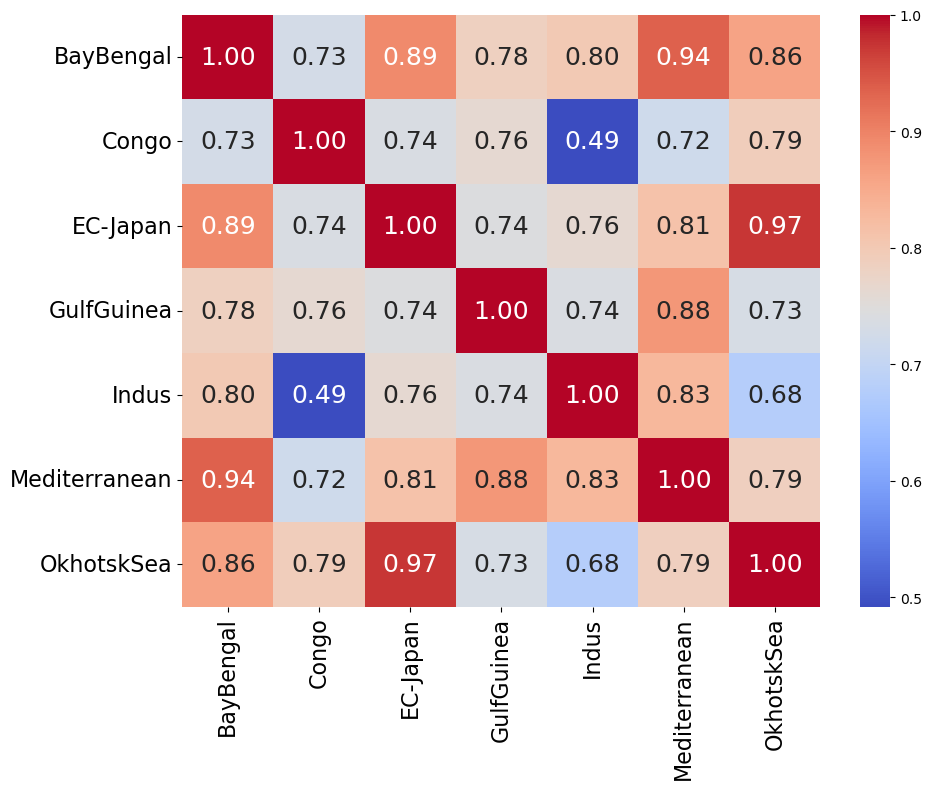

In [ ]:
fig = plt.figure(figsize=(10,8))
ax = sns.heatmap(spearman_corr, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size":18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig(r'C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Figures\Heatmap_IW.eps')

## GLAM

In [78]:
aggregate_matrices_GLAM = pd.DataFrame()
for key in dict_CF_GLAM.keys():
    df = dict_CF_GLAM[key]
    df.index = pd.MultiIndex.from_tuples([key])
    aggregate_matrices_GLAM = pd.concat([aggregate_matrices_GLAM, df])

In [80]:
df_corr_GLAM = aggregate_matrices_GLAM.loc[:,'ws.C'].unstack(level=0)#.reset_index()

In [81]:
df_corr_GLAM

BayBengal    Congo  EC-Japan  GulfGuinea    Indus  \
EPS  fiber  1      4.72e-10 4.25e-10  3.78e-10    1.28e-09 1.45e-10   
            10     1.12e-08 7.48e-09  1.07e-09    1.93e-09 8.58e-10   
            100    3.68e-09 1.33e-10  1.29e-09    8.28e-10 5.52e-10   
            1000   3.01e-09 1.75e-12  5.10e-10    4.40e-08 1.12e-08   
     sphere 1      1.41e-10 6.39e-11  4.56e-11    6.33e-10 1.15e-10   
...                     ...      ...       ...         ...      ...   
TRWP sphere 1      2.40e-10 5.96e-11  6.28e-11    9.96e-11 8.96e-11   
            10     4.84e-10 3.67e-10  1.15e-09    2.82e-09 1.65e-10   
            100    1.34e-08 8.96e-09  1.29e-09    8.13e-09 7.72e-10   
            1000   1.35e-08 9.04e-09  1.30e-09    8.20e-09 1.08e-08   
            5000   1.35e-08 9.04e-09  1.30e-09    8.20e-09 1.08e-08   

                  Mediterranean  OkhotskSea  
EPS  fiber  1          1.54e-10    2.98e-09  
            10         3.03e-09    8.43e-09  
            100        5.85e-11    1.09e-08  
            1000       2.01e-08    5.43e-10  
     sphere 1          7.48e-11    2.42e-09  
...                         ...         ...  
TRWP sphere 1          8.66e-11    4.88e-09  
            10         1.11e-10    9.71e-09  
            100        3.98e-09    1.11e-08  
            1000       4.01e-09    1.12e-08  
            5000       4.02e-09    1.12e-08  

[81 rows x 7 columns]

In [82]:
spearman_corr_GLAM = df_corr_GLAM.corr(method='spearman')

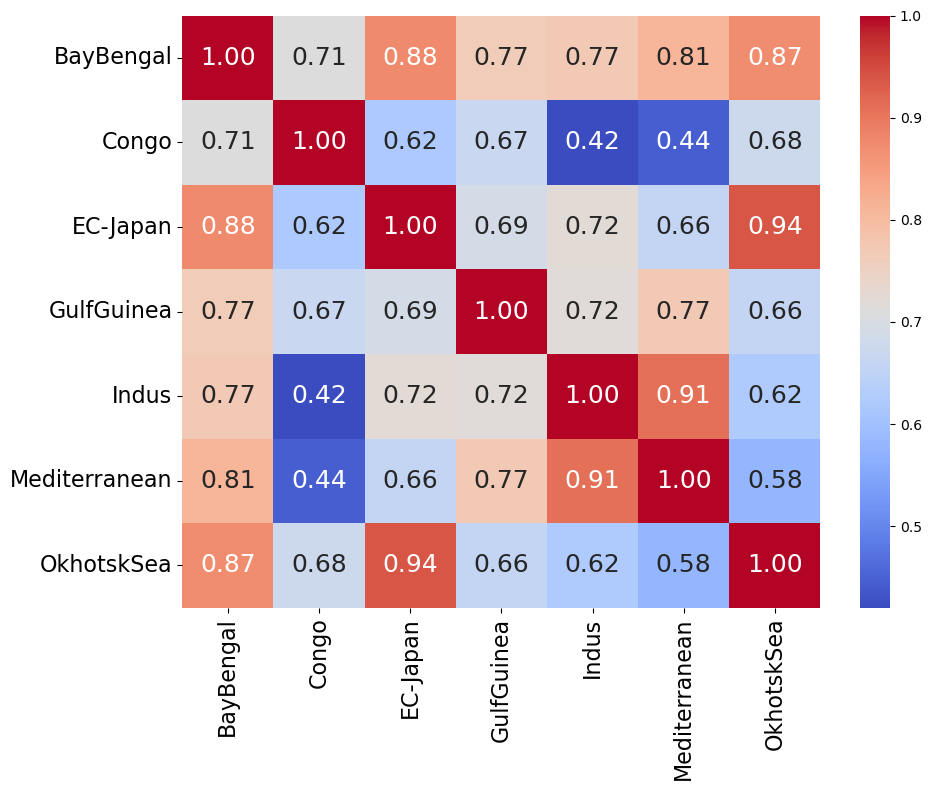

In [93]:
fig = plt.figure(figsize=(10,8))
ax = sns.heatmap(spearman_corr_GLAM, annot=True, cmap="coolwarm", fmt=".2f", annot_kws={"size":18})
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
plt.tight_layout()
plt.savefig(r'C:\Users\10User\Desktop\carla\Third_article\Processing_final_results\Figures\Heatmap_GLAM.eps')